In [1]:
from astropy.io import ascii 
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.modeling import models, fitting
import os
import pickle
from scipy.optimize import curve_fit

In [2]:
#total catalog from COSMOS(2016)
total = Table.read('./datas/cosmos2015_2.fits')

#mass complete sample
total_z = total[(total['zphot'] > 0) & (total['zphot'] < 9) & (total['OType'] == 0) & (total['Mass'] > 9.545)]

/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [3]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Define functions & variables

In [4]:
#find grid step: 100kpc
def find_grid_step(z):
    sep = cosmo.arcsec_per_kpc_proper(z) * 100 * u.kpc
    return sep.to(u.deg).value

#find bin size
def find_bin_size(z):
    del_z = 0.015 * (1+z)
    return del_z

#find search radius: 700kpc
def find_search_radius(z):
    r = cosmo.arcsec_per_kpc_proper(z) * 700 * u.kpc # arcsec
    
    return r.to(u.deg).value

#find redshift increment next to z
def find_bin_step(z):
    closest = 0
    compare_v = 100
    
    for i in np.arange(z+0.03, z, -0.00001):
        v = cosmo.H0 * (cosmo.comoving_distance(i) - cosmo.comoving_distance(z)) 
#         
        if np.abs(v.value - 1500) < compare_v:
            closest = i
            compare_v = np.abs(v.value - 1500)
#             print(compare_v, end = ' ')
    #return next z
    return closest

#find search radius: 1000kpc
def search_radius(z):
    r = cosmo.arcsec_per_kpc_proper(z) * 1000 * u.kpc # arcsec

    return r.to(u.deg).value
def lin_func(x, a):
    return a*x

def find_r200(z, m):
    G = 4.299e-3 * 1e-6 #Mpc /M. * km/s**2
    r = 10**(-2/3) * G**(1/3) * cosmo.H(z).value**(-2/3) * m**(1/3)
    return r #Mpc

def find_radius(z, r):
    r = cosmo.arcsec_per_kpc_proper(z) * r * u.Mpc # arcsec
    
    return r.to(u.deg).value

In [5]:
redshifts = [0.1]

while redshifts[-1] < 1.2:
    rs = find_bin_step(redshifts[-1])
    redshifts.append(rs)
    
redshifts = np.array(redshifts)

In [6]:
binsize = find_bin_size(redshifts)

In [7]:
#load found overdense region
with open('index1.txt', 'rb') as f:
    index1 = pickle.load(f)

with open('index2.txt', 'rb') as f:
    index2 = pickle.load(f)
    
with open('od4_ra.txt', 'rb') as f:
    od4_ra = pickle.load(f)

with open('od4_dec.txt', 'rb') as f:
    od4_dec = pickle.load(f)
    
with open('zstart.txt', 'rb') as f:
    zstart = pickle.load(f)
    
with open('zend.txt', 'rb') as f:
    zend = pickle.load(f)

In [8]:
#crossmatched catalog with darvish
darvish = Table.read('./datas/cosmos2015_extra_crossmatched1')
darvish = darvish.to_pandas()

In [9]:
#zcosmos 10k /20k catalog
group_10k = Table.read('./datas/zCOSMOS_10k_group_catalog')
group_10k = group_10k.to_pandas()
galaxies_10k = Table.read('./datas/zCOSMOS_10k_group_galaxies')
galaxies_10k = galaxies_10k.to_pandas()

group_20k = Table.read('./datas/zCOSMOS_20k_group_catalog')
group_20k = group_20k.to_pandas()
galaxies_20k = Table.read('./datas/zCOSMOS_20k_group_galaxies')
galaxies_20k = galaxies_20k.to_pandas()

/home/ehko/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: TableReplaceWarning: converted column 'Disp' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
#xray group
xgroup = ascii.read('./datas/xgroups.tbl')
xgroup = xgroup.to_pandas()

xgalaxies = ascii.read('./datas/xg_galaxies.tbl')
xgalaxies = xgalaxies.to_pandas()

# xgroup_z = xgroup[xgroup['REDSHIFT'] > 0.78]
# len(xgroup_z)

/home/ehko/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: TableReplaceWarning: converted column 'ID_MMGGS' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ehko/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: TableReplaceWarning: converted column 'ID_MMGGS_ZBEST' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ehko/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: TableReplaceWarning: converted column 'GROUP_ID' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ehko/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: TableReplaceWarning: converted column 'GROUP_ID_ZBEST' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
#xray 2018
x_new = ascii.read('./datas/xray_2018.txt')

In [12]:
bellagamba = Table.read('./datas/bellagamba2011')
bellagamba = bellagamba.to_pandas()

# Cluster Candidates

## matched

In [12]:
js_new = [0, 3, 4, 5, 7,
         8, 10, 11, 12, 13,
         14, 15, 16, 17, 18,
         22, 24, 25, 26, 29,
         30, 36, 37, 39, 42,
         44, 46, 47, 48, 50,
         51, 54, 55, 56, 57,
         58, 60, 61, 62, 64,
         66, 68, 69, 71, 74,
         80, 81]
xnums_new = [[20025], [20011], [30331, 20201, 20193, 10163, 20191, 20321], [20011], [30311, 30224],
            [30276], [10054], [20079, 10113, 20088], [30311, 30224], [20099, 30298],
            [20212], [20029], [20283, 20290], [20017], [20282],
            [20137], [30190], [20147], [20253], [20024],
            [20128], [10220], [20241], [10216, 30231], [20288, 10220, 20214],
            [10220, 20214], [10220, 20214, 30230], [20120], [20071], [20187],
            [10208], [30172], [30296], [20104], [20192],
            [20234], [20134], [10280], [10281], [20134],
            [30123], [20174], [10040], [20134], [20199],
            [10280], [10063]]

0 149.88754613393735 1.7975253375901514 0.1326253571427047
11.467199609632635 13.64669775089304
1 150.19491959801832 1.694391056145508 0.20592805555507177
12.082409489684046 14.230474482688297
2 150.08944133099808 2.383442270244323 0.2142766265469348
flag!
11.928682991986962 14.066102195274865
3 150.1894275721544 1.6821243851974956 0.2242682562271937
12.061872130771208 14.230474482688297
4 149.91838079467126 2.600867373652456 0.2599189050029079
flag!
12.007095078596205 13.684997882590547
5 149.8443571434239 2.6891153229324924 0.26960779895937953
11.652589182283608 13.88603361253725
6 150.5722636684613 1.9366465234744887 0.2979507213105976
11.901735149174577 13.602775997528713
7 150.44931115059555 2.053428501719848 0.31413580714191264
flag!
12.128041282606096 14.047119033654841
8 149.95824543140571 2.606216299567661 0.3318735789463517
flag!
12.160610315320561 13.684997882590547
9 149.79609674968185 2.153608606404859 0.3558268092474422
flag!
12.135831701382628 13.551962053679187
10 149.8

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


20 150.5739000807177 2.1674843445503416 0.5414350929664625
12.218599198020014 13.548241978695824
21 149.92107753906836 2.5278763732829295 0.6138773705186492
12.216385570175758 14.367411823988816
22 150.48909223318162 2.754599119074926 0.6184646069876886
12.140312667161984 13.623755682289907
23 150.05716196565805 2.6088081052298917 0.6766462905215124
flag!
12.474209296825578 13.964165315338226
24 149.9121764121137 2.521358963089616 0.6856875461239201
flag!
12.844819433374223 14.529636921090201
25 149.91872231378028 2.5061489060824904 0.7200422137576153
flag!
12.858299698335314 14.462092377699271
26 149.93203099713278 2.5166747418702093 0.7505134608931492
flag!
12.819078356051879 14.502021308822783
27 150.53080336443995 2.2056043563610572 0.8264324280682833
12.725551211506668 14.260810500595682
28 150.36518484330892 2.0013172889405473 0.8057712113651171
12.334409797028886 13.729083765147633
29 149.63028931394987 2.3946282579148637 0.8199440157515928
12.384345631591266 13.859288448324783


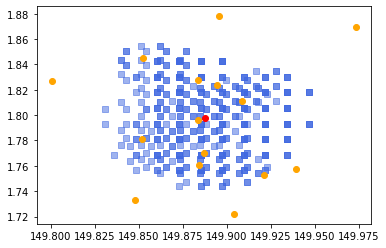

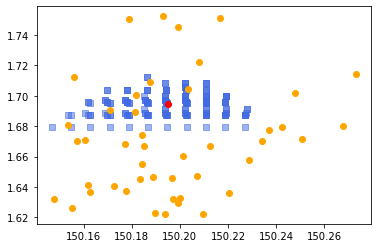

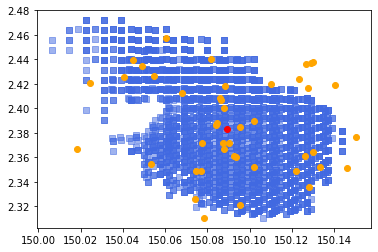

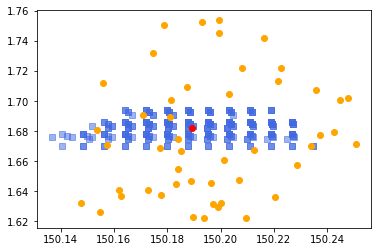

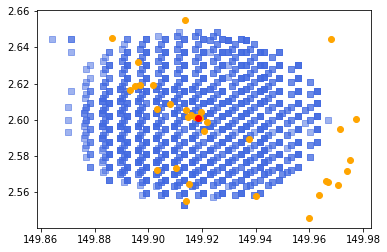

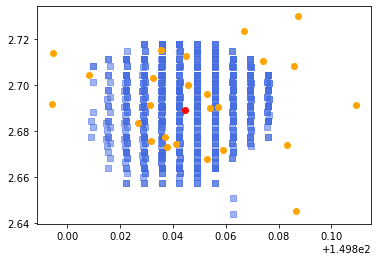

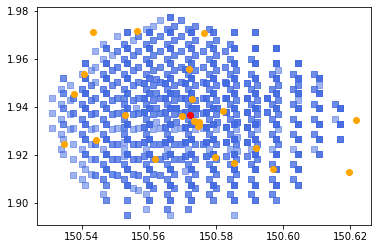

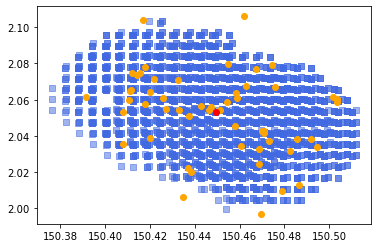

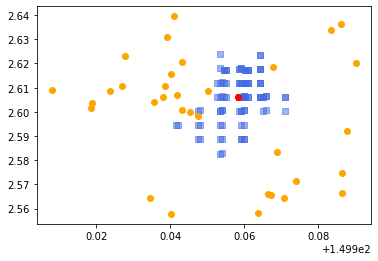

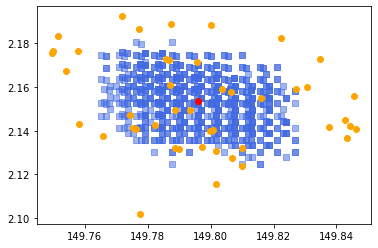

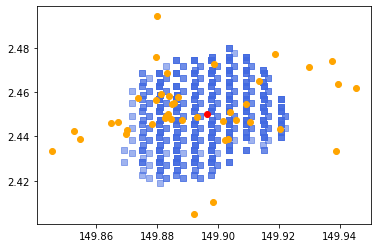

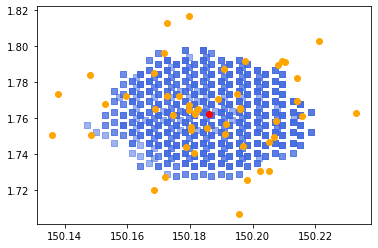

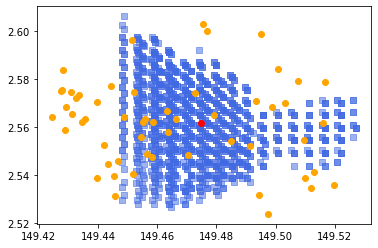

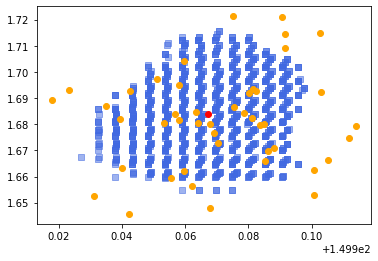

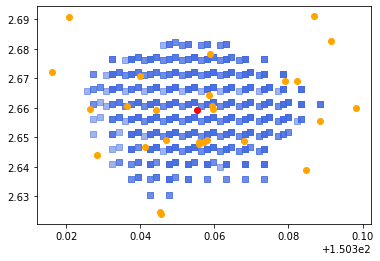

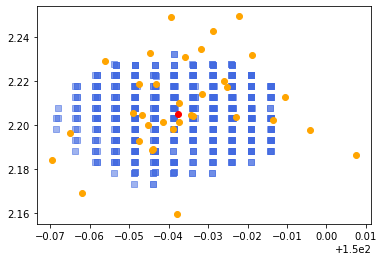

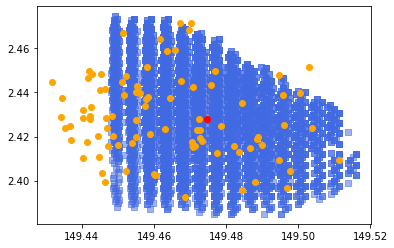

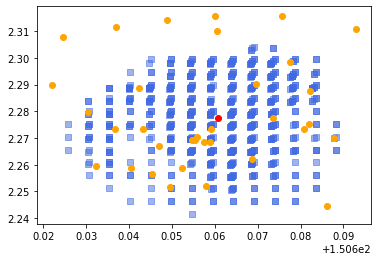

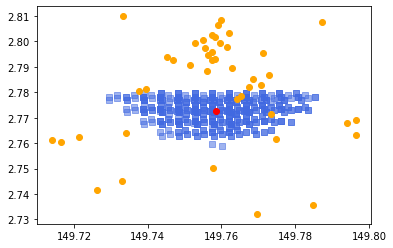

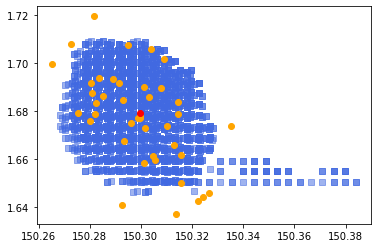

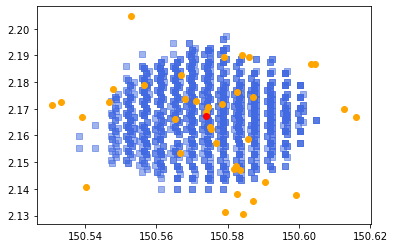

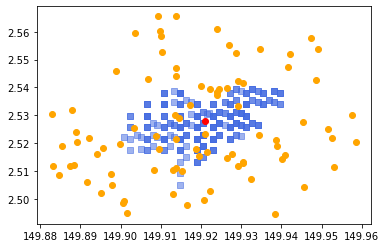

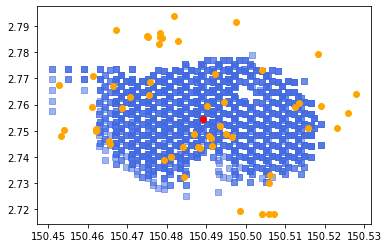

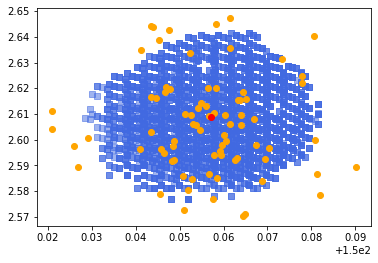

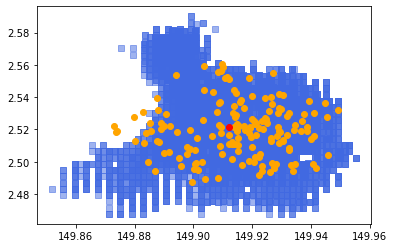

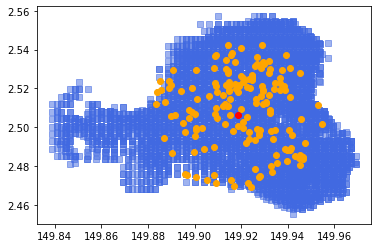

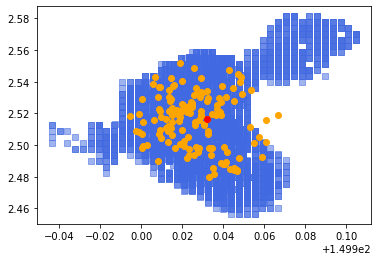

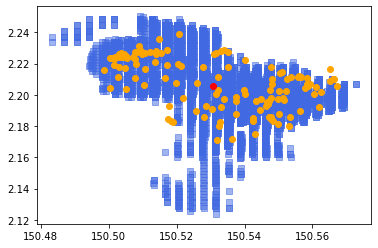

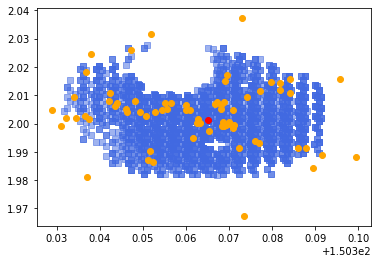

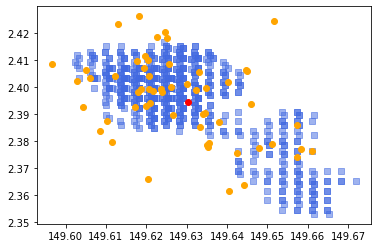

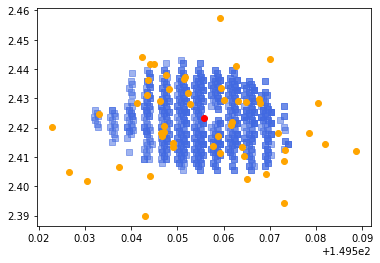

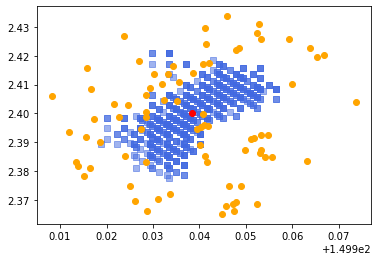

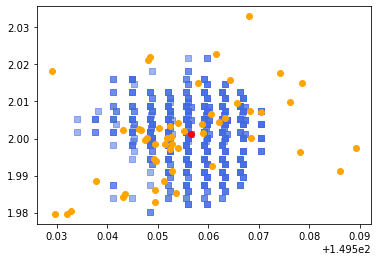

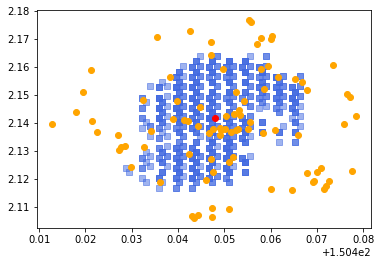

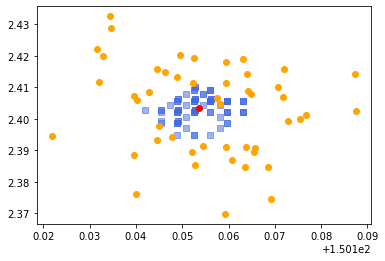

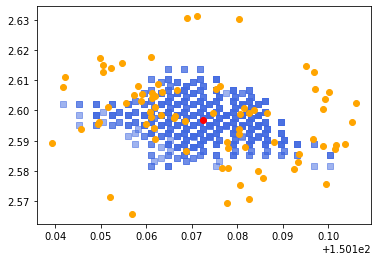

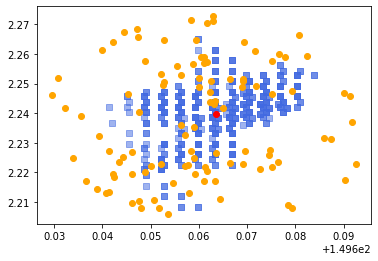

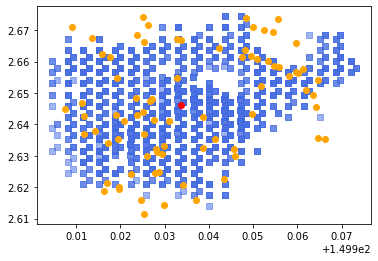

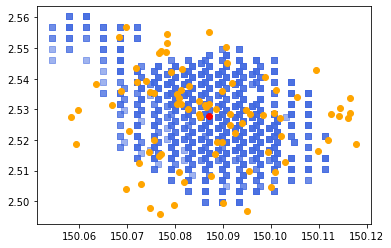

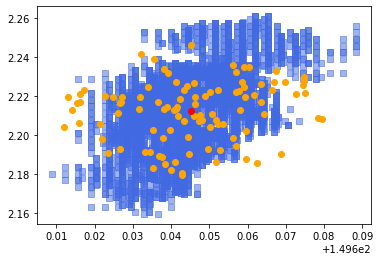

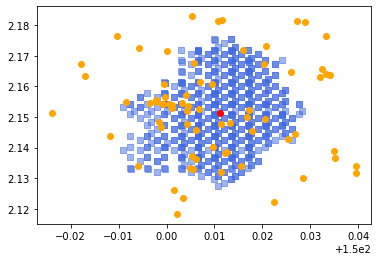

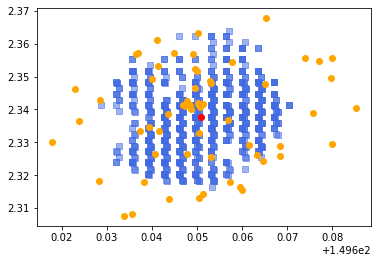

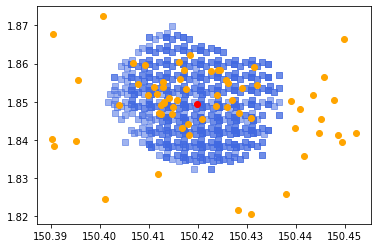

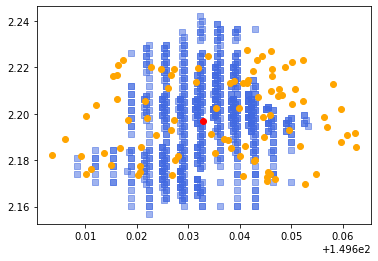

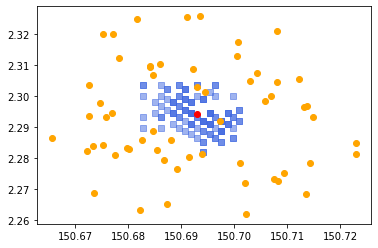

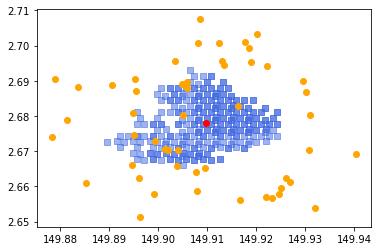

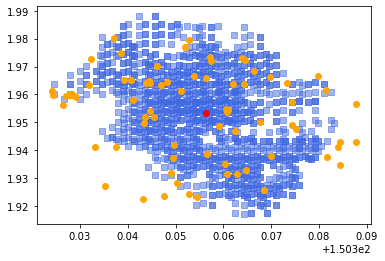

In [13]:
mass_new = []
m200_new = []
ra_cls_new = []
dec_cls_new = []
z_cls_new = []

members_new = []

for i in range(len(js_new)):
    plt.figure()
    
    num = 0
    ra = 0
    dec = 0
    z = 0
    for j in range(len(index1[js_new[i]])):
        plt.scatter(od4_ra[index1[js_new[i]][j]][index2[js_new[i]][j]], od4_dec[index1[js_new[i]][j]][index2[js_new[i]][j]], marker = 's',color = 'royalblue', alpha = .5)
        
        ra += len(od4_ra[index1[js_new[i]][j]][index2[js_new[i]][j]]) * od4_ra[index1[js_new[i]][j]][index2[js_new[i]][j]].mean()
        dec += len(od4_dec[index1[js_new[i]][j]][index2[js_new[i]][j]]) * od4_dec[index1[js_new[i]][j]][index2[js_new[i]][j]].mean()
        z += len(od4_dec[index1[js_new[i]][j]][index2[js_new[i]][j]]) * redshifts[zstart[js_new[i]][0] + j]
        num += len(od4_ra[index1[js_new[i]][j]][index2[js_new[i]][j]])
    
    ra_cl = ra / num
    dec_cl = dec / num
    z_cl = z / num
    
    print(i, ra_cl, dec_cl, z_cl)
    
    rad = search_radius(z_cl)
    smask = (total_z['RAJ2000'] - ra_cl)**2 + (total_z['DEJ2000'] - dec_cl)**2 <= rad**2
    zmask = (total_z['zphot'] >= z_cl - 0.05 * (z_cl+1)) & (total_z['zphot'] <= z_cl + 0.05 * (z_cl+1))
    samp = total_z[smask & zmask]
    
    members_new.append(list(samp['Seq']))
    
    plt.scatter(samp['RAJ2000'], samp['DEJ2000'], color = 'orange')
    plt.scatter(ra_cl, dec_cl, color = 'red')
    
    tm = np.log10(sum(10**samp['Mass']))
    
    #for now, assume several x-ray clusters in one overdense region as one cluster
    hms = []
    for j in range(len(xnums_new[i])):
        xsamp = x_new[x_new['ID_COSMOS'] == xnums_new[i][j]]
        hms.extend(list(xsamp['M200c']))
    
    if len(hms) > 1:
        print('flag!')
    
    hm = np.log10(sum(hms))
    print(tm, hm)
    mass_new.append(tm)
    m200_new.append(hm)
    z_cls_new.append(z_cl)
    ra_cls_new.append(ra_cl)
    dec_cls_new.append(dec_cl)

In [14]:
mass_new_list = [10**x for x in mass_new]
m200_new_list = [10**x for x in m200_new]

[37.33262365]


Text(0, 0.5, 'halo mass')

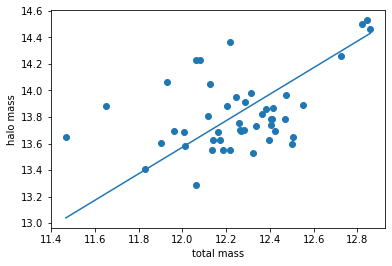

In [15]:
popt, pcov = curve_fit(lin_func, mass_new_list, m200_new_list)
print(popt)

x = np.logspace(min(mass_new), max(mass_new), 10)
y = lin_func(x, popt[0])


# mass, m200

plt.scatter(mass_new, m200_new)
plt.plot(np.log10(x), np.log10(y))
plt.xlabel('total mass')
plt.ylabel('halo mass')

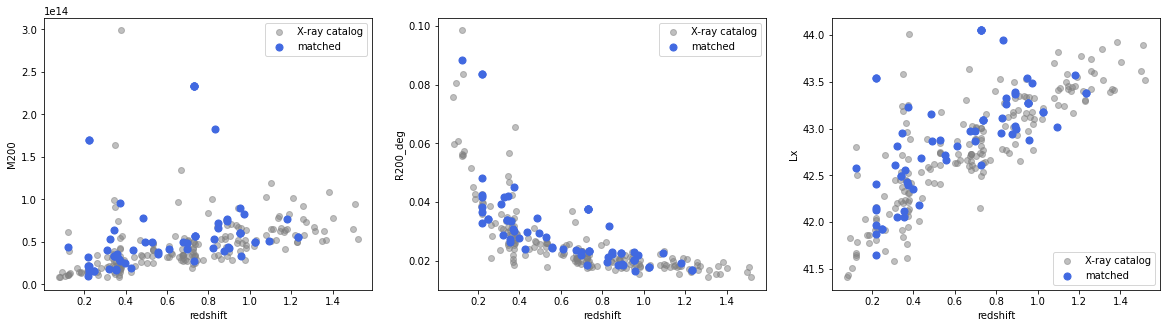

In [16]:
fig, ax = plt.subplots(1, 3, figsize = (20, 5))

ax[0].scatter(x_new['redshift'], x_new['M200c'], color = 'grey', alpha = .5, label = 'X-ray catalog')

for i in range(len(xnums_new)):
    for j in range(len(xnums_new[i])):
        xsamp = x_new[x_new['ID_COSMOS'] == xnums_new[i][j]]
        ax[0].scatter(xsamp['redshift'], xsamp['M200c'], color = 'royalblue', s = 50)
ax[0].scatter(xsamp['redshift'], xsamp['M200c'], color = 'royalblue', s = 50, label = 'matched')
ax[0].set_xlabel('redshift', fontsize = 10)
ax[0].set_ylabel('M200', fontsize = 10)
ax[0].legend(fontsize = 10)

ax[1].scatter(x_new['redshift'], x_new['R200_deg'], color = 'grey', alpha = .5, label = 'X-ray catalog')

for i in range(len(xnums_new)):
    for j in range(len(xnums_new[i])):
        xsamp = x_new[x_new['ID_COSMOS'] == xnums_new[i][j]]
        ax[1].scatter(xsamp['redshift'], xsamp['R200_deg'], color = 'royalblue', s = 50)
ax[1].scatter(xsamp['redshift'], xsamp['R200_deg'], color = 'royalblue', s = 50, label = 'matched')
ax[1].set_xlabel('redshift', fontsize = 10)
ax[1].set_ylabel('R200_deg', fontsize = 10)
ax[1].legend(fontsize = 10)

ax[2].scatter(x_new['redshift'], np.log10(x_new['Lx']), color = 'grey', alpha = .5, label = 'X-ray catalog')

for i in range(len(xnums_new)):
     for j in range(len(xnums_new[i])):
        xsamp = x_new[x_new['ID_COSMOS'] == xnums_new[i][j]]
        ax[2].scatter(xsamp['redshift'], np.log10(xsamp['Lx']), color = 'royalblue', s = 50)
ax[2].scatter(xsamp['redshift'], np.log10(xsamp['Lx']), color = 'royalblue', s = 50, label = 'matched')
ax[2].set_xlabel('redshift', fontsize = 10)
ax[2].set_ylabel('Lx', fontsize = 10)
ax[2].legend(fontsize = 10)

In [17]:
total_pd = total_z.to_pandas()

In [18]:
q_fraction_new = [] #Cl = 0: quiescent galaxy, Cl = 1: star-forming
dist_new = []
sfr_new = []

mz_new = []

for i in range(len(members_new)):
    plt.figure()
    mask = total_pd['Seq'].isin(members_new[i])
    samp = total_pd[mask]
    
    #quiescent galaxy fraction
    frac = 1 - sum(samp['Cl']) / len(samp)
    q_fraction_new.append(frac)
    
    #distance
    d = ((ra_cls_new[i] - samp['RAJ2000'])**2 + (dec_cls_new[i] - samp['DEJ2000'])**2)**(1/2)
    dist_new.append(list(d))
    
    #sfr
    
    sfr_new.append(list(samp['SFR']))
    
    mz_new.append(list(samp['zphot']))
    
#     plt.scatter(d, list(samp['SFR']))

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>


## non

In [19]:
overall = np.array(range(len(index1)))

In [20]:
mask = np.isin(overall, js_new)
nons = overall[~mask]

In [21]:
mass_non = []
ra_non = []
dec_non = []
z_non = []
rad_non = []
for i, v in enumerate(nons):    
    num = 0
    ra = 0
    dec = 0
    z = 0
    for j in range(len(index1[v])):        
        ra += len(od4_ra[index1[v][j]][index2[v][j]]) * od4_ra[index1[v][j]][index2[v][j]].mean()
        dec += len(od4_dec[index1[v][j]][index2[v][j]]) * od4_dec[index1[v][j]][index2[v][j]].mean()
        z += len(od4_dec[index1[v][j]][index2[v][j]]) * redshifts[zstart[v][0] + j]
        num += len(od4_ra[index1[v][j]][index2[v][j]])
    
    ra_cl = ra / num
    dec_cl = dec / num
    z_cl = z / num
    
    print(i, ra_cl, dec_cl, z_cl)
    
    rad = search_radius(z_cl)
    smask = (total_z['RAJ2000'] - ra_cl)**2 + (total_z['DEJ2000'] - dec_cl)**2 <= rad**2
    zmask = (total_z['zphot'] >= z_cl - 0.05 * (z_cl+1)) & (total_z['zphot'] <= z_cl + 0.05 * (z_cl+1))
    samp = total_z[smask & zmask]
    
#     plt.scatter(samp['RAJ2000'], samp['DEJ2000'], color = 'orange')
#     plt.scatter(ra_cl, dec_cl, color = 'red')
    
    tm = np.log10(sum(10**samp['Mass']))
    
    mass_non.append(tm)
    z_non.append(z_cl)
    ra_non.append(ra_cl)
    dec_non.append(dec_cl)
    rad_non.append(rad)

0 150.69344999473077 2.399111717710011 0.16179927419326223
1 150.66549257213123 2.404926782382963 0.18141806493469023
2 150.40707727582026 2.5454275831734776 0.24206129629565484
3 149.4697474217885 1.9326687729013288 0.28467406593324335
4 149.67645172399787 2.7270604078174463 0.4116794887767241
5 149.48135363055596 2.6817029911303503 0.4174711764692353
6 150.68841333407536 2.002464508285162 0.4244354794506754
7 150.71006207667463 2.0100867844669152 0.4433702464774226
8 150.3227470591011 2.751952677623451 0.4898632258052284
9 150.31843118248287 2.5034923598857257 0.5041862849862881
10 150.27644076600922 1.8872668798600936 0.5433892207788592
11 149.52400802997033 1.7708247351892252 0.5632022436547711
12 149.44912312568982 1.7358424434551378 0.5773455555557224
13 149.61869750086888 1.7343082466537973 0.5873239943345977
14 150.59993757061045 2.3808780449487643 0.6001353731348428
15 150.6335187292794 2.717011756837453 0.6320845770402655
16 149.939971434046 2.0993371661021962 0.6617632113835

In [22]:
m200_non_list = [37 * 10**x for x in mass_non]

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


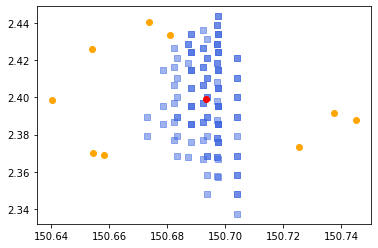

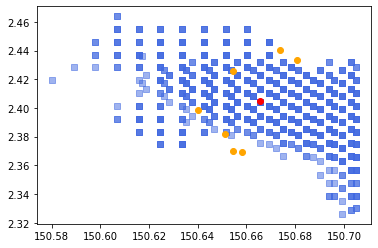

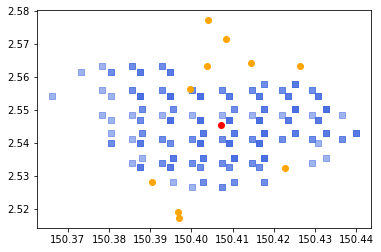

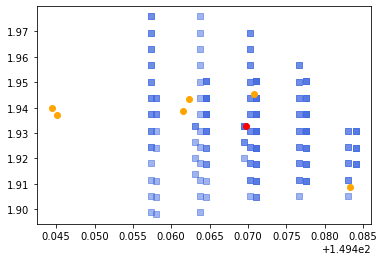

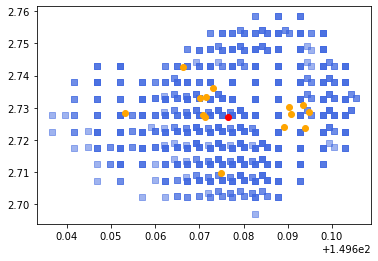

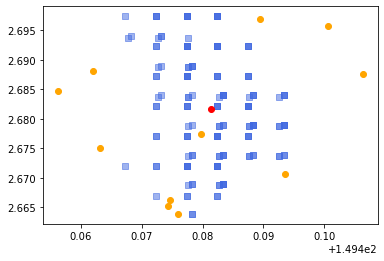

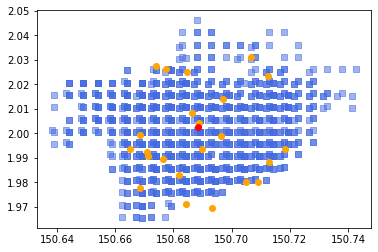

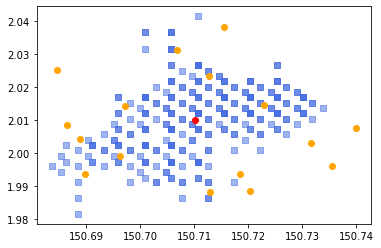

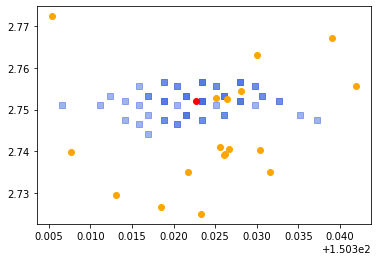

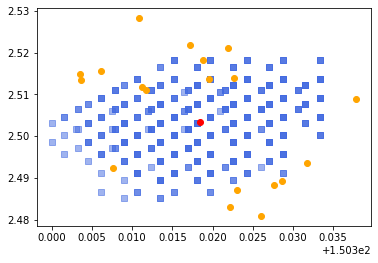

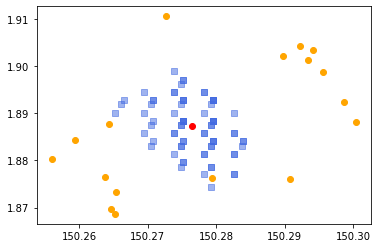

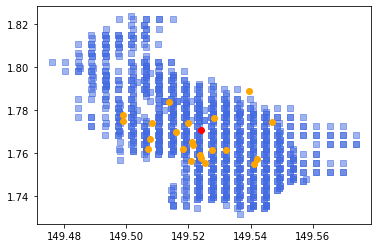

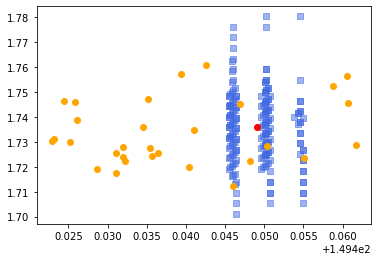

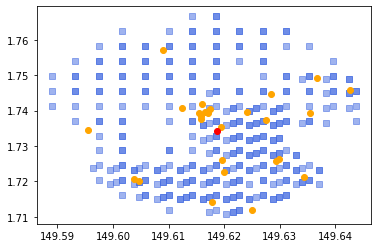

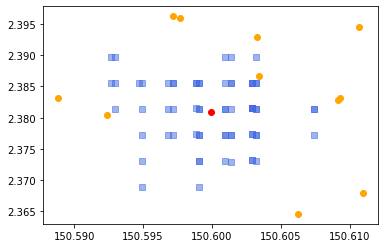

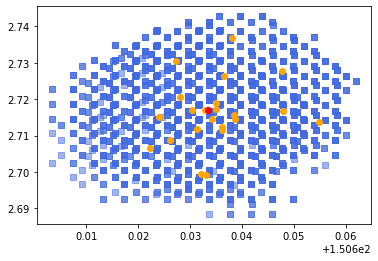

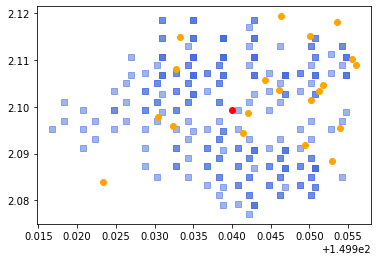

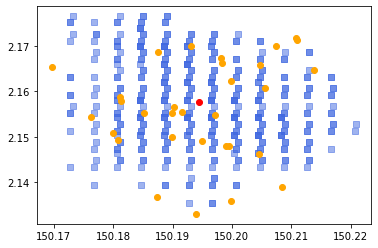

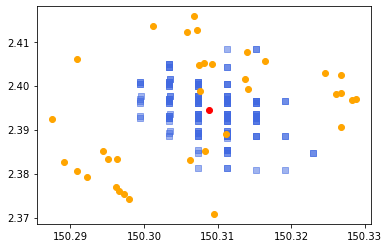

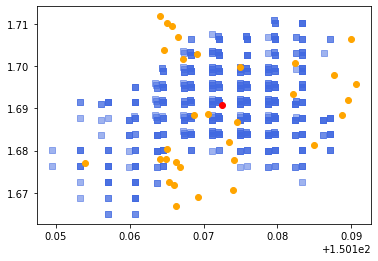

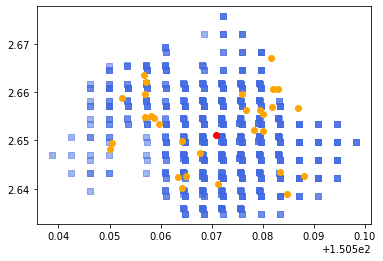

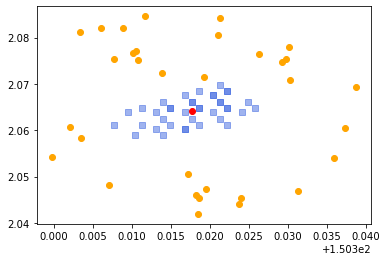

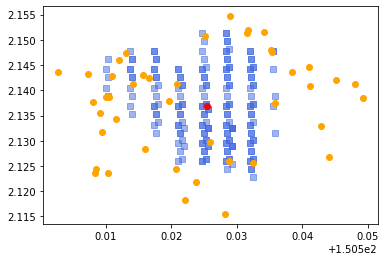

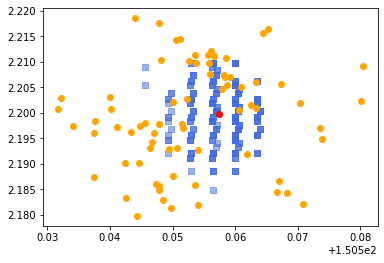

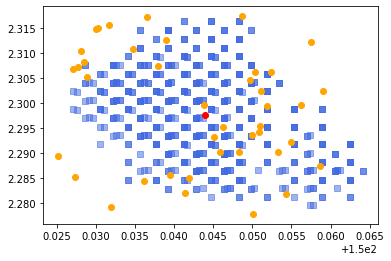

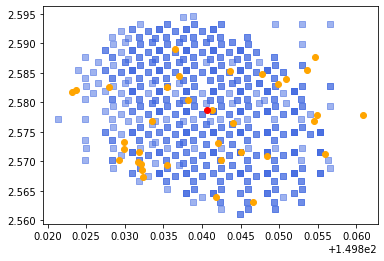

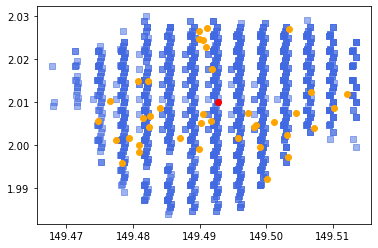

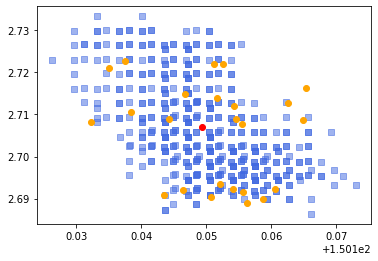

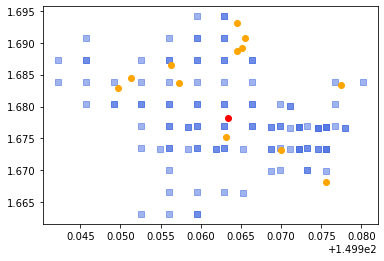

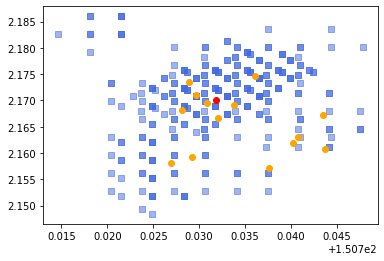

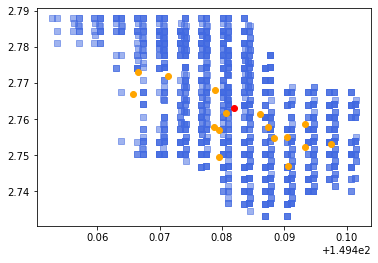

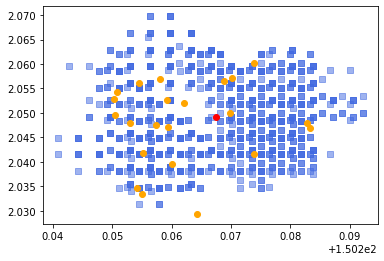

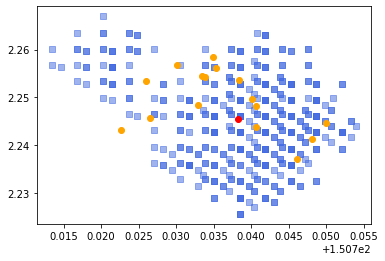

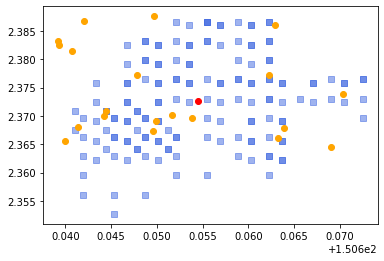

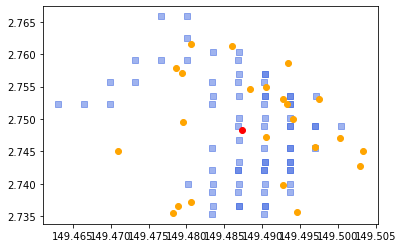

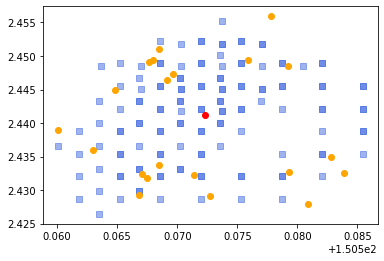

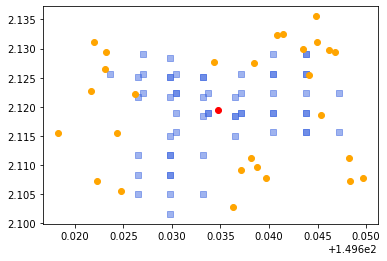

In [23]:
members_non =[]

for i, v in enumerate(nons):
    plt.figure()
    
    for j in range(len(index1[v])):
        plt.scatter(od4_ra[index1[v][j]][index2[v][j]], od4_dec[index1[v][j]][index2[v][j]], marker = 's',color = 'royalblue', alpha = .5)
        
        ra += len(od4_ra[index1[v][j]][index2[v][j]]) * od4_ra[index1[v][j]][index2[v][j]].mean()
        dec += len(od4_dec[index1[v][j]][index2[v][j]]) * od4_dec[index1[v][j]][index2[v][j]].mean()
        z += len(od4_dec[index1[v][j]][index2[v][j]]) * redshifts[zstart[v][0] + j]
        num += len(od4_ra[index1[v][j]][index2[v][j]])
    
    ra_cl = ra_non[i]
    dec_cl = dec_non[i]
    z_cl = z_non[i]
    m = m200_non_list[i]
    
    r200 = find_r200(z_cl, m) #Mpc
    rad = find_radius(z_cl, r200)#Mpc to deg separation
    
    smask = (total_z['RAJ2000'] - ra_cl)**2 + (total_z['DEJ2000'] - dec_cl)**2 <= rad**2
    zmask = (total_z['zphot'] >= z_cl - 0.05 * (z_cl+1)) & (total_z['zphot'] <= z_cl + 0.05 * (z_cl+1))
    samp = total_z[smask & zmask]
    
    members_non.append(list(samp['Seq']))
    
    plt.scatter(samp['RAJ2000'], samp['DEJ2000'], color = 'orange')
    plt.scatter(ra_cl, dec_cl, color = 'red')

In [24]:
total_pd = total_z.to_pandas()

In [25]:
q_fraction_non = [] #Cl = 0: quiescent galaxy, Cl = 1: star-forming
dist_non = []
sfr_non = []
mz_non = []

for i in range(len(members_non)):
    plt.figure()
    mask = total_pd['Seq'].isin(members_non[i])
    samp = total_pd[mask]
    
    #quiescent galaxy fraction
    frac = 1 - sum(samp['Cl']) / len(samp)
    q_fraction_non.append(frac)
    
    #distance
    d = ((ra_non[i] - samp['RAJ2000'])**2 + (dec_non[i] - samp['DEJ2000'])**2)**(1/2)
    dist_non.append(list(d))
    
    #sfr
    
    sfr_non.append(list(samp['SFR']))
    
    mz_non.append(list(samp['zphot']))
    
#     plt.scatter(d, list(samp['SFR']))

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

## overall match

In [13]:
# overall 
overall = [36, 37, 39, 40, 41, 42, 44, 46, 47, 48, 50, 51, 54, 55, 57, 58, 60, 61, 62, 64, 66, 68, 69, 71, 
          71]

0 149.92107753906836 2.5278763732829295 0.6138773705186492
1 150.48909223318162 2.754599119074926 0.6184646069876886
2 150.05716196565805 2.6088081052298917 0.6766462905215124
3 149.939971434046 2.0993371661021962 0.6617632113835367
4 150.1943778598824 2.1577120353611687 0.6595518244817605
5 149.9121764121137 2.521358963089616 0.6856875461239201
6 149.91872231378028 2.5061489060824904 0.7200422137576153
7 149.93203099713278 2.5166747418702093 0.7505134608931492
8 150.53080336443995 2.2056043563610572 0.8264324280682833
9 150.36518484330892 2.0013172889405473 0.8057712113651171
10 149.63028931394987 2.3946282579148637 0.8199440157515928
11 149.55583865354953 2.4231500575935927 0.8303774867058201
12 149.9383823236833 2.4000315257890223 0.8829643979100991
13 149.5566304773033 2.001277850875573 0.8834307661333782
14 150.15355635619824 2.4033834929753977 0.8863574683588116
15 150.17251994630294 2.5967507768084035 0.9008841560555102
16 149.6635413498012 2.2397254856548354 0.9186856550265989


/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


20 150.0110616061233 2.1512253229725573 0.9534105034773874
21 149.650779614574 2.3375632488290887 0.9682619008317794
22 150.41986441714238 1.8494125217926596 0.9795754523575131
23 149.63281461234286 2.1969255567619075 1.0316005540942812
24 149.63281461234286 2.1969255567619075 1.0316005540942812


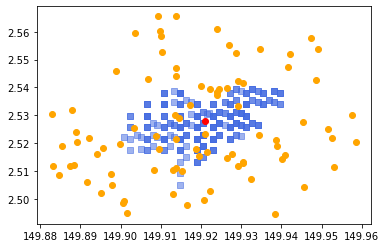

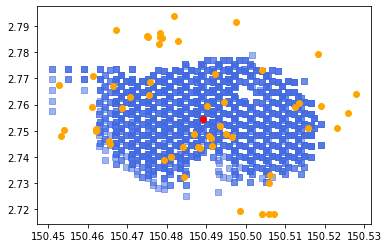

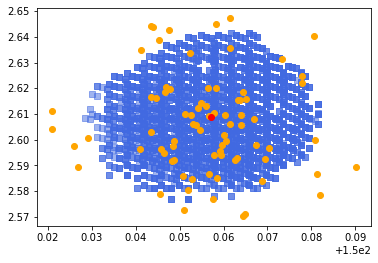

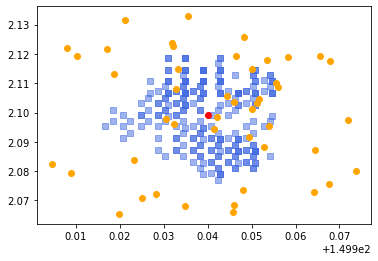

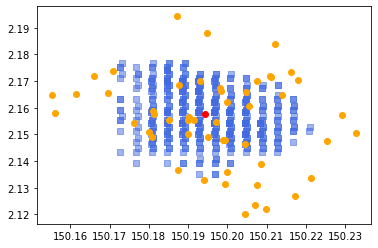

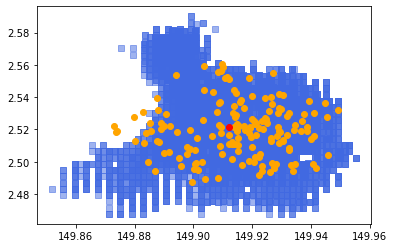

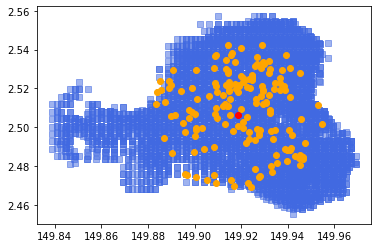

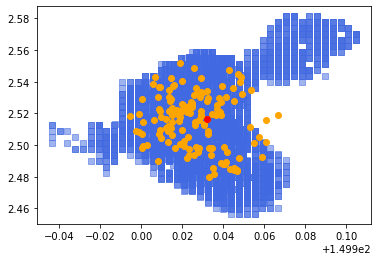

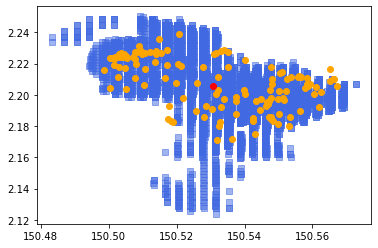

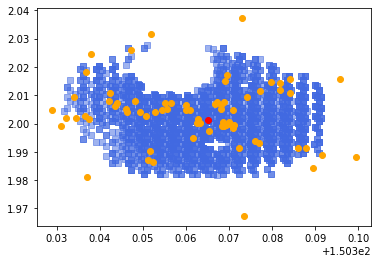

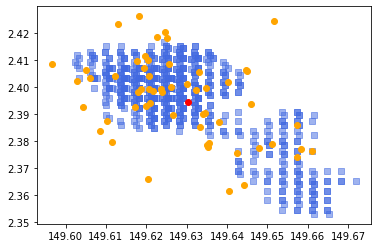

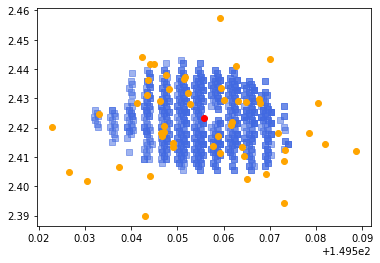

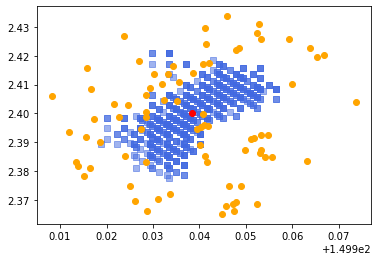

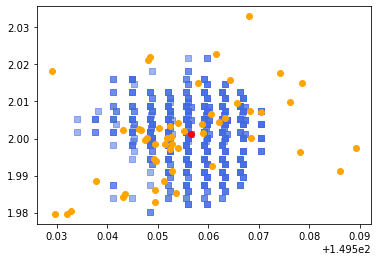

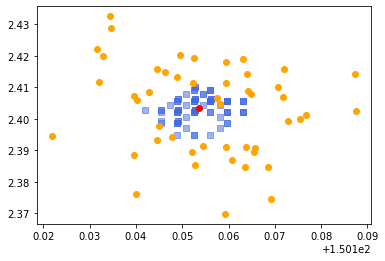

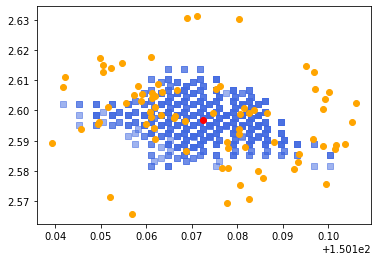

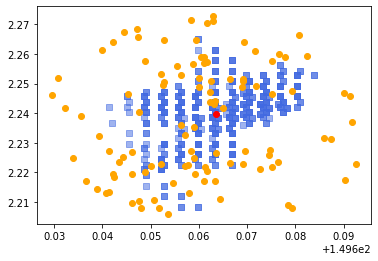

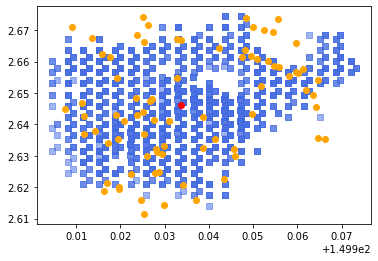

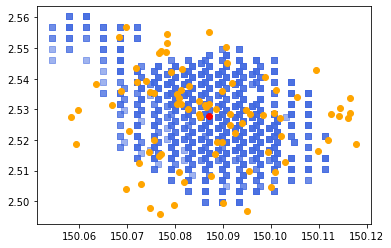

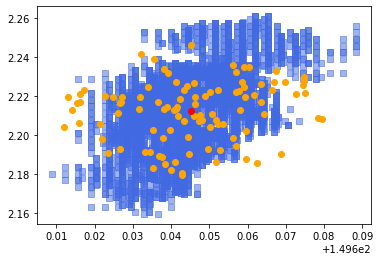

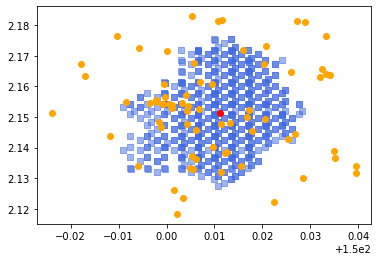

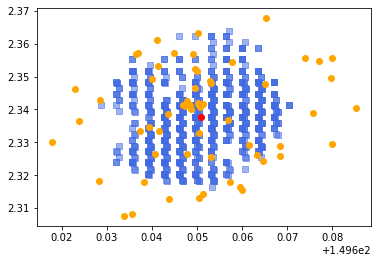

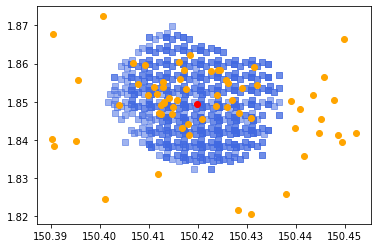

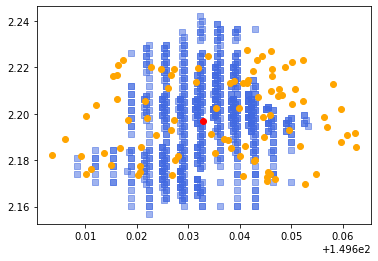

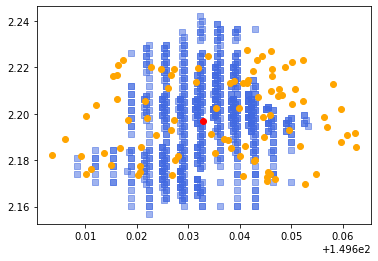

In [14]:
mass_oa = []
ra_cls_oa = []
dec_cls_oa = []
z_cls_oa = []

members_oa = []

for i in range(len(overall)):
    plt.figure()
    
    num = 0
    ra = 0
    dec = 0
    z = 0
    for j in range(len(index1[overall[i]])):
        plt.scatter(od4_ra[index1[overall[i]][j]][index2[overall[i]][j]], od4_dec[index1[overall[i]][j]][index2[overall[i]][j]], marker = 's',color = 'royalblue', alpha = .5)
        
        ra += len(od4_ra[index1[overall[i]][j]][index2[overall[i]][j]]) * od4_ra[index1[overall[i]][j]][index2[overall[i]][j]].mean()
        dec += len(od4_dec[index1[overall[i]][j]][index2[overall[i]][j]]) * od4_dec[index1[overall[i]][j]][index2[overall[i]][j]].mean()
        z += len(od4_dec[index1[overall[i]][j]][index2[overall[i]][j]]) * redshifts[zstart[overall[i]][0] + j]
        num += len(od4_ra[index1[overall[i]][j]][index2[overall[i]][j]])
    
    ra_cl = ra / num
    dec_cl = dec / num
    z_cl = z / num
    
    print(i, ra_cl, dec_cl, z_cl)
    
    rad = search_radius(z_cl)
    smask = (total_z['RAJ2000'] - ra_cl)**2 + (total_z['DEJ2000'] - dec_cl)**2 <= rad**2
    zmask = (total_z['zphot'] >= z_cl - 0.05 * (z_cl+1)) & (total_z['zphot'] <= z_cl + 0.05 * (z_cl+1))
    samp = total_z[smask & zmask]
    
    members_oa.append(list(samp['Seq']))
    
    plt.scatter(samp['RAJ2000'], samp['DEJ2000'], color = 'orange')
    plt.scatter(ra_cl, dec_cl, color = 'red')
    
    tm = np.log10(sum(10**samp['Mass']))
    
    mass_oa.append(tm)
    z_cls_oa.append(z_cl)
    ra_cls_oa.append(ra_cl)
    dec_cls_oa.append(dec_cl)

In [15]:
m200_oa_list = [37 * 10**x for x in mass_oa]

## Comparison

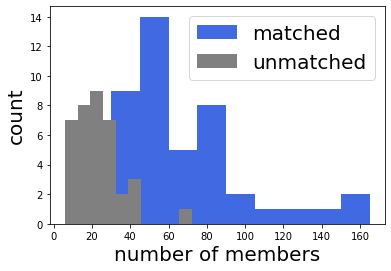

In [59]:
num_mems_new = [len(x) for x in members_new]
num_mems_non = [len(x) for x in members_non]
plt.hist(num_mems_new, color = 'royalblue', label = 'matched')
plt.hist(num_mems_non, color = 'grey', label = 'unmatched')

plt.xlabel('number of members',fontsize = 20)
plt.ylabel('count',fontsize = 20)

plt.legend(fontsize = 20)
plt.savefig('figures/number_of_members.png')

In [27]:
## redshift - F_q

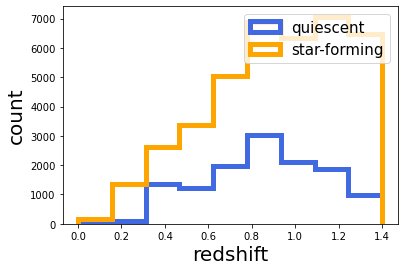

In [62]:
qs = total_z[total_z['Cl'] == 0]
sf = total_z[total_z['Cl'] == 1]
plt.hist(qs['zphot'], color = 'royalblue', histtype = 'step', linewidth = 5, bins = np.linspace(0, 1.4, 10), label = 'quiescent')
plt.hist(sf['zphot'], color = 'orange', histtype = 'step', linewidth = 5, bins = np.linspace(0, 1.4, 10), label = 'star-forming')
plt.legend(fontsize = 15)

plt.xlabel('redshift',fontsize = 20)
plt.ylabel('count', fontsize = 20)
plt.savefig('figures/redshift_dist.png')

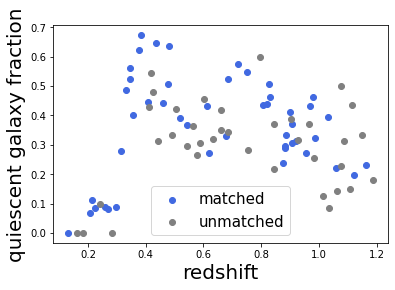

In [66]:
# q_fraction_new
# z_cls_new
plt.scatter(z_cls_new, q_fraction_new, color = 'royalblue', label = 'matched')
plt.scatter(z_non, q_fraction_non, color = 'grey', label = 'unmatched')

plt.xlabel('redshift', fontsize = 20)
plt.ylabel('quiescent galaxy fraction', fontsize = 20)
plt.legend(fontsize = 15)

plt.savefig('figures/redshift_distribution2.png')

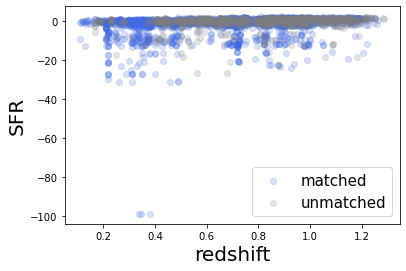

In [68]:
# q_fraction_new
# z_cls_new
plt.scatter(np.concatenate(mz_new), np.concatenate(sfr_new), color = 'royalblue', label = 'matched', alpha = .2)
plt.scatter(np.concatenate(mz_non), np.concatenate(sfr_non), color = 'grey', label = 'unmatched', alpha = .2)

plt.xlabel('redshift', fontsize = 20)
plt.ylabel('SFR', fontsize = 20)
plt.legend(fontsize = 15)

plt.savefig('figures/sfr_distribution.png')

# Large Scale Structure

In [20]:
file_list = os.listdir(f'./bins/density_field/bins_new_all')
file_list.sort()

mask1_list = os.listdir(f'./bins/density_field/bins_new_all/mask1_10/')
mask2_list = os.listdir(f'./bins/density_field/bins_new_all/mask2_10/')
mask1_list.sort()
mask2_list.sort()

## fof fraction - quiescent galaxy fraction

In [16]:
total_pd = total_z.to_pandas()

In [17]:
def cal_fractions(zidx, mems):
    
    grid = np.load('./bins/density_field/bins_new_all/' + file_list[z_index])
    mask1 = np.load('./bins/density_field/bins_new_all/mask1_10/' + mask1_list[z_index])
    mask2 = np.load('./bins/density_field/bins_new_all/mask2_10/' + mask2_list[z_index])
    
    grid_1d = grid[mask1 & mask2]

    mean = grid_1d.mean()
    std = grid_1d.std()

    overdense_mask2 = grid >= mean + 2 * std
    sparse_mask2 = grid < mean + 2 * std
    
    grid_od = (grid - mean) / std
    
    bs = binsize[z_index] #binsize
    z = redshifts[z_index]
    zrange = total_z[(total_z['zphot'] <=  z + bs) & (total_z['zphot'] >= z - bs)]

    gstep = find_grid_step(redshifts[z_index])
    grid_ra = np.arange(min(zrange['RAJ2000']), max(zrange['RAJ2000']), gstep)
    grid_dec = np.arange(min(zrange['DEJ2000']), max(zrange['DEJ2000']), gstep)

    grid_y, grid_x = np.meshgrid(grid_dec, grid_ra)

    area_mask = ((grid_x - ra_cl)**2 + (grid_y - dec_cl)**2 < search**2)
    
    mask = total_pd['Seq'].isin(mems)
    samp = total_pd[mask]
    
    f_q = 1 - sum(samp['Cl'])/len(samp)
    fof = len(grid_x[overdense_mask2 & mask1 & mask2& area_mask]) / (len(grid_x[overdense_mask2 & mask1 & mask2& area_mask]) + len(grid_x[sparse_mask2 & mask1 & mask2 & area_mask]))
    
    
    return f_q, fof

In [33]:
fofs_non = []
f_qs_non = []

for i, v in enumerate(nons):

    print(i, end = ' ')
    
    ra_cl = ra_non[i]
    dec_cl = dec_non[i]
    z_cl = z_non[i]
    m = m200_non_list[i]
    
    r200 = find_r200(z_cl, m) #Mpc
    rad = find_radius(z_cl, r200)#Mpc to deg separation
    search = find_radius(z_cl, 10)
    
    #find nearest grid
    z_index = np.argmin((redshifts - z_cl)**2)

    
    f_q, fof = cal_fractions(z_index, members_non[i])
    
    f_qs_non.append(f_q)
    fofs_non.append(fof)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 

In [34]:
fofs_new = []
f_qs_new = []

for i, v in enumerate(js_new):

    print(i, end = ' ')
    
    ra_cl = ra_cls_new[i]
    dec_cl = dec_cls_new[i]
    z_cl = z_cls_new[i]
    m = m200_new_list[i]
    
    r200 = find_r200(z_cl, m) #Mpc
    rad = find_radius(z_cl, r200)#Mpc to deg separation
    search = find_radius(z_cl, 10)
    
    #find nearest grid
    z_index = np.argmin((redshifts - z_cl)**2)

    
    f_q, fof = cal_fractions(z_index, members_new[i])
    
    f_qs_new.append(f_q)
    fofs_new.append(fof)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 

No handles with labels found to put in legend.


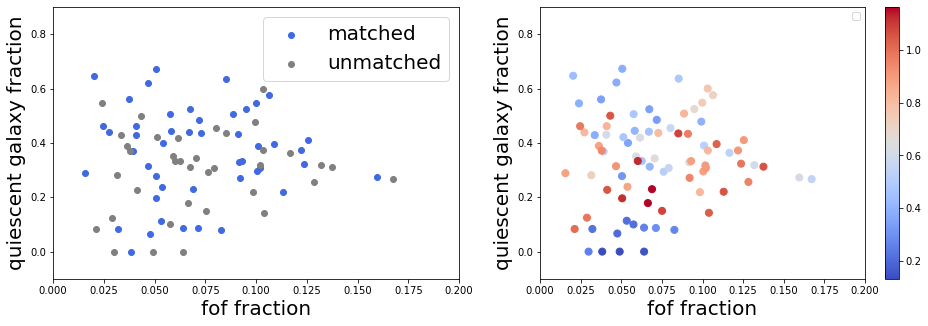

In [73]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].scatter(fofs_new, f_qs_new, color = 'royalblue', label = 'matched')
ax[0].scatter(fofs_non, f_qs_non, color = 'grey', label = 'unmatched')

#z_non, z_cls_non

ax[0].set_xlabel('fof fraction', fontsize = 20)
ax[0].set_ylabel('quiescent galaxy fraction', fontsize = 20)
ax[0].legend(fontsize = 20)

plt0 = ax[1].scatter(fofs_new, f_qs_new, c = z_cls_new, cmap = plt.cm.coolwarm, s = 50)
plt1 = ax[1].scatter(fofs_non, f_qs_non, c = z_non, cmap = plt.cm.coolwarm, s = 50)
plt.colorbar(plt0, ax = ax[1])

#z_non, z_cls_non
ax[1].set_xlabel('fof fraction', fontsize = 20)
ax[1].set_ylabel('quiescent galaxy fraction', fontsize = 20)
ax[1].legend()

ax[0].set_xlim(0, 0.2)
ax[0].set_ylim(-0.1, 0.9)
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(-0.1, 0.9)

plt.savefig('figures/fof-fq.png')


No handles with labels found to put in legend.


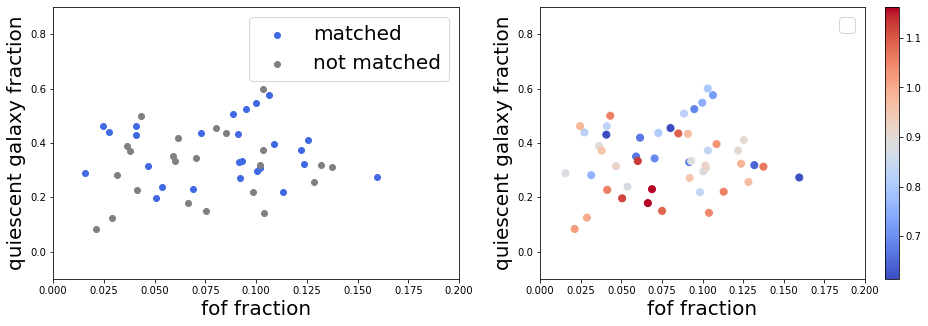

In [75]:
new_z = [i for i in range(len(z_cls_new)) if z_cls_new[i] > 0.6]
non_z = [i for i in range(len(z_non)) if z_non[i] > 0.6]


fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].scatter(np.array(fofs_new)[new_z], np.array(f_qs_new)[new_z], color = 'royalblue', label = 'matched')
ax[0].scatter(np.array(fofs_non)[non_z], np.array(f_qs_non)[non_z], color = 'grey', label = 'not matched')

#z_non, z_cls_non

ax[0].set_xlabel('fof fraction', fontsize = 20)
ax[0].set_ylabel('quiescent galaxy fraction', fontsize = 20)
ax[0].legend(fontsize = 20)

plt0 = ax[1].scatter(np.array(fofs_new)[new_z], np.array(f_qs_new)[new_z], c = np.array(z_cls_new)[new_z], cmap = plt.cm.coolwarm, s = 50)
plt1 = ax[1].scatter(np.array(fofs_non)[non_z], np.array(f_qs_non)[non_z], c = np.array(z_non)[non_z], cmap = plt.cm.coolwarm, s = 50)
plt.colorbar(plt0, ax = ax[1])

#z_non, z_cls_non
ax[1].set_xlabel('fof fraction', fontsize = 20)
ax[1].set_ylabel('quiescent galaxy fraction', fontsize = 20)
ax[1].legend(fontsize = 20)

ax[0].set_xlim(0, 0.2)
ax[0].set_ylim(-0.1, 0.9)
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(-0.1, 0.9)

plt.savefig('figures/fof-fq2.png')


In [16]:
# overall 
overall = [36, 37, 39, 40, 41, 42, 44, 46, 47, 48, 50, 51, 54, 55, 57, 58, 60, 61, 62, 64, 66, 68, 69, 71, 
          71]

In [21]:
fofs_oa = []
f_qs_oa = []

for i, v in enumerate(overall):

    print(i, end = ' ')
    
    ra_cl = ra_cls_oa[i]
    dec_cl = dec_cls_oa[i]
    z_cl = z_cls_oa[i]
    m = m200_oa_list[i]
    
    r200 = find_r200(z_cl, m) #Mpc
    rad = find_radius(z_cl, r200)#Mpc to deg separation
    search = find_radius(z_cl, 10)
    
    #find nearest grid
    z_index = np.argmin((redshifts - z_cl)**2)

    
    f_q, fof = cal_fractions(z_index, members_oa[i])
    
    f_qs_oa.append(f_q)
    fofs_oa.append(fof)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

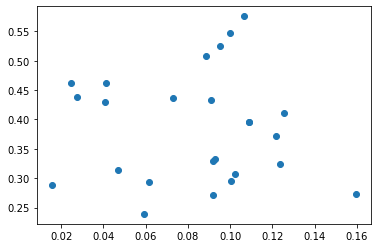

In [22]:
plt.scatter(fofs_oa, f_qs_oa)

## Redshift Distribution

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


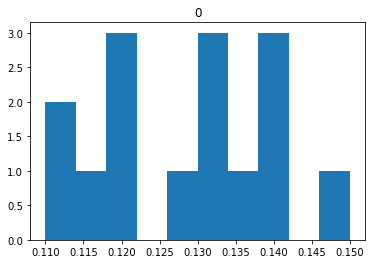

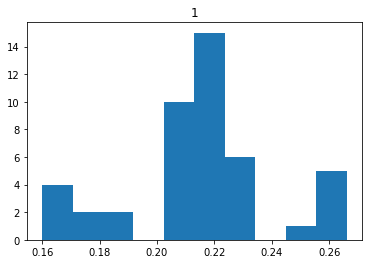

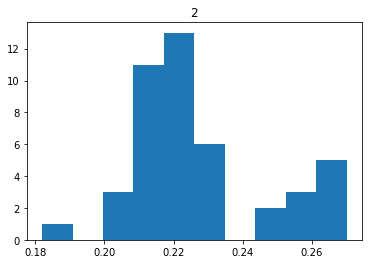

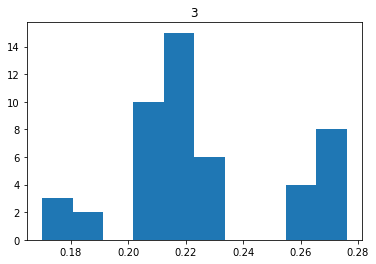

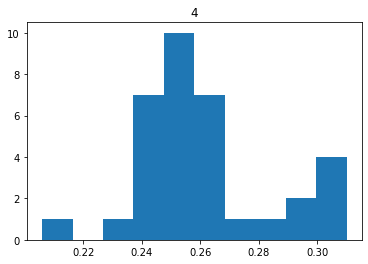

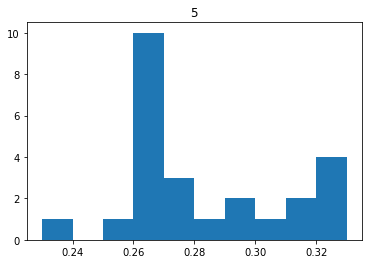

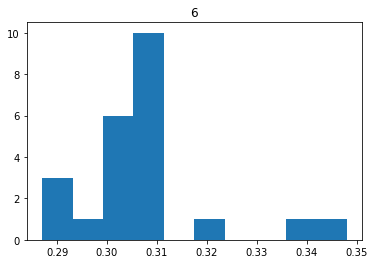

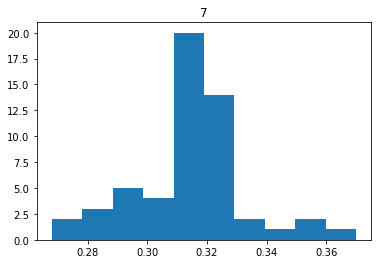

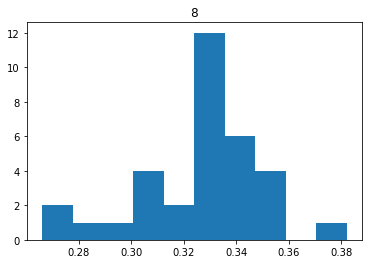

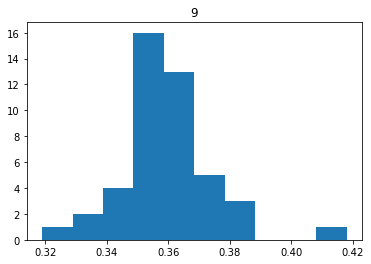

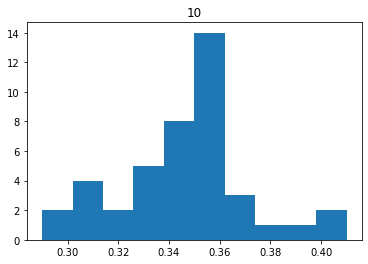

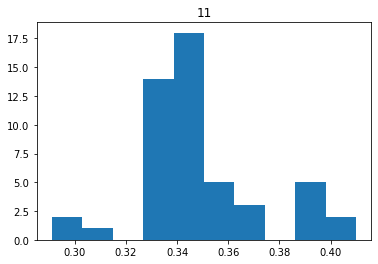

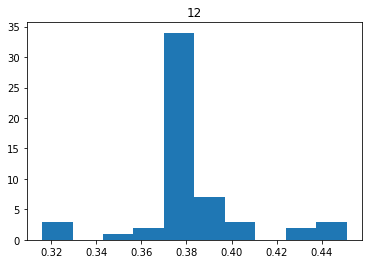

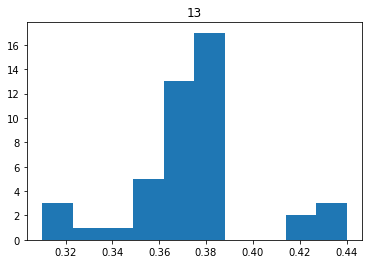

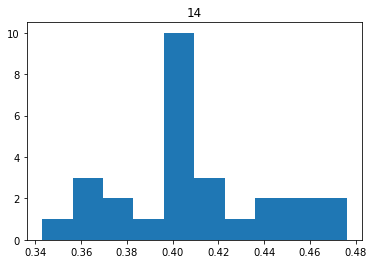

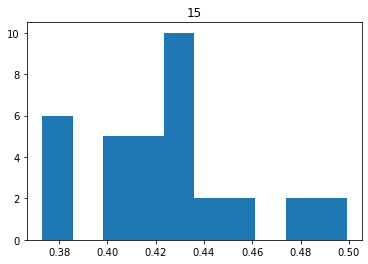

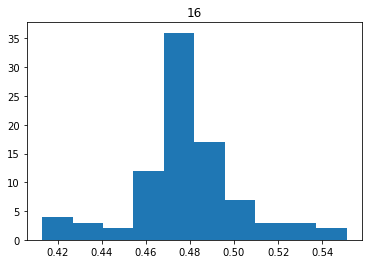

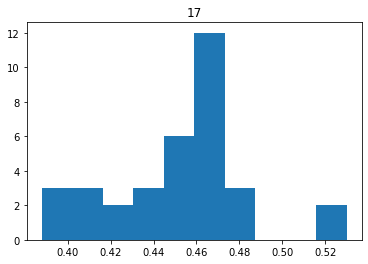

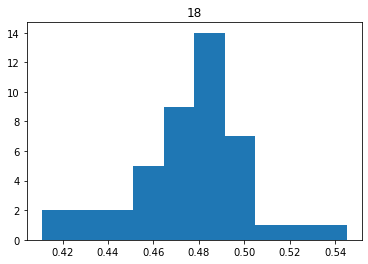

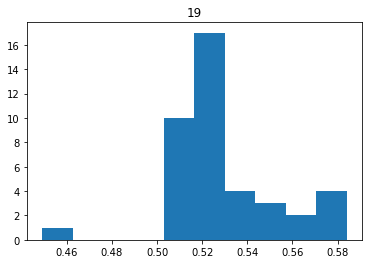

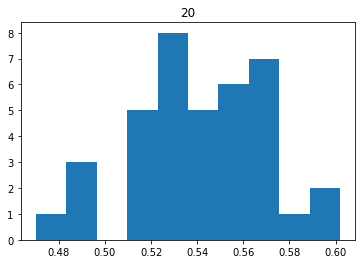

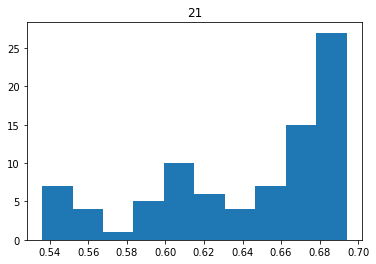

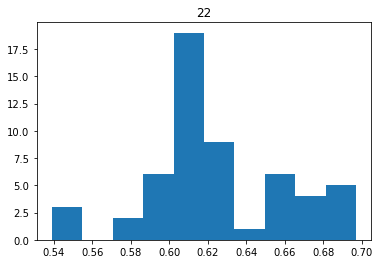

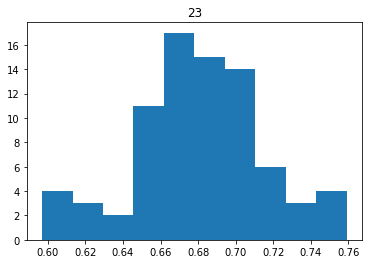

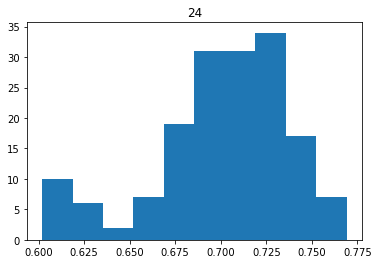

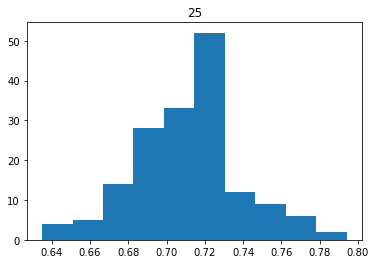

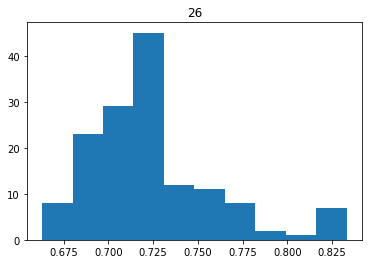

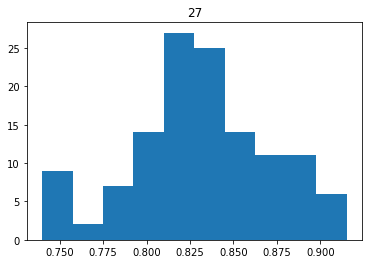

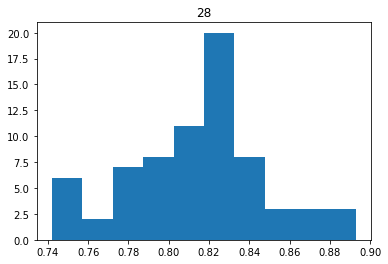

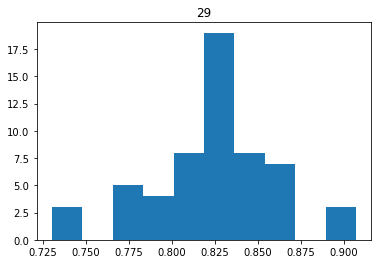

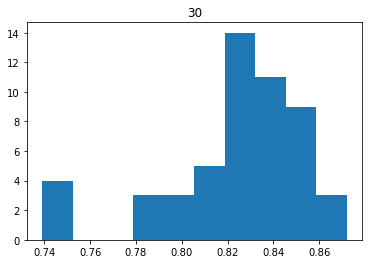

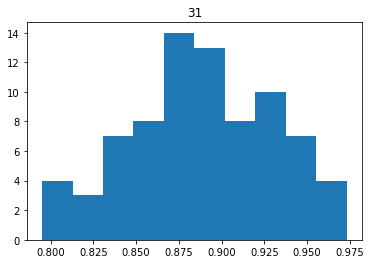

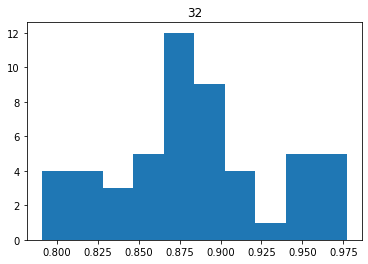

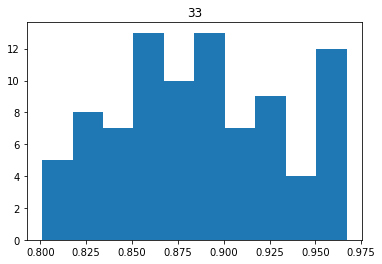

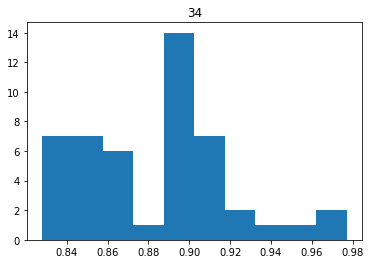

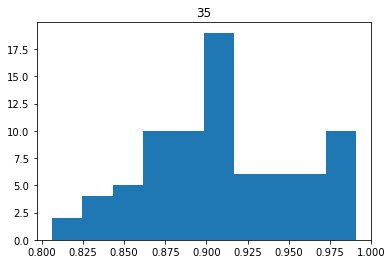

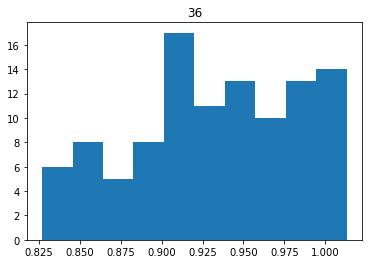

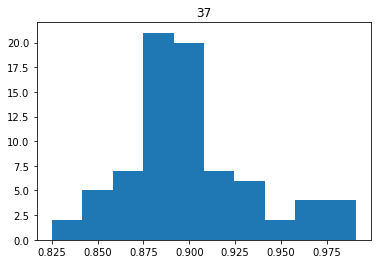

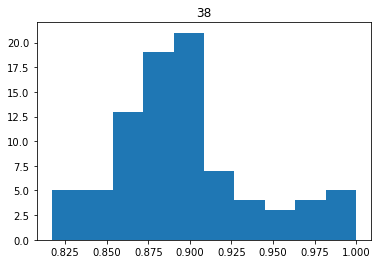

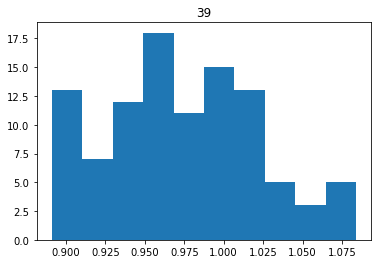

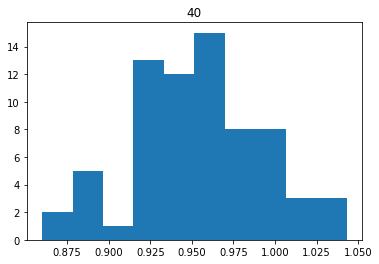

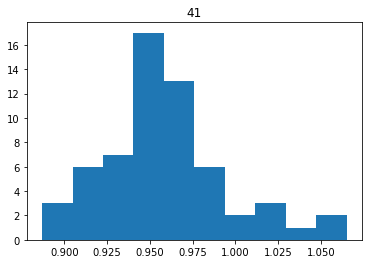

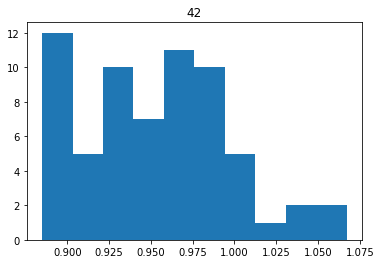

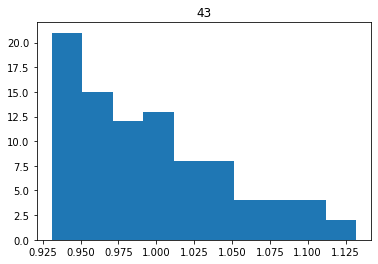

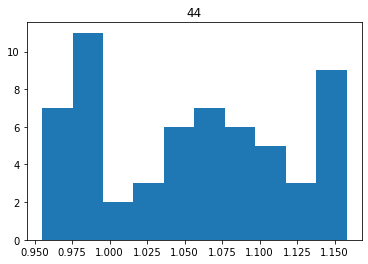

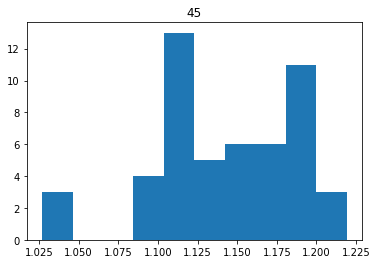

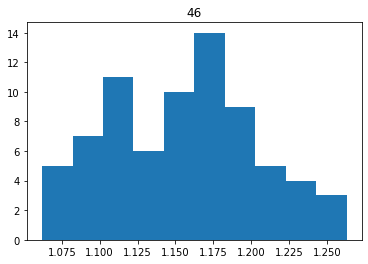

In [83]:
for i, v in enumerate(members_new):
    plt.figure()
    
    tmask = total_pd['Seq'].isin(v)
    samp = total_pd[tmask]
    plt.hist(samp['zphot'])
    
    plt.title(f'{i}')
    
    plt.savefig(f'figures/zdist/zdist{i}.png')

In [39]:
idx_new = [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 37, 38, 40, 41, 45]

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


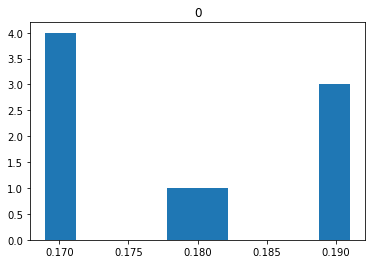

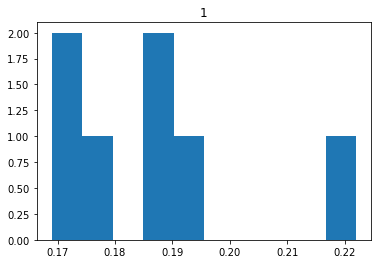

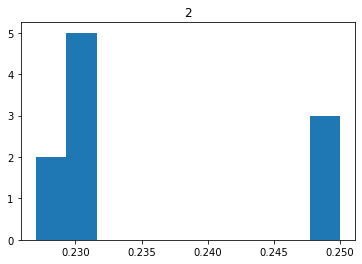

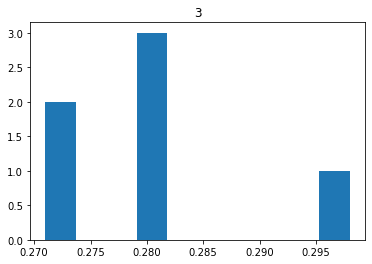

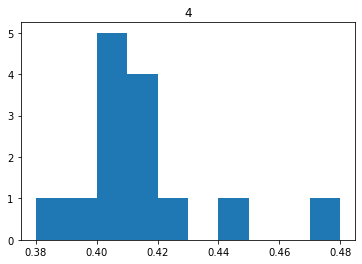

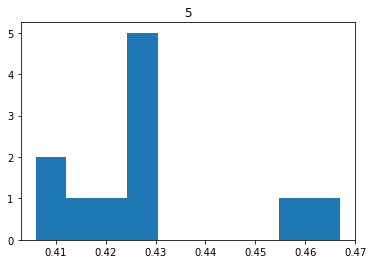

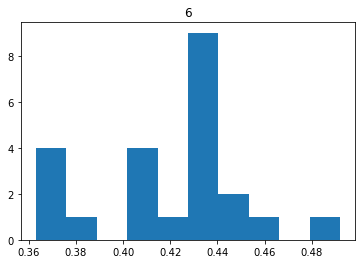

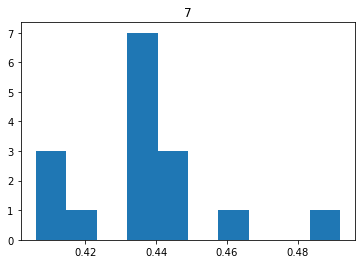

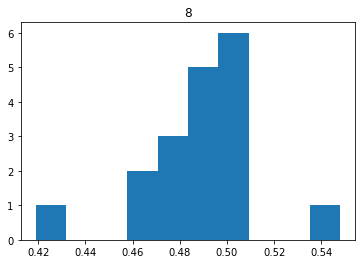

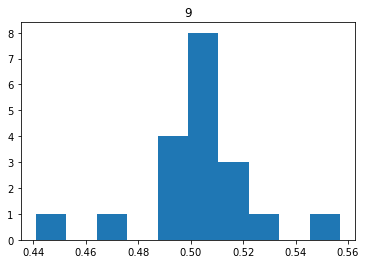

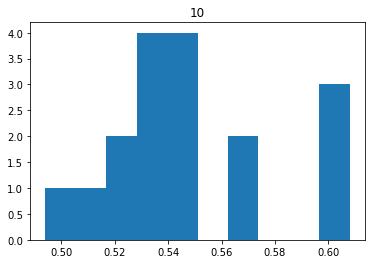

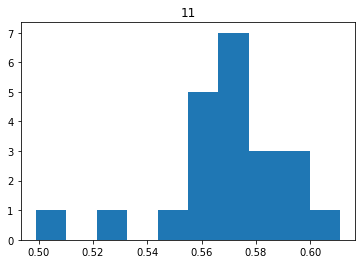

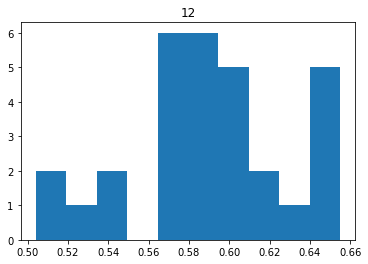

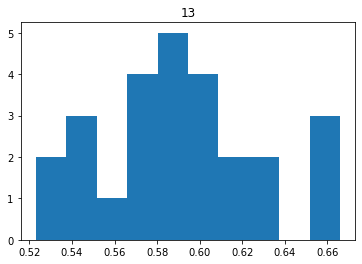

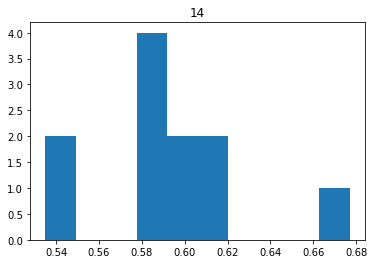

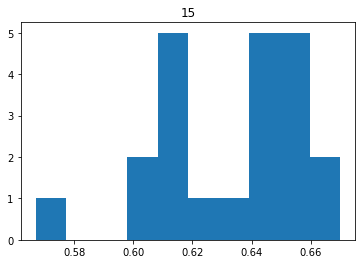

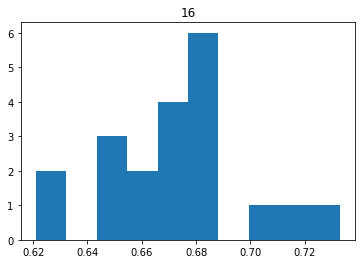

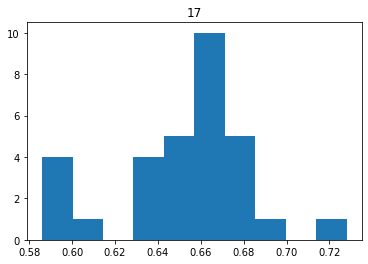

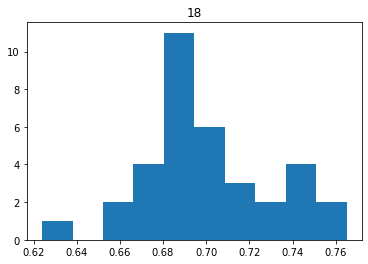

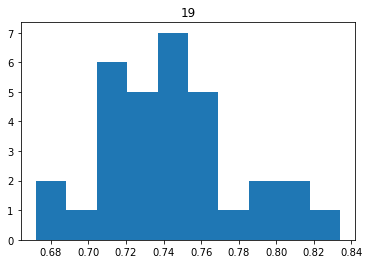

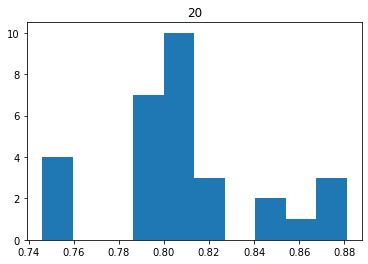

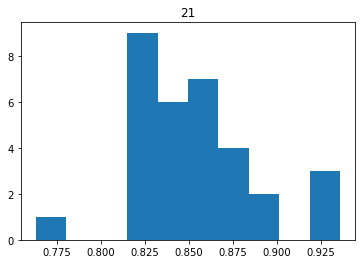

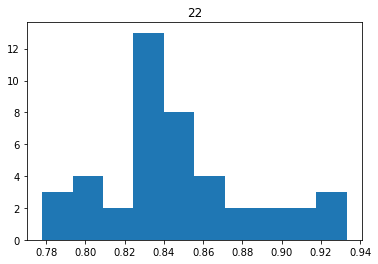

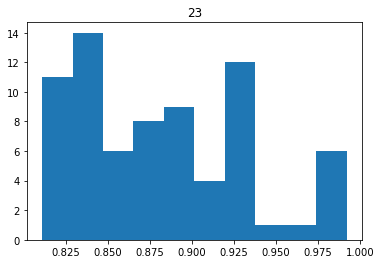

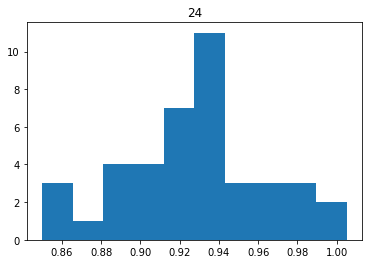

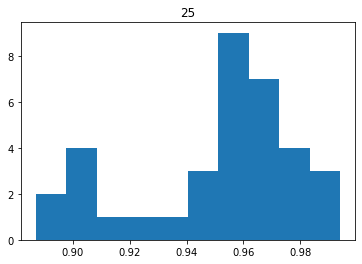

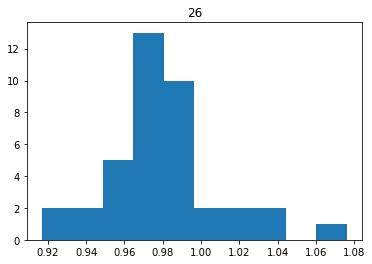

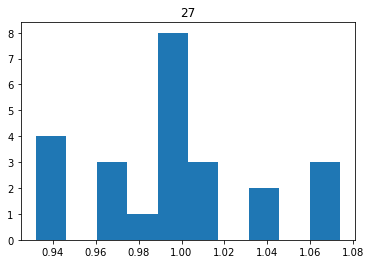

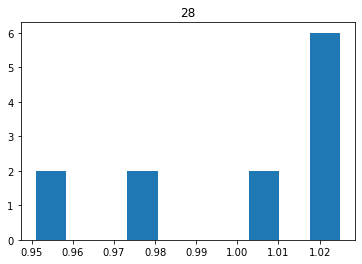

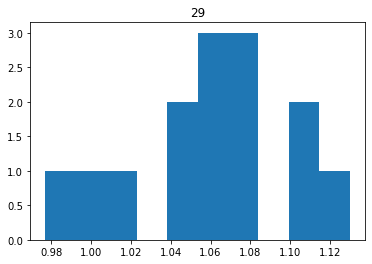

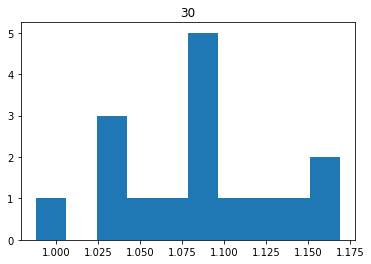

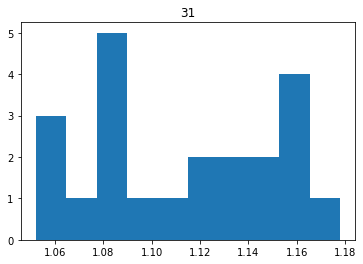

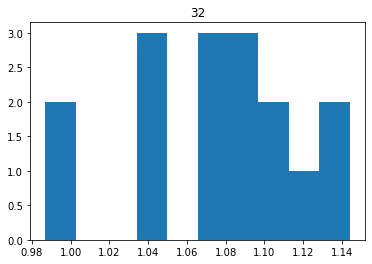

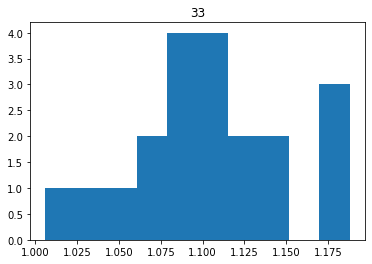

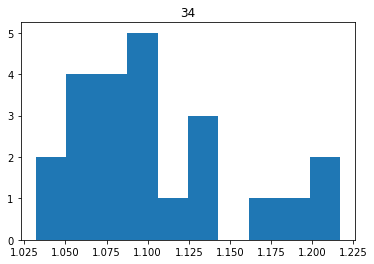

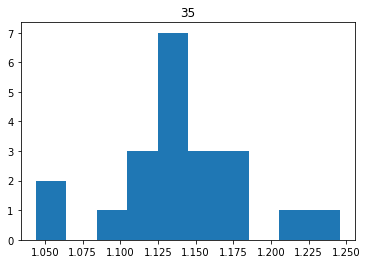

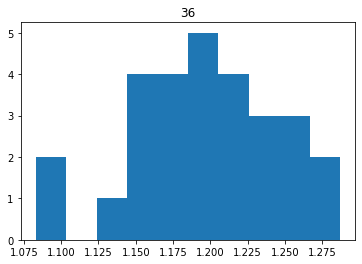

In [40]:
for i, v in enumerate(members_non):
    plt.figure()
    
    tmask = total_pd['Seq'].isin(v)
    samp = total_pd[tmask]
    plt.hist(samp['zphot'])
    
    plt.title(f'{i}')
    


In [41]:
idx_non = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 29, 30, 32, 33, 35, 36]

No handles with labels found to put in legend.


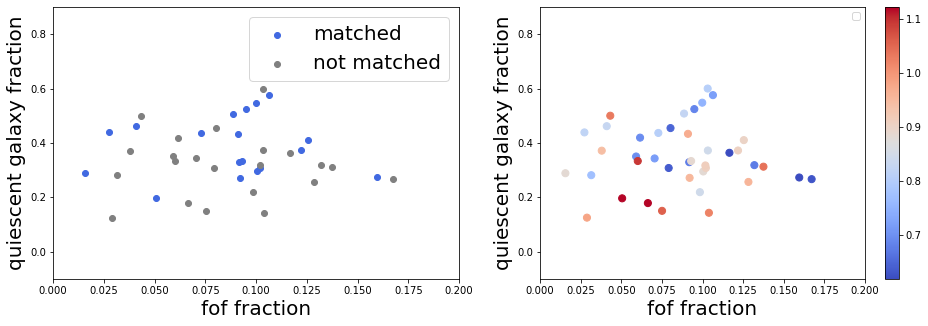

In [76]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].scatter(np.array(fofs_new)[idx_new], np.array(f_qs_new)[idx_new], color = 'royalblue', label = 'matched')
ax[0].scatter(np.array(fofs_non)[idx_non], np.array(f_qs_non)[idx_non], color = 'grey', label = 'not matched')

#z_non, z_cls_non

ax[0].set_xlabel('fof fraction', fontsize = 20)
ax[0].set_ylabel('quiescent galaxy fraction', fontsize = 20)
ax[0].legend(fontsize = 20)

plt0 = ax[1].scatter(np.array(fofs_new)[idx_new], np.array(f_qs_new)[idx_new], c = np.array(z_cls_new)[idx_new], cmap = plt.cm.coolwarm, s = 50)
plt1 = ax[1].scatter(np.array(fofs_non)[idx_non], np.array(f_qs_non)[idx_non], c = np.array(z_non)[idx_non], cmap = plt.cm.coolwarm, s = 50)
plt.colorbar(plt0, ax = ax[1])

#z_non, z_cls_non
ax[1].set_xlabel('fof fraction', fontsize = 20)
ax[1].set_ylabel('quiescent galaxy fraction', fontsize = 20)
ax[1].legend()

ax[0].set_xlim(0, 0.2)
ax[0].set_ylim(-0.1, 0.9)
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(-0.1, 0.9)

plt.savefig('figures/fof-fq3.png')

## Concentration paramter

0 0.030885775595025207 0.07571897160777287 0.4079000934536551 0.16638248623950055
1 0.03458002794887845 0.04855920072822266 0.7121210281531776 0.5071163587379387
2 0.030951146899644615 0.05928572211226078 0.5220674691460604 0.27255444234057274
3 0.03429442592013527 0.05342925844403134 0.6418660284431918 0.41199199846943635
4 0.024834144238158287 0.04844476670981305 0.5126280076218809 0.26278747419837917
5 0.019778141090799777 0.038903760241652936 0.5083863608028304 0.25845669185034564
6 0.010913482372290185 0.03463006075640823 0.3151447653833719 0.09931622314854051
7 0.024767104958885306 0.040304713929641155 0.6144964830198415 0.37760592764375434
8 0.022988494858431366 0.03983587666919185 0.5770801794908191 0.33302153356115605
9 0.02248967774716667 0.04235336079263487 0.5310010191936778 0.2819620823847246
10 0.013663646192804524 0.028654468828143792 0.476841719689614 0.22737802563654838
11 0.01366672868235138 0.03633225538832414 0.37615965582867084 0.1414960866731441
12 0.0249000640699

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


0.014524331280555879 0.034025052799055204 0.42687167500763396 0.18221942692382306
21 0.01798912544839605 0.03282854265153389 0.5479720997470329 0.30027342210117214
22 0.018167064644396033 0.03171616588493134 0.5728014133331097 0.32810145911640803
23 0.012231180728673022 0.02757146068093801 0.44361743725566394 0.19679643063728294
24 0.014531723901632508 0.02701748461887287 0.5378636874093555 0.28929734623358894
25 0.015265444905109888 0.02937640010150948 0.5196499520826409 0.2700360726994909
26 0.013372083728664705 0.026959963694758997 0.4959978388718762 0.24601385616557167
27 0.020127204390313565 0.029577397369111202 0.6804927471858349 0.46307037897252457
28 0.0088789993870819 0.02372981069382944 0.3741706793046917 0.14000369725133446
29 0.0113323548075006 0.02401672517574477 0.47185262455955046 0.22264489930373607
30 0.011447525385518032 0.022511903807117588 0.5085098747578456 0.25858229272623984
31 0.016073278785675684 0.028906189933057595 0.5560497188629491 0.3091912898475647
32 0.0

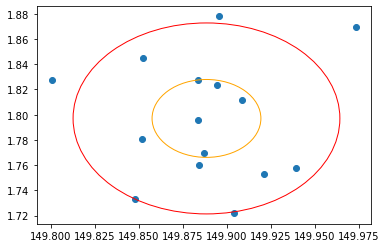

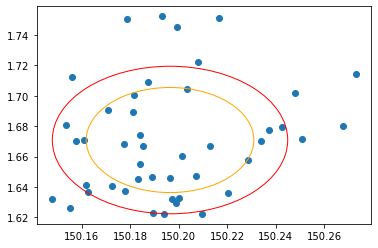

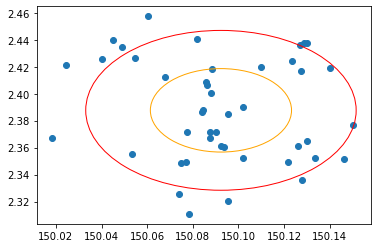

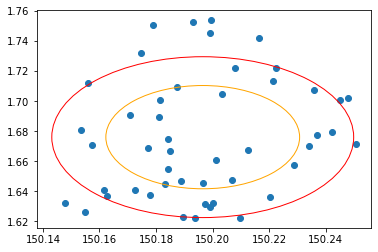

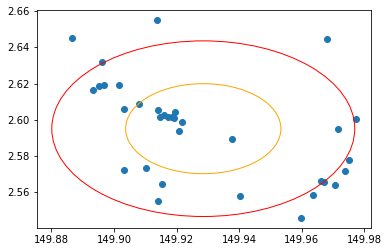

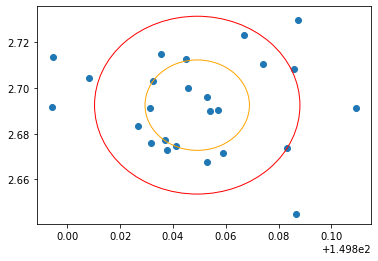

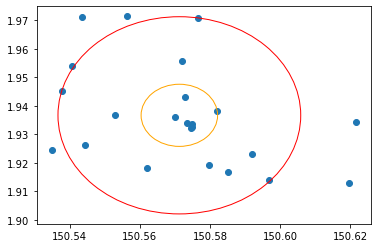

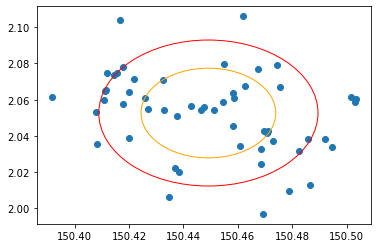

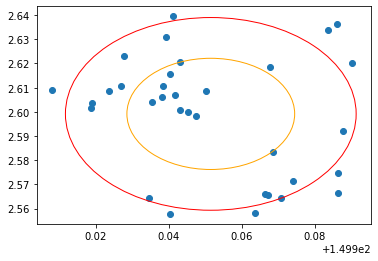

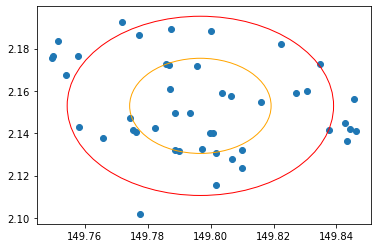

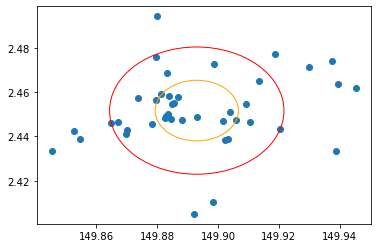

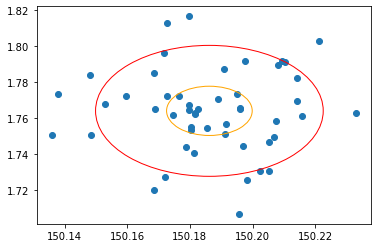

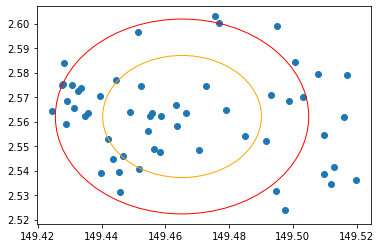

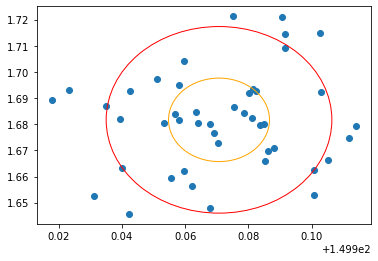

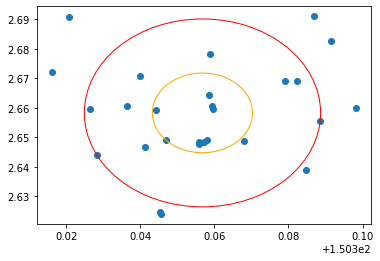

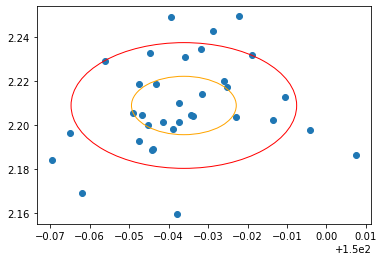

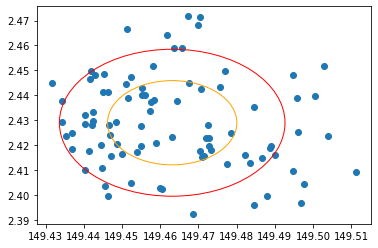

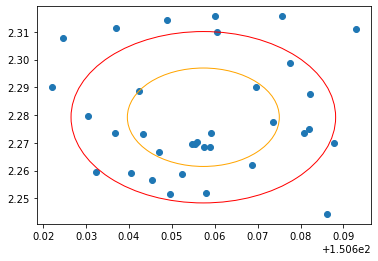

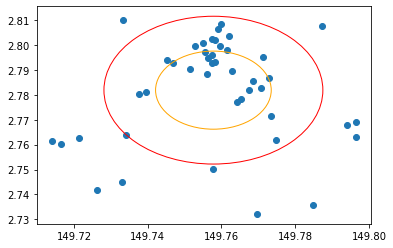

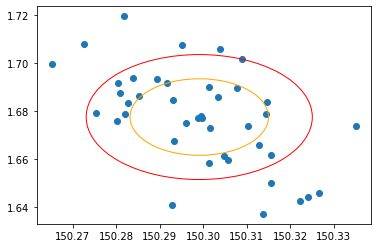

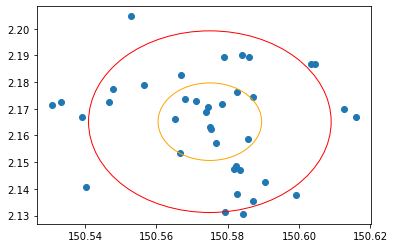

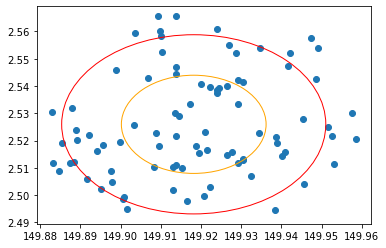

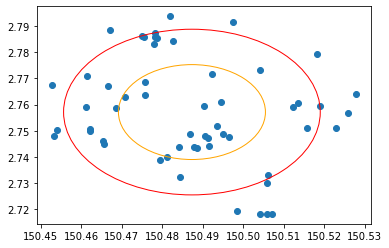

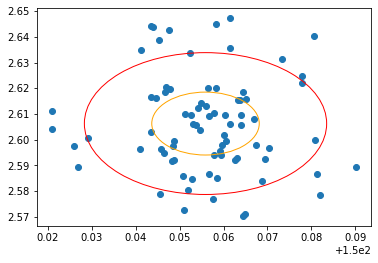

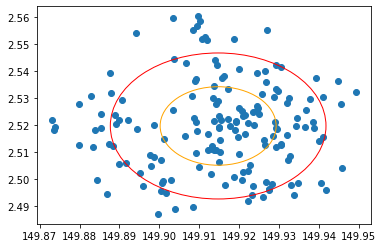

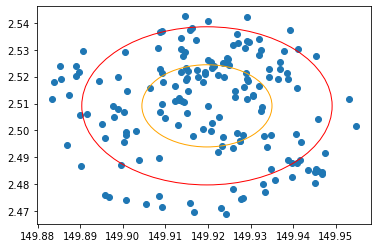

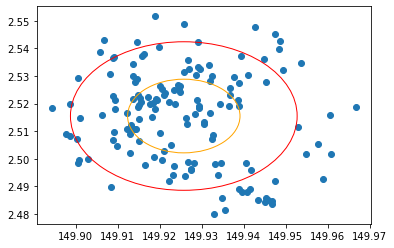

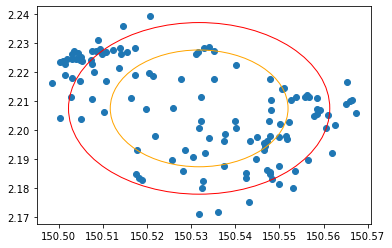

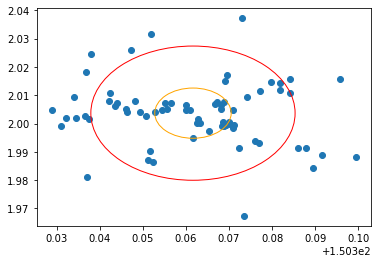

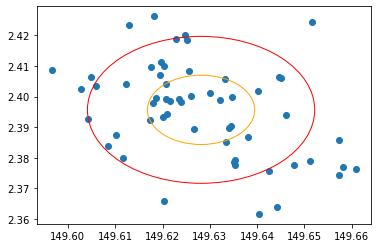

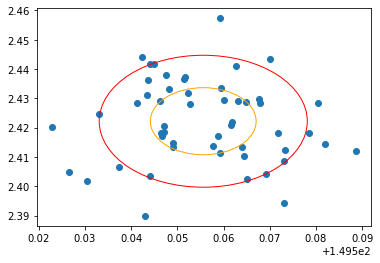

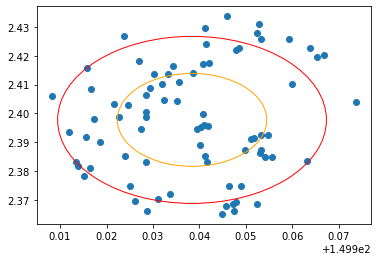

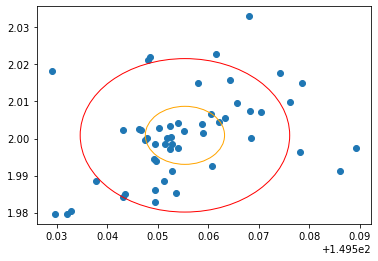

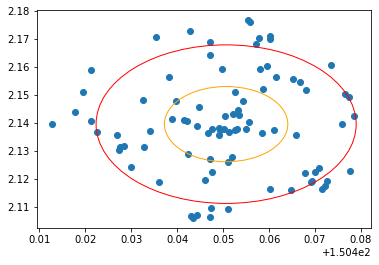

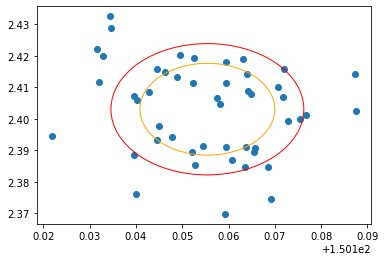

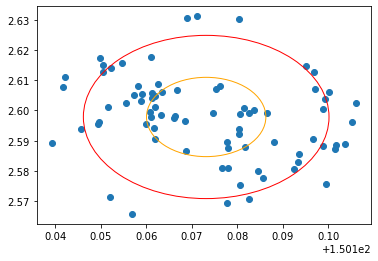

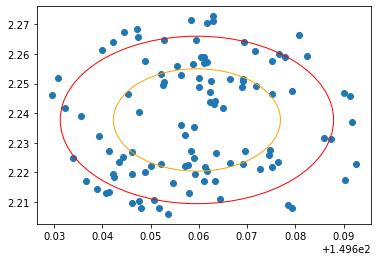

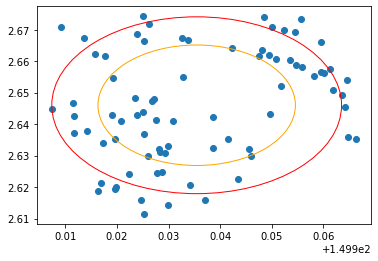

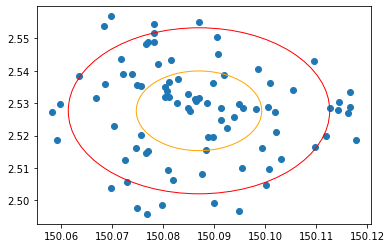

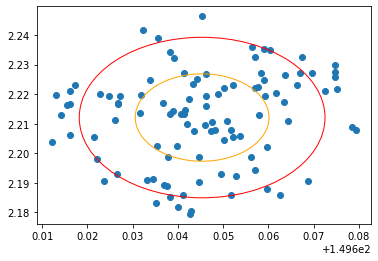

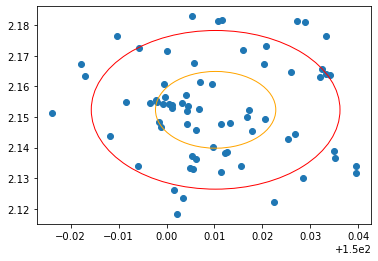

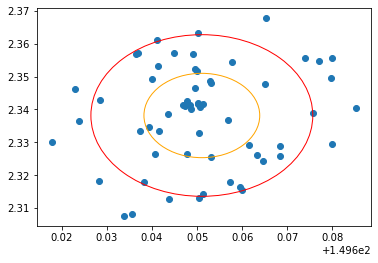

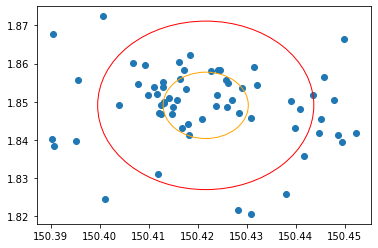

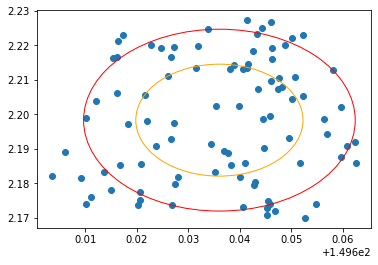

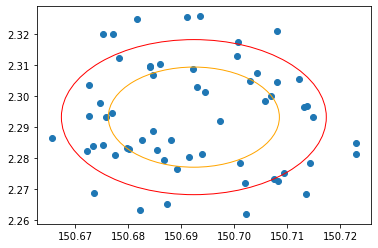

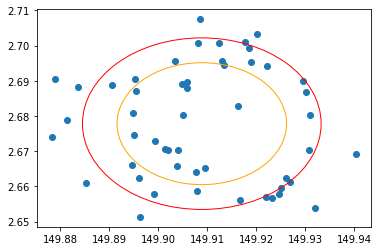

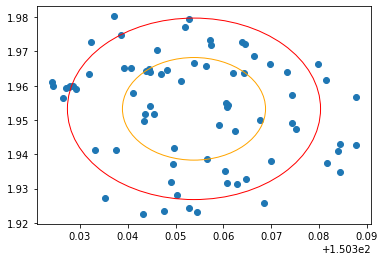

In [78]:
cps_new = []

for i, v in enumerate(js_new):

    print(i, end = ' ')
    fig, ax = plt.subplots()
    
    mems = members_new[i]
    
    mask = total_pd['Seq'].isin(mems)
    samp = total_pd[mask]
    
    
    dist = ((samp['RAJ2000'] - samp['RAJ2000'].mean())**2 + (samp['DEJ2000'] - samp['DEJ2000'].mean())**2)**(1/2)
    dist = dist.values
    dist_idx = np.argsort(dist)
        
    idx_7 = int(len(dist) * 0.7)
    idx_3 = int(len(dist) * 0.3)
    
    d3 = dist[dist_idx[idx_3]]
    d7 = dist[dist_idx[idx_7]]
    print(d3, d7, (d3/d7), (d3/ d7)**2)
    
    cp = -np.log10(d3**2/d7**2)
    
#     cp = cal_concentration(members_new[i])
    
    cps_new.append(cp)

    ax.scatter(samp['RAJ2000'], samp['DEJ2000'])

    circle1 = plt.Circle((samp['RAJ2000'].mean(), samp['DEJ2000'].mean()), d3, fill = False, color = 'orange')
    circle2 = plt.Circle((samp['RAJ2000'].mean(), samp['DEJ2000'].mean()), d7, fill = False, color = 'red')
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    
    
    if i == 19:
        plt.savefig('figures/concentration.png')

0 0.04122055885467341 0.047306669753104685 0.8713477205181654 0.7592468500522029
1 0.02355992645301823 0.03363328267404777 0.7004944085103421 0.490692416354254
2 0.022172411850737497 0.027952828077254296 0.7932081787738527 0.6291792148737323
3 0.007942487245810538 0.01734126288653455 0.45801088985150334 0.20977397522256594
4 0.009716763056220651 0.01597560261501571 0.6082251349371772 0.36993781476934745
5 0.015760531112460827 0.020312133118775614 0.7759170846459502 0.6020473222454706
6 0.017979252097912853 0.028869681090816716 0.6227727989566172 0.38784595912025915
7 0.016764068349188192 0.024870267248689612 0.6740606436415143 0.45435775130641254
8 0.007608073061649321 0.01933893914418701 0.39340694982931323 0.1547690281740038
9 0.015834147818204393 0.019287746779334765 0.8209433688319353 0.6739480148291269
10 0.019581574764901345 0.02125668866845111 0.9211959148634498 0.8486019135611081
11 0.008391036809091989 0.018612701955317817 0.45082314374537086 0.20324150693645932
12 0.013053765

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


0.011163474813377308 0.016309498776353112 0.6844768785637395 0.4685085972883602
21 0.014854349075643992 0.02052853697175796 0.7235951152329947 0.5235898907890508
22 0.01348934656702348 0.017947819274776955 0.7515869399231577 0.5648829282630563
23 0.00974500911276119 0.016973322289719407 0.5741368098962957 0.32963307647789514
24 0.010601930806224813 0.01861742160826866 0.5694628949862809 0.324287988766156
25 0.009379122071778954 0.013247037575464546 0.7080165673531766 0.5012874596465753
26 0.0096659148544086 0.01599561028548638 0.6042854684437373 0.3651609273722671
27 0.013511461353808232 0.016461885901144013 0.8207723850685453 0.6736673080911084
28 0.007743574232335692 0.012091696622245981 0.6404042769390418 0.41011763792181694
29 0.006946326831299524 0.009143428378580636 0.7597070315082213 0.5771547737230335
30 0.004570080981055494 0.014172640010849226 0.3224579878947799 0.10397915395715003
31 0.009074293588851881 0.013384100883926942 0.6779905252917857 0.45967115238543155
32 0.005572

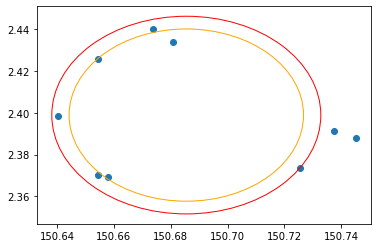

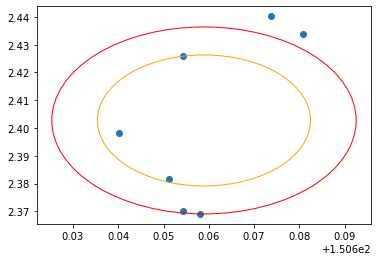

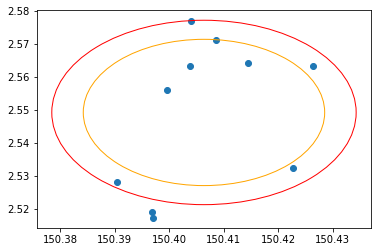

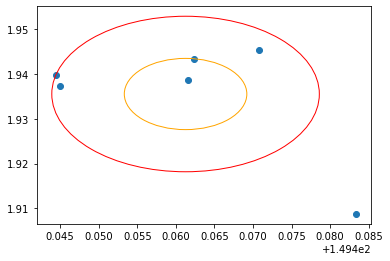

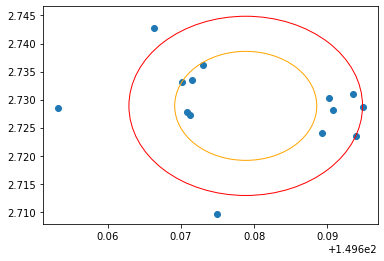

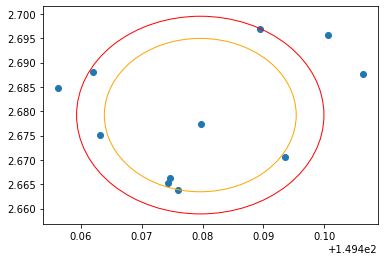

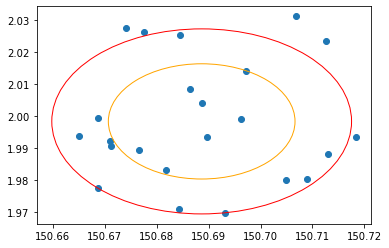

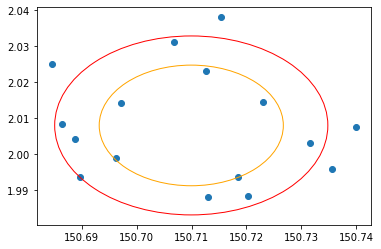

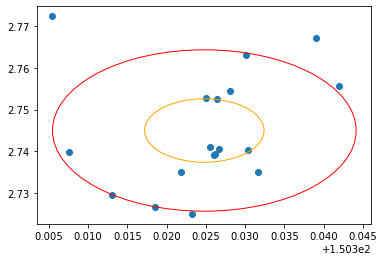

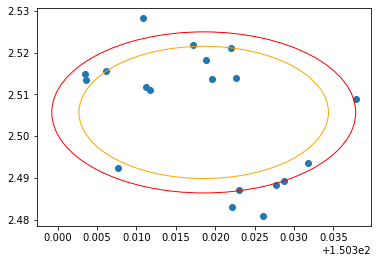

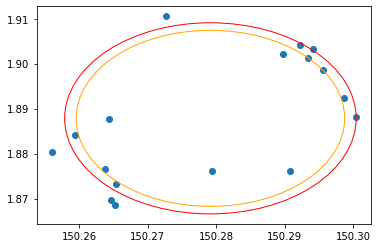

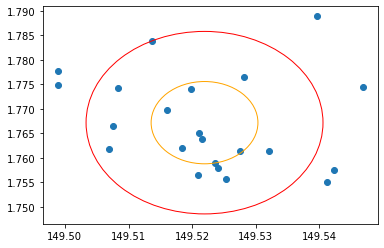

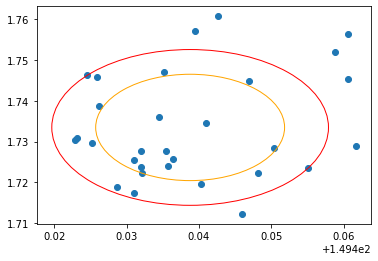

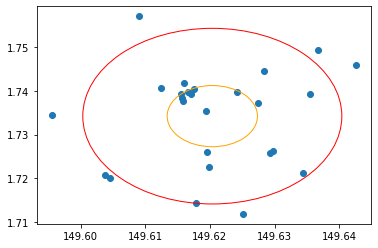

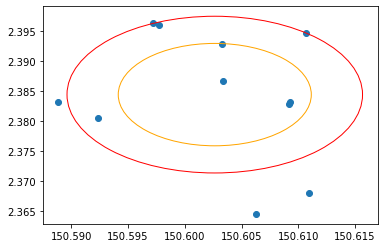

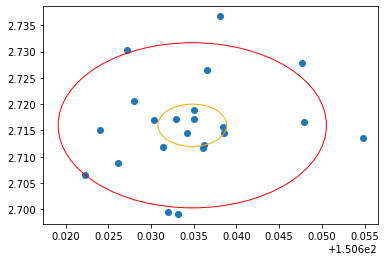

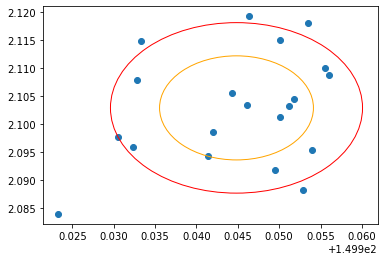

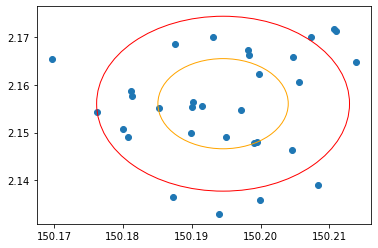

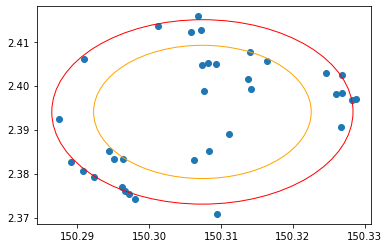

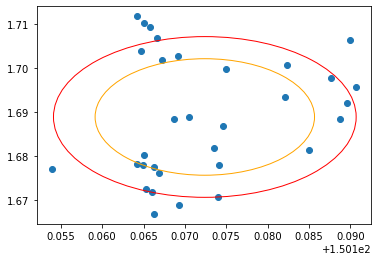

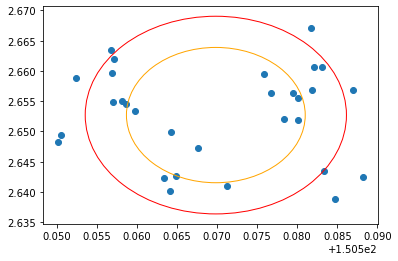

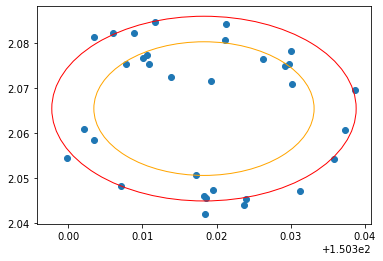

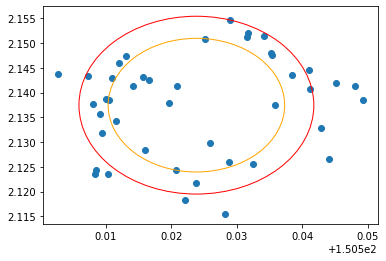

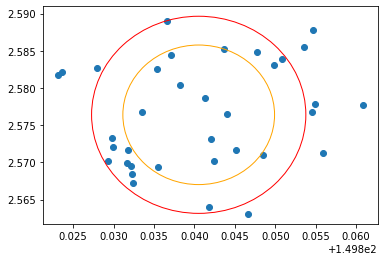

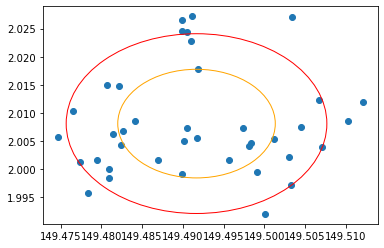

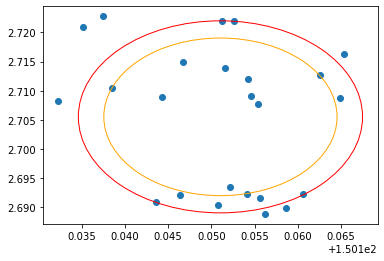

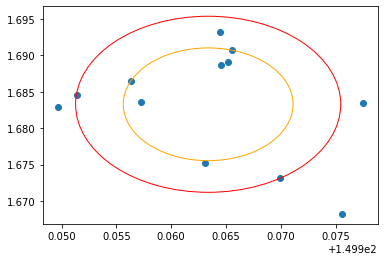

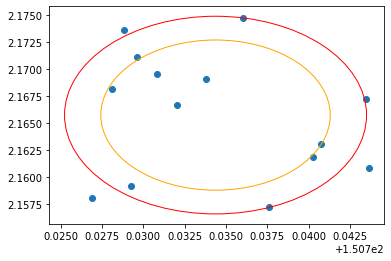

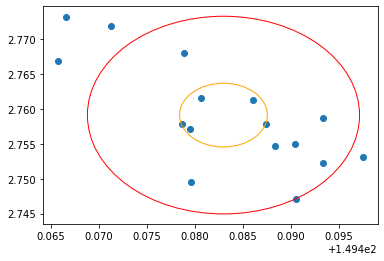

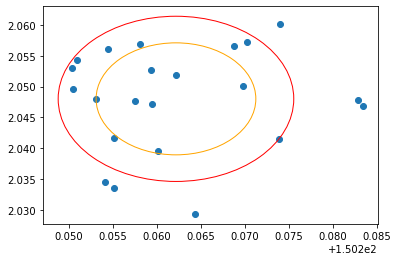

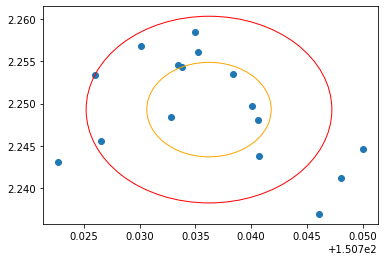

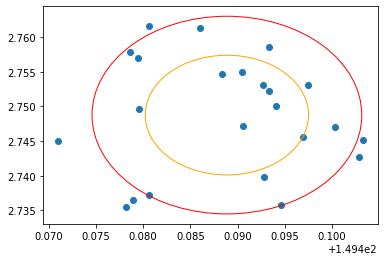

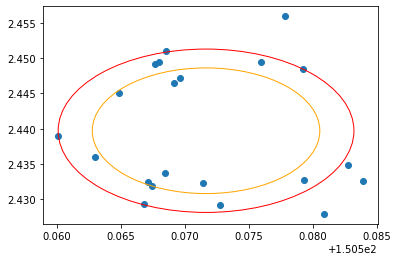

In [44]:
cps_non = []

for i, v in enumerate(nons):

    print(i, end = ' ')
    fig, ax = plt.subplots()
    
    mems = members_non[i]
    
    mask = total_pd['Seq'].isin(mems)
    samp = total_pd[mask]
    
    
    dist = ((samp['RAJ2000'] - samp['RAJ2000'].mean())**2 + (samp['DEJ2000'] - samp['DEJ2000'].mean())**2)**(1/2)
    dist = dist.values
    dist_idx = np.argsort(dist)
        
    idx_7 = int(len(dist) * 0.7)
    idx_3 = int(len(dist) * 0.3)
    
    d3 = dist[dist_idx[idx_3]]
    d7 = dist[dist_idx[idx_7]]
    print(d3, d7, (d3/d7), (d3/ d7)**2)
    
    cp = -np.log10(d3**2/d7**2)
    
#     cp = cal_concentration(members_new[i])
    
    cps_non.append(cp)

    ax.scatter(samp['RAJ2000'], samp['DEJ2000'])

    circle1 = plt.Circle((samp['RAJ2000'].mean(), samp['DEJ2000'].mean()), d3, fill = False, color = 'orange')
    circle2 = plt.Circle((samp['RAJ2000'].mean(), samp['DEJ2000'].mean()), d7, fill = False, color = 'red')
    ax.add_patch(circle1)
    ax.add_patch(circle2)

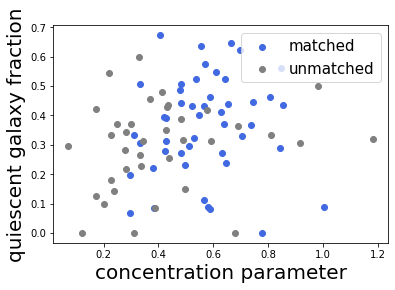

In [81]:
# cps
plt.scatter(cps_new, f_qs_new, color = 'royalblue', label = 'matched')
plt.scatter(cps_non, f_qs_non, color = 'grey', label = 'unmatched')
plt.legend(fontsize = 15)
plt.xlabel('concentration parameter', fontsize = 20)
plt.ylabel('quiescent galaxy fraction', fontsize = 20)

plt.savefig('figures/concentration2.png')

## quiescent galaxy distribution

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 

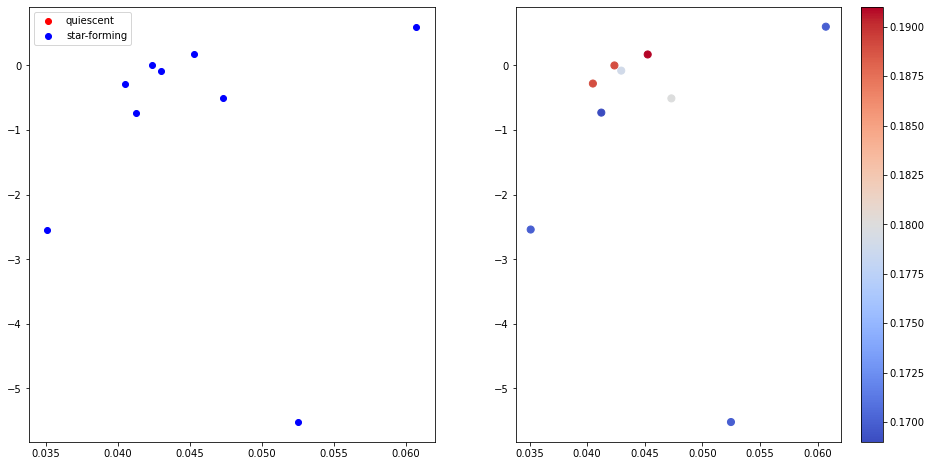

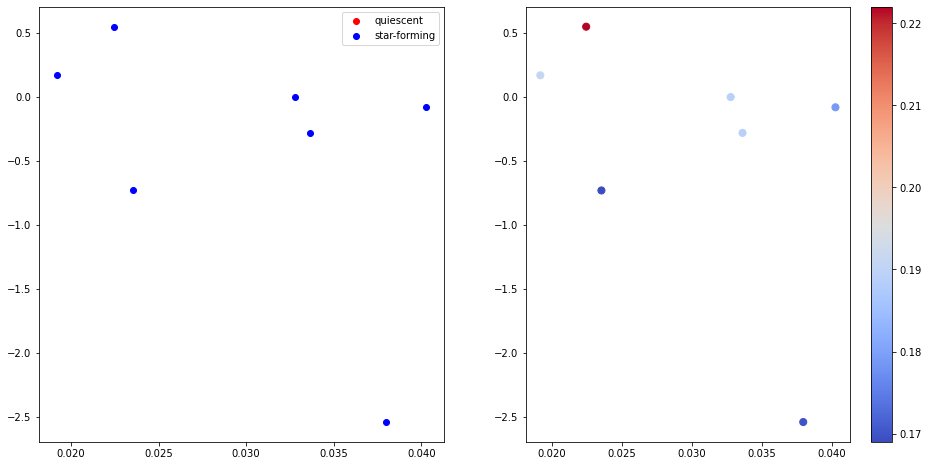

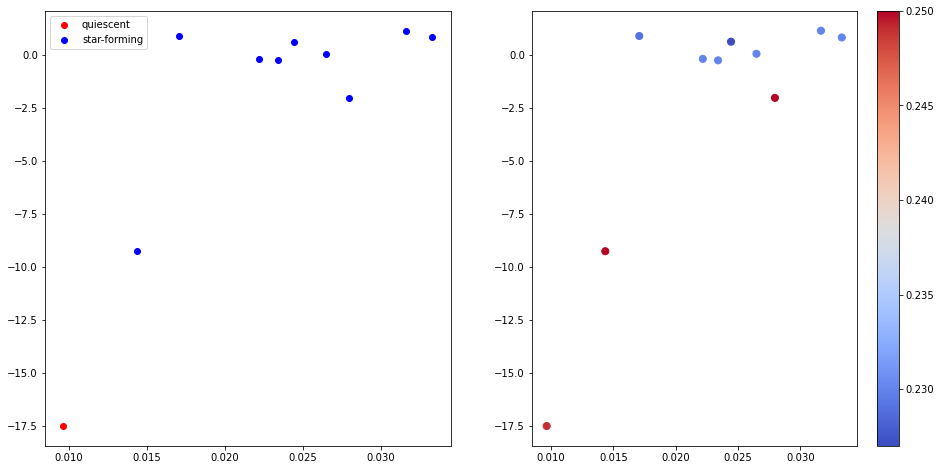

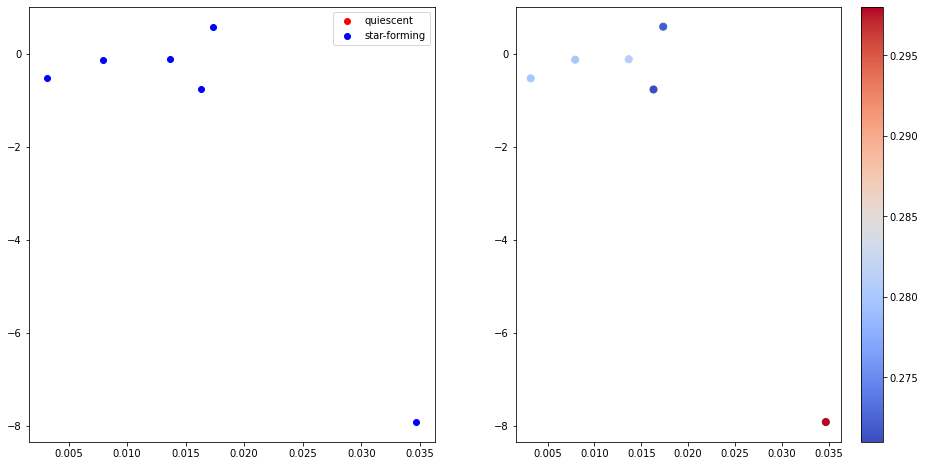

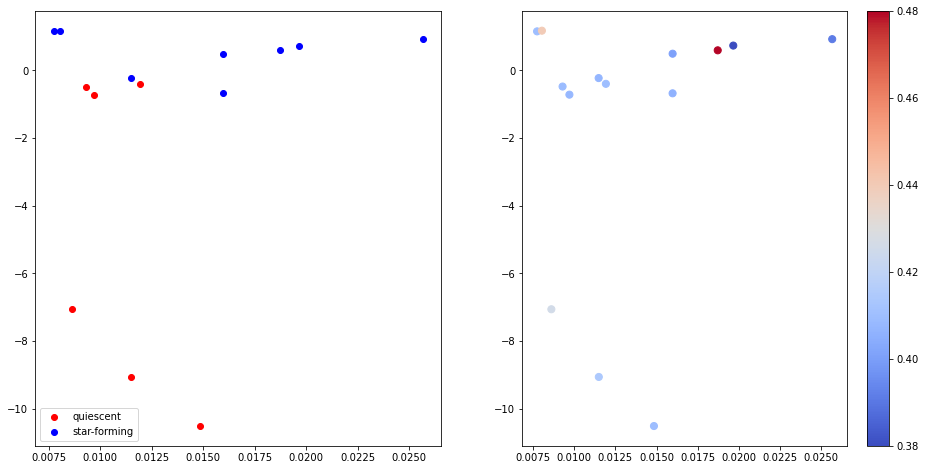

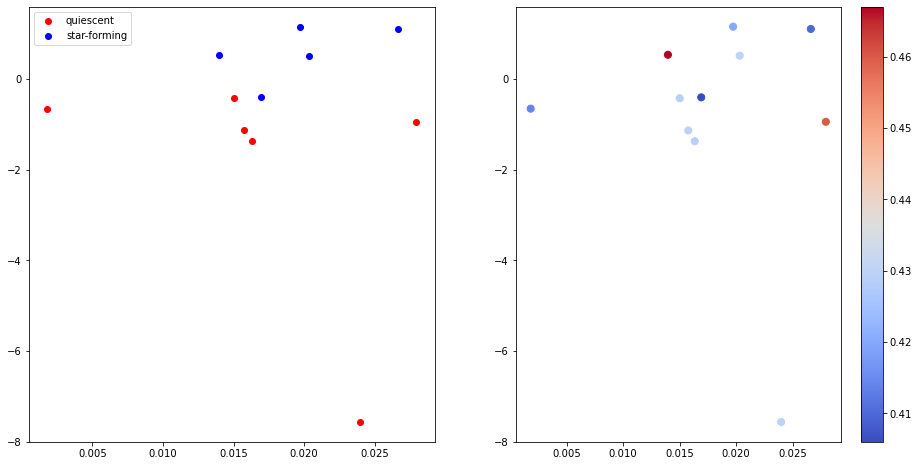

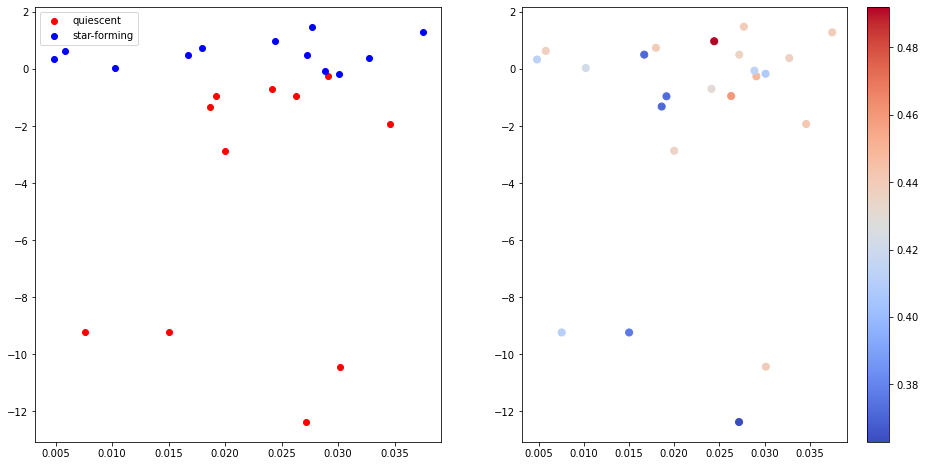

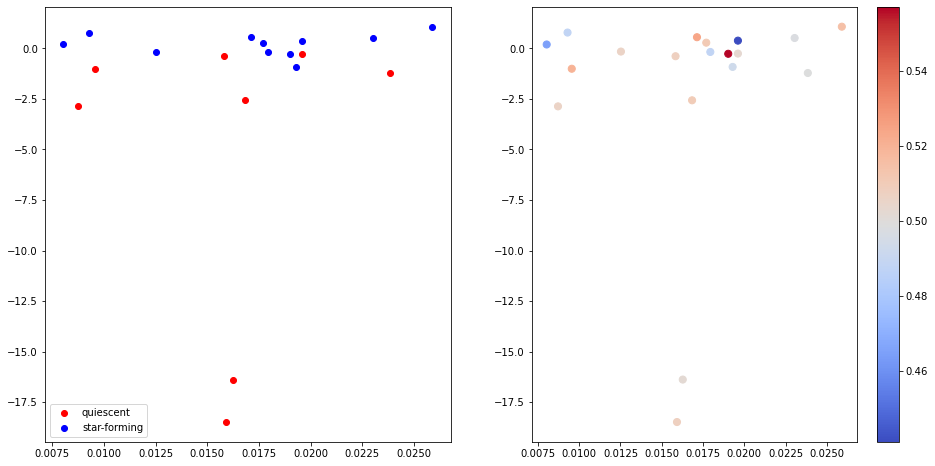

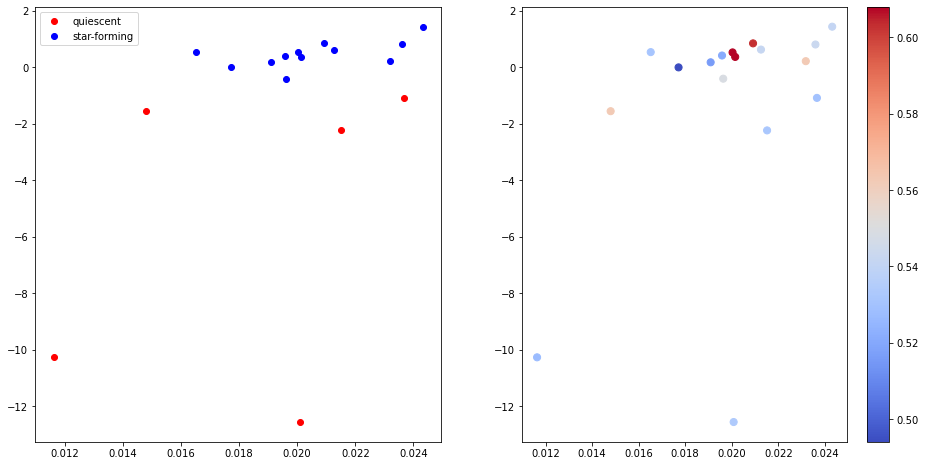

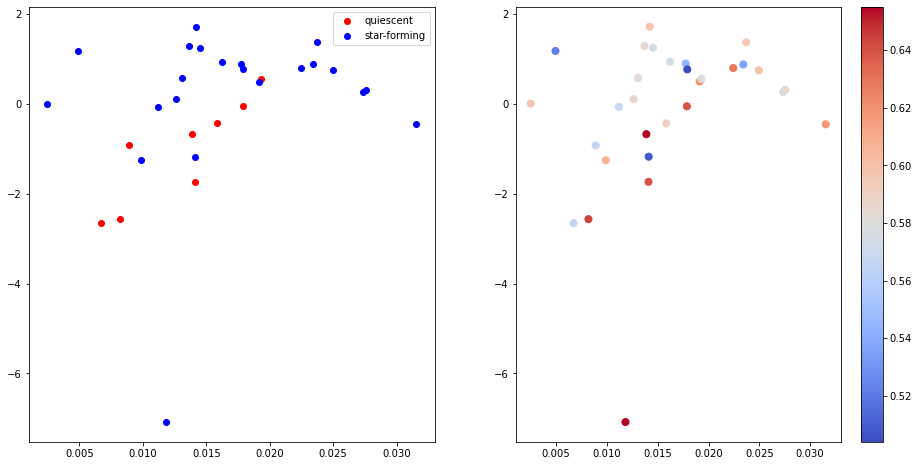

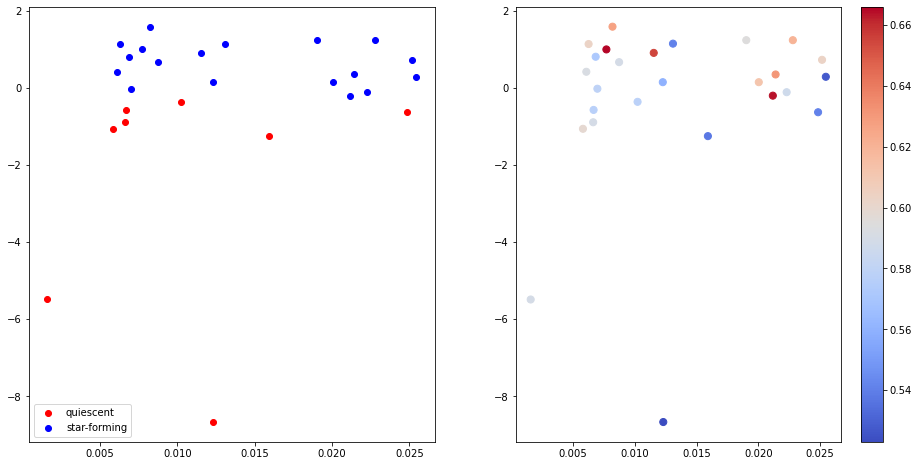

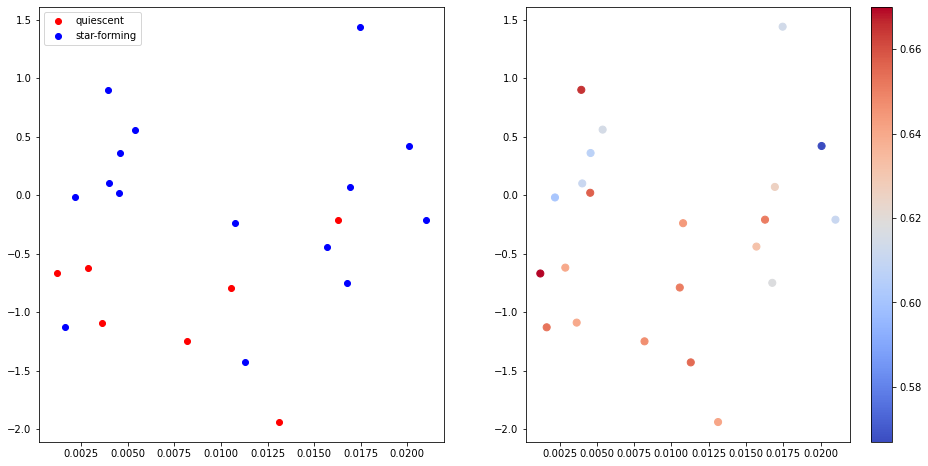

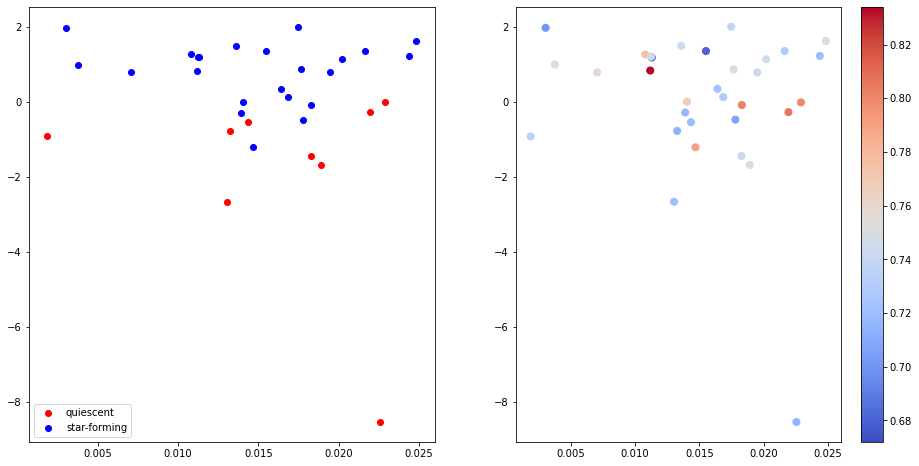

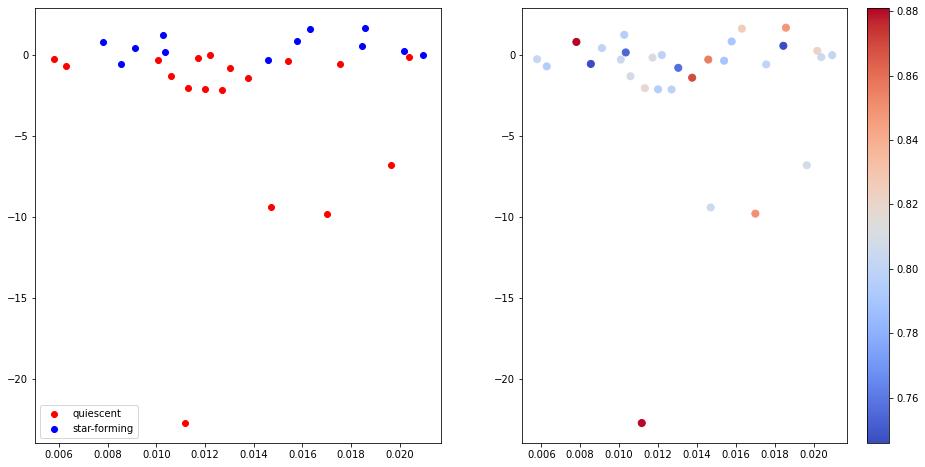

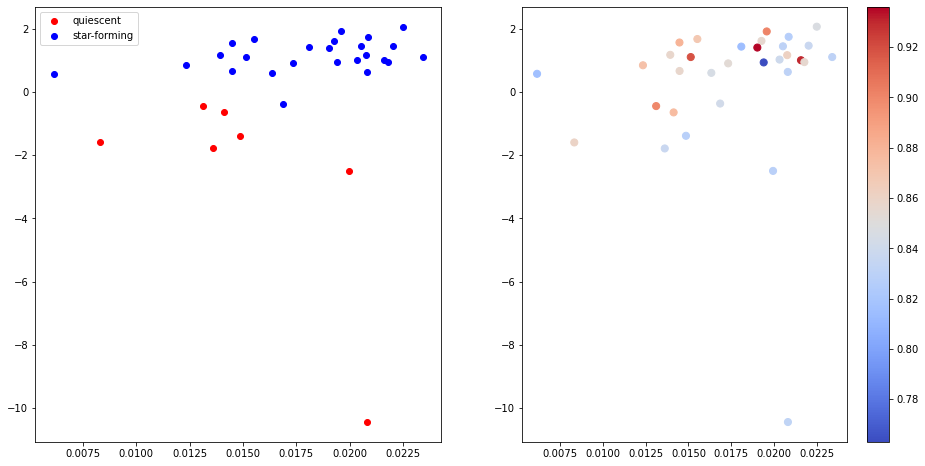

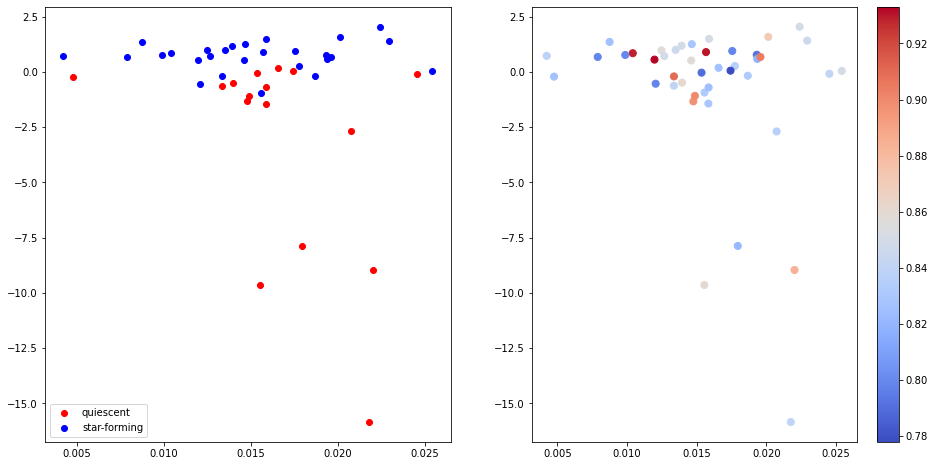

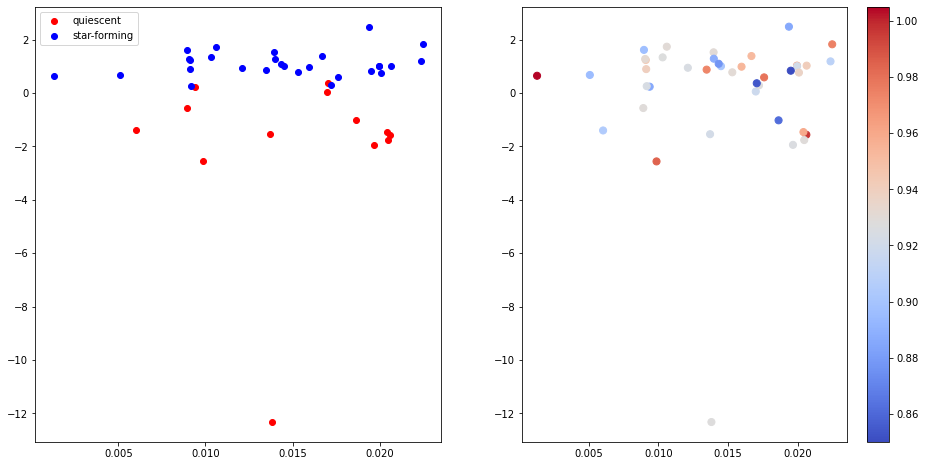

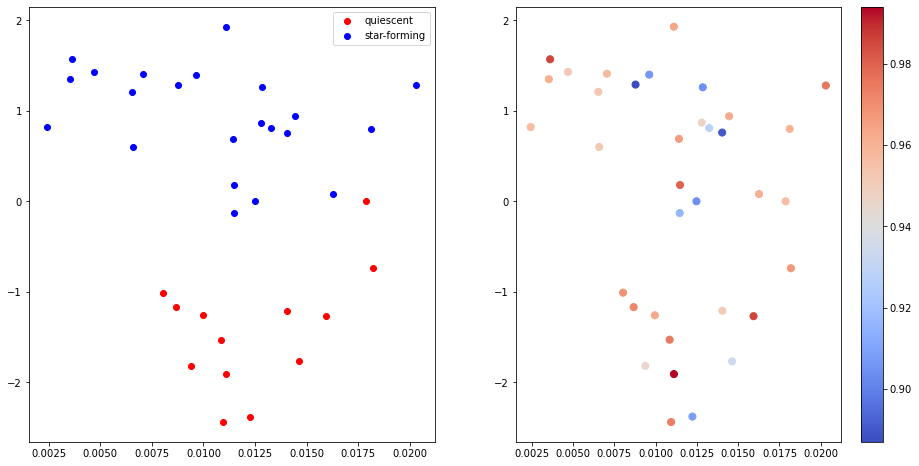

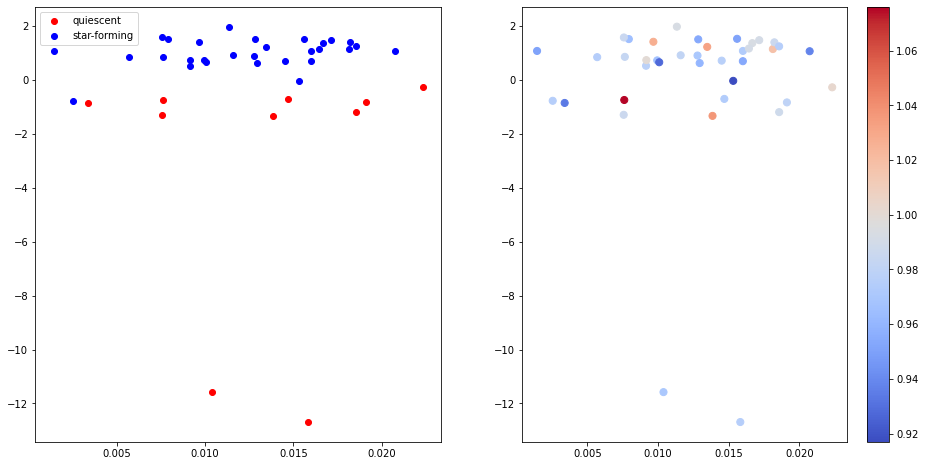

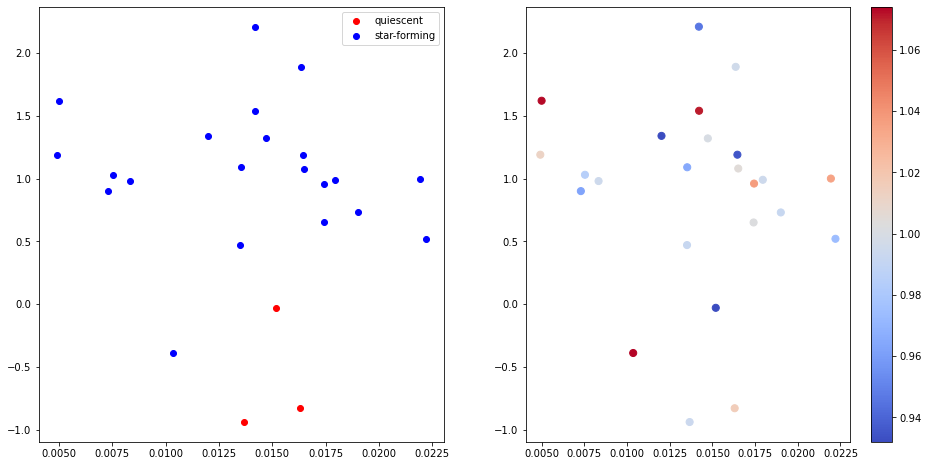

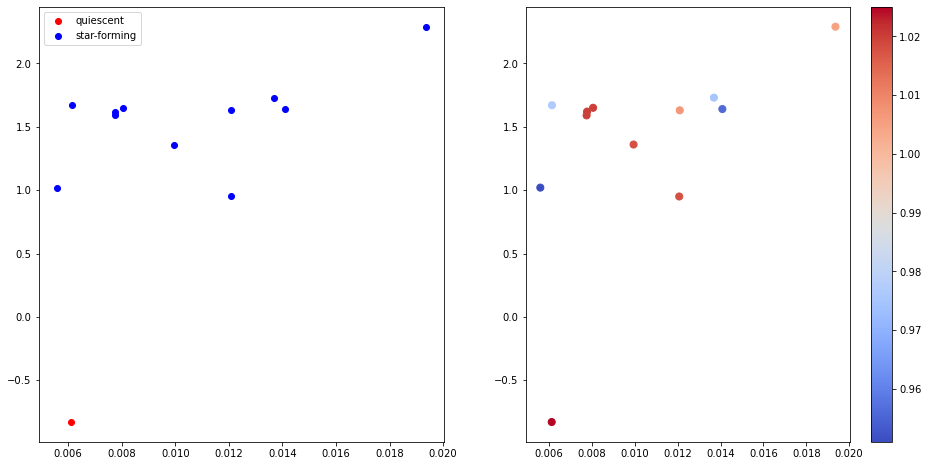

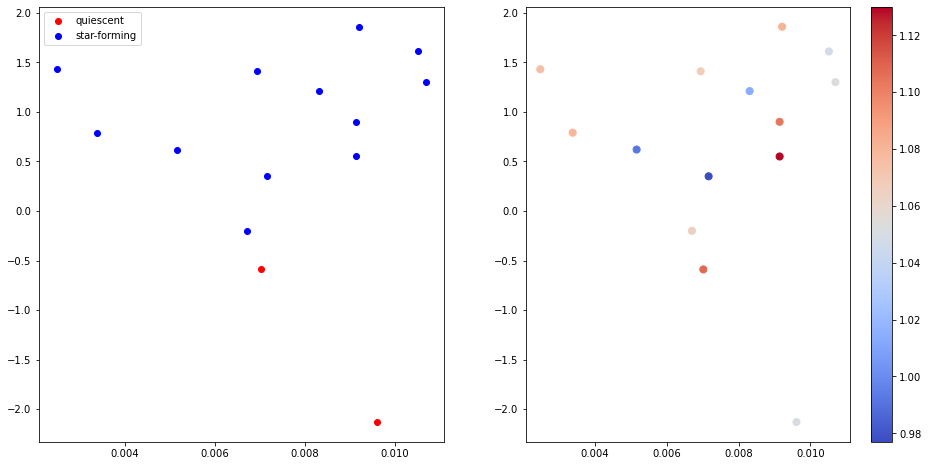

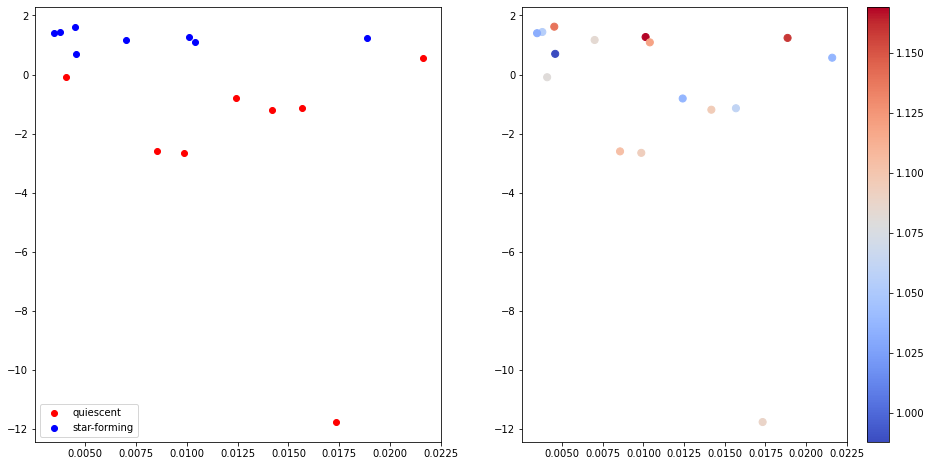

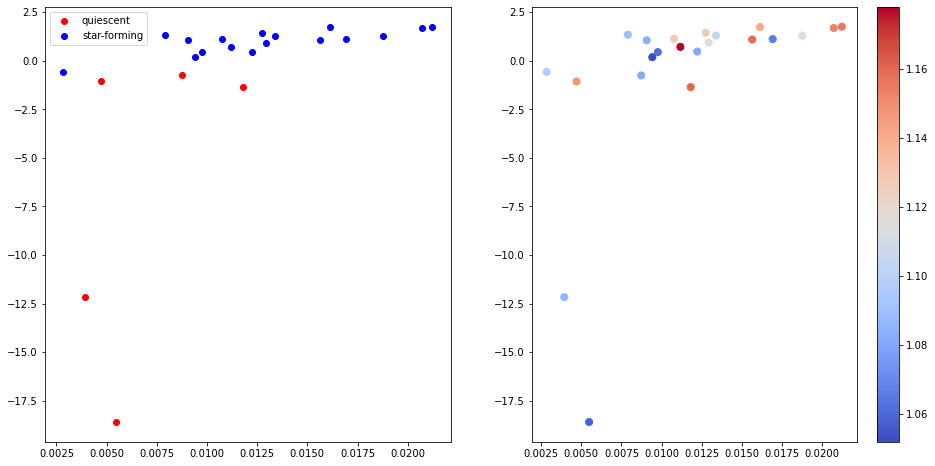

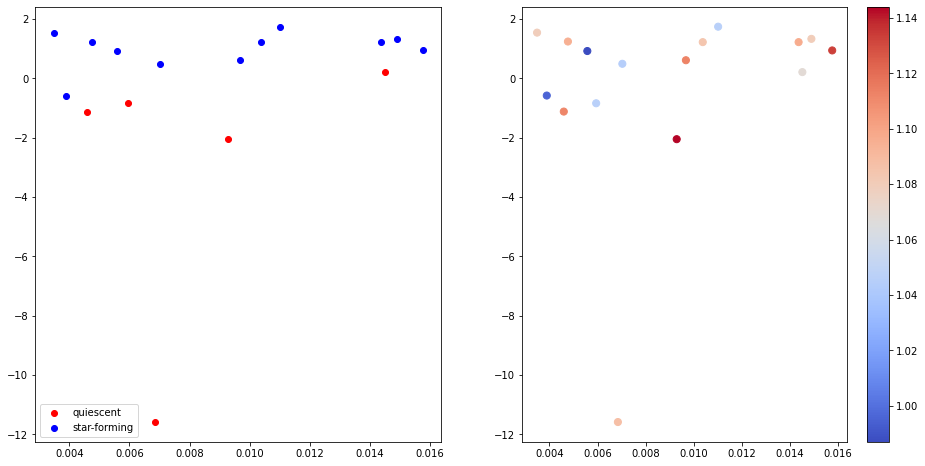

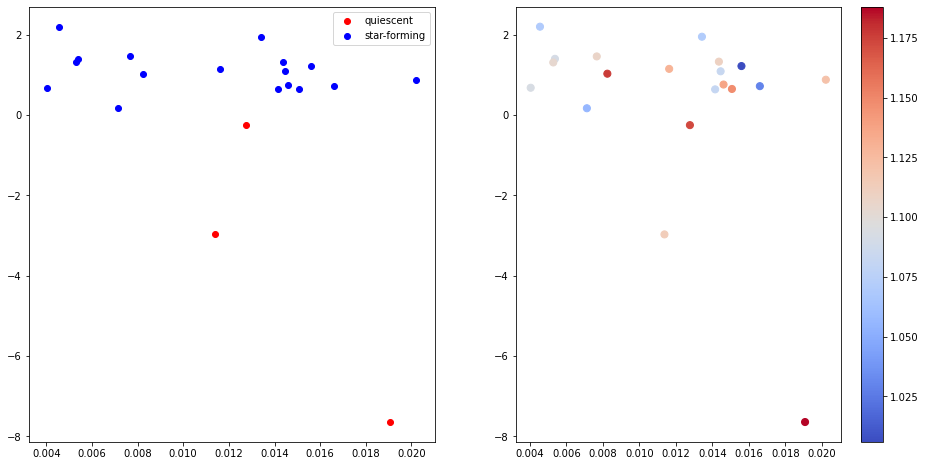

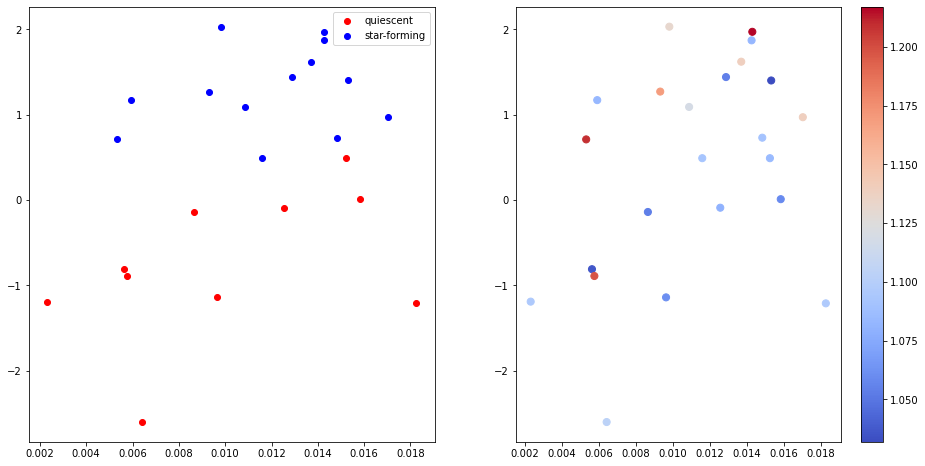

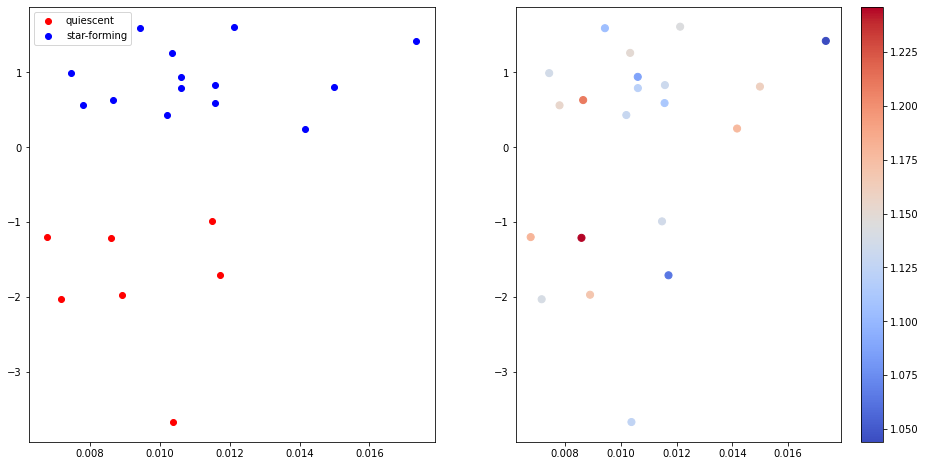

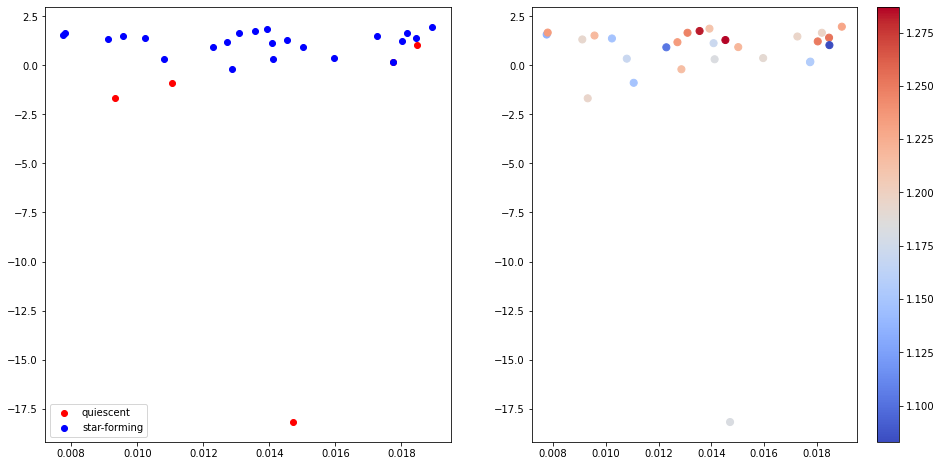

In [50]:
for i, v in enumerate(nons):

    print(i, end = ' ')
    fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    
    mems = members_non[i]
    
    mask = total_pd['Seq'].isin(mems)
    samp = total_pd[mask]
    
    
    dist = ((samp['RAJ2000'] - samp['RAJ2000'].mean())**2 + (samp['DEJ2000'] - samp['DEJ2000'].mean())**2)**(1/2)
    dist = dist.values
    
    qsamp = (samp['Cl'] == 0)
    sfsamp = (samp['Cl'] == 1)
    

    ax[0].scatter(dist[qsamp], samp['SFR'][qsamp], label = 'quiescent', color = 'red')
    ax[0].scatter(dist[sfsamp], samp['SFR'][sfsamp], label = 'star-forming', color = 'blue')

    plt0 = ax[1].scatter(dist, samp['SFR'], c = samp['zphot'], cmap = plt.cm.coolwarm, s = 50)
    plt.colorbar(plt0, ax = ax[1])
    ax[0].legend()


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 

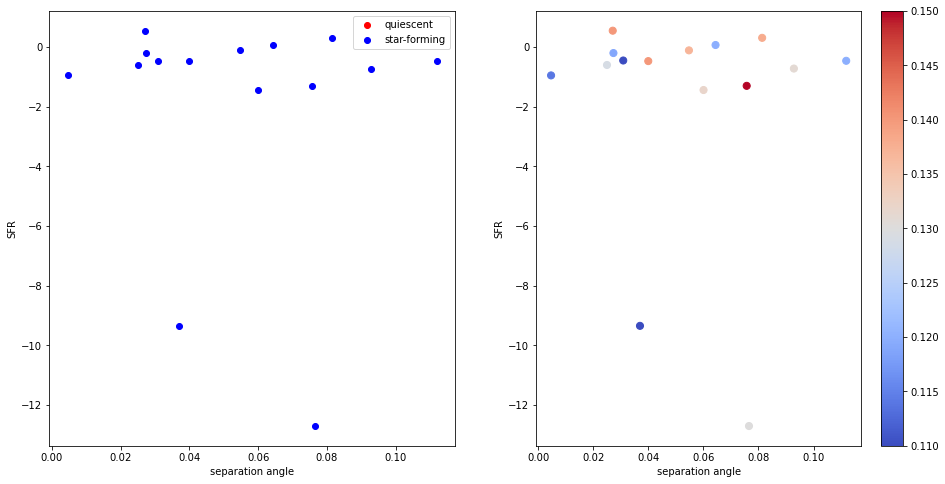

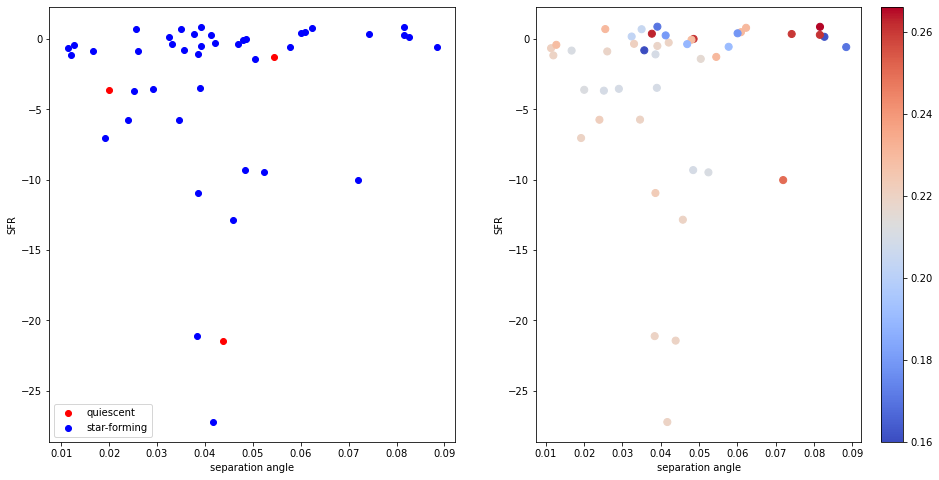

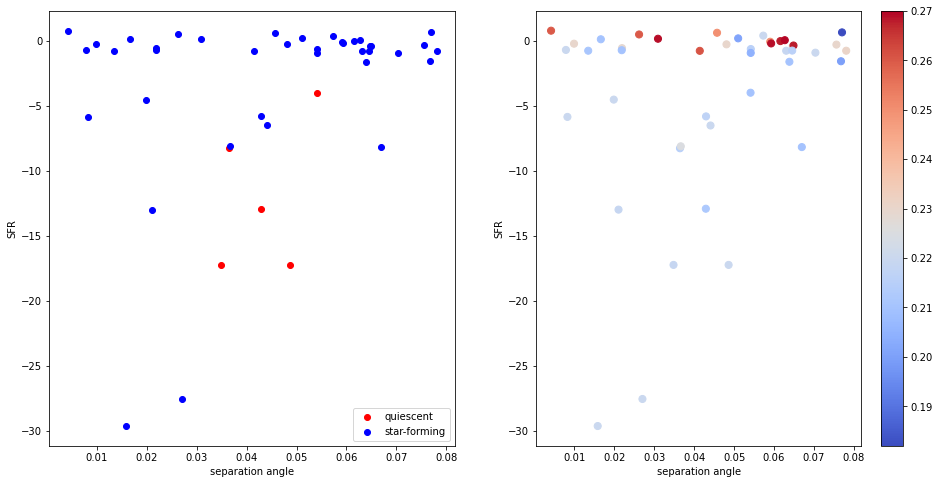

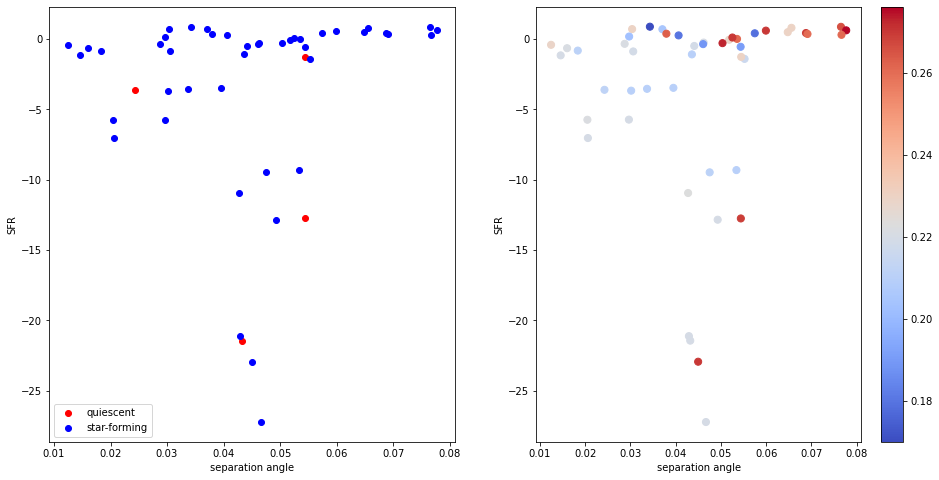

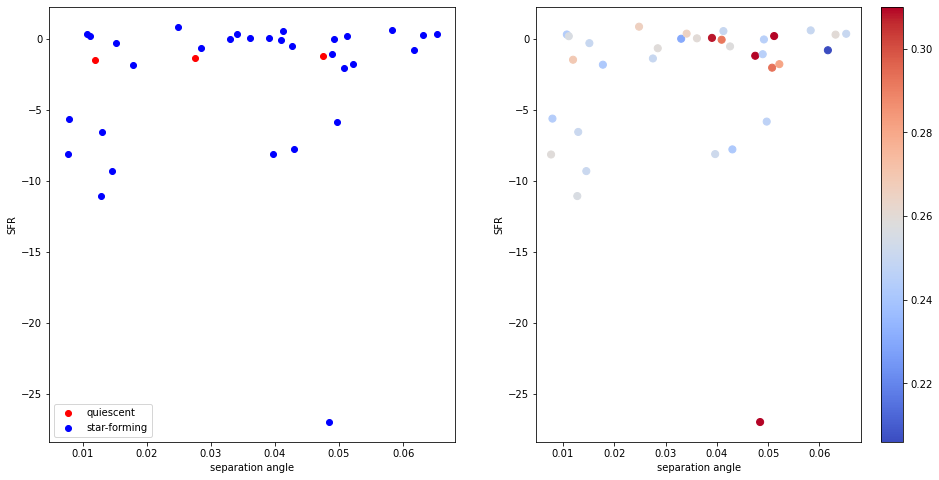

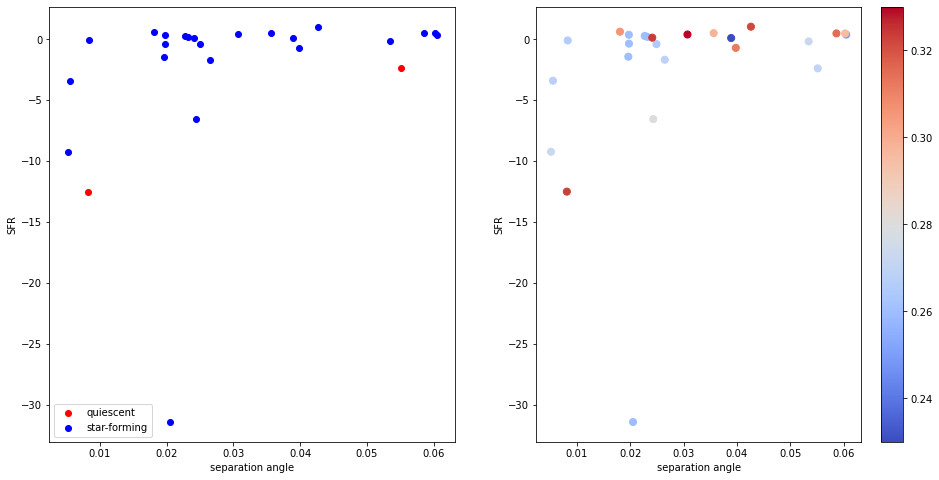

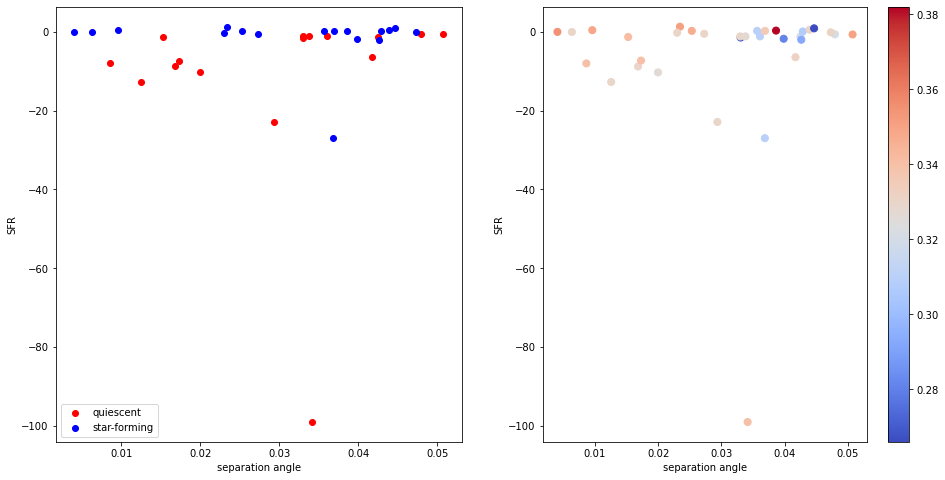

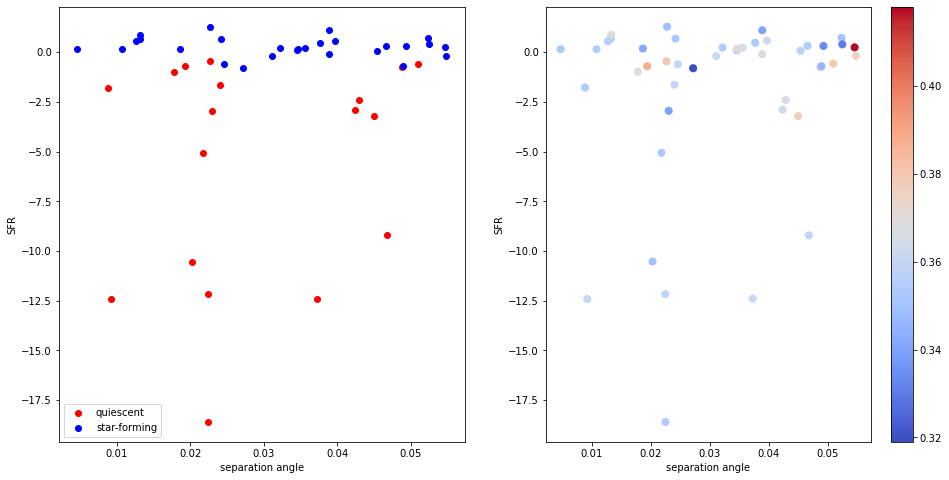

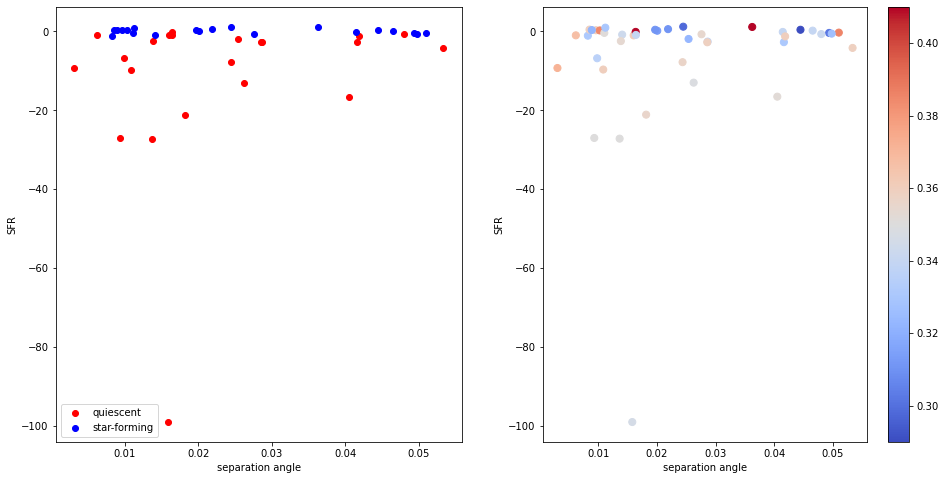

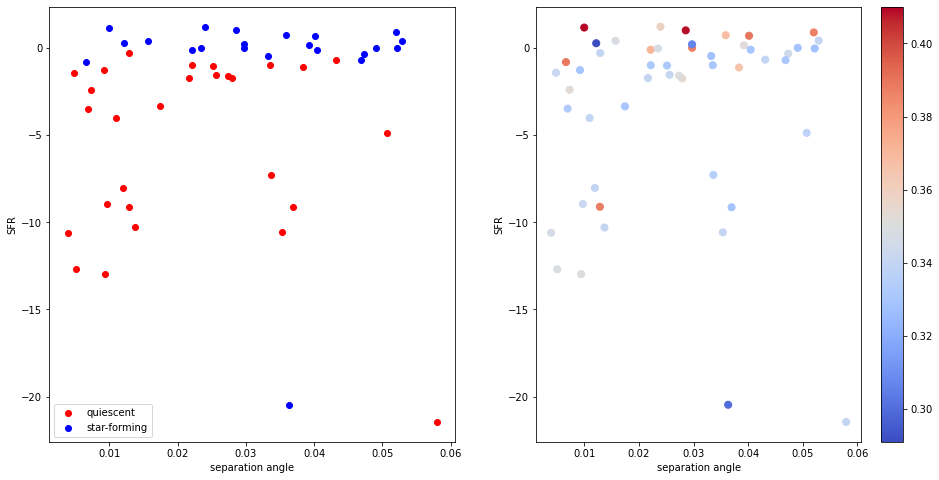

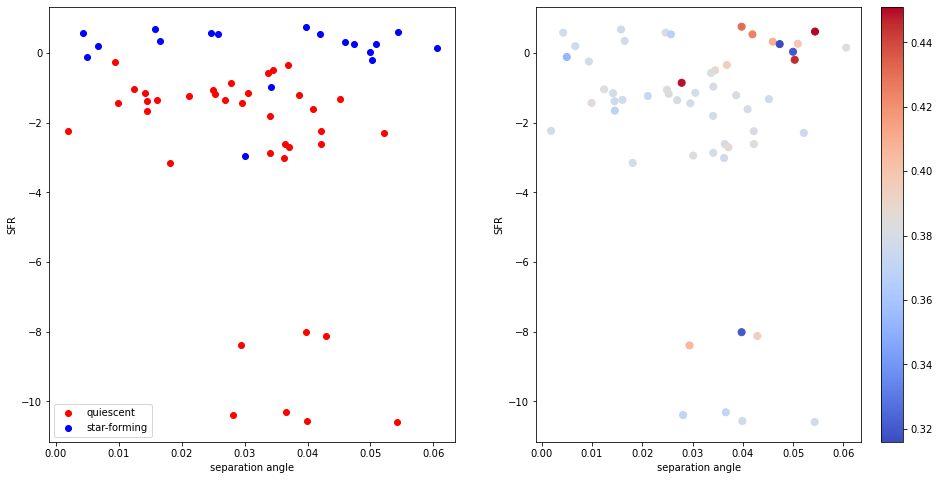

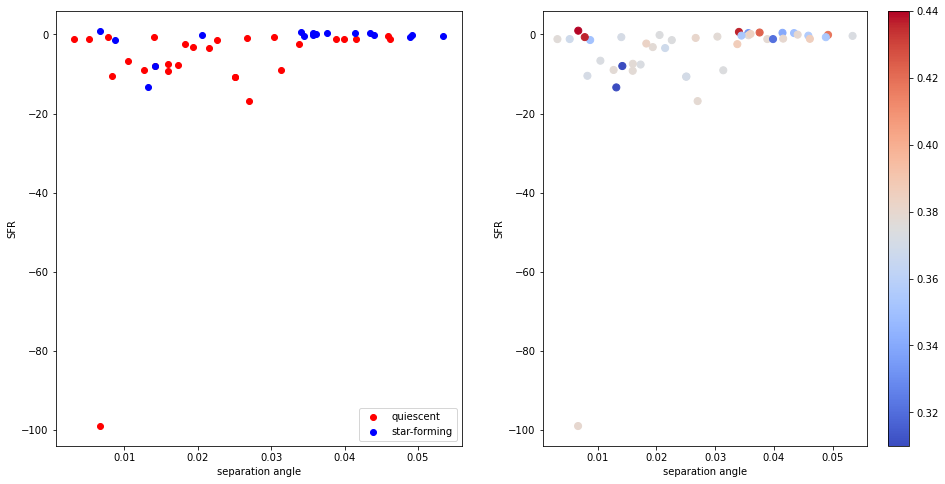

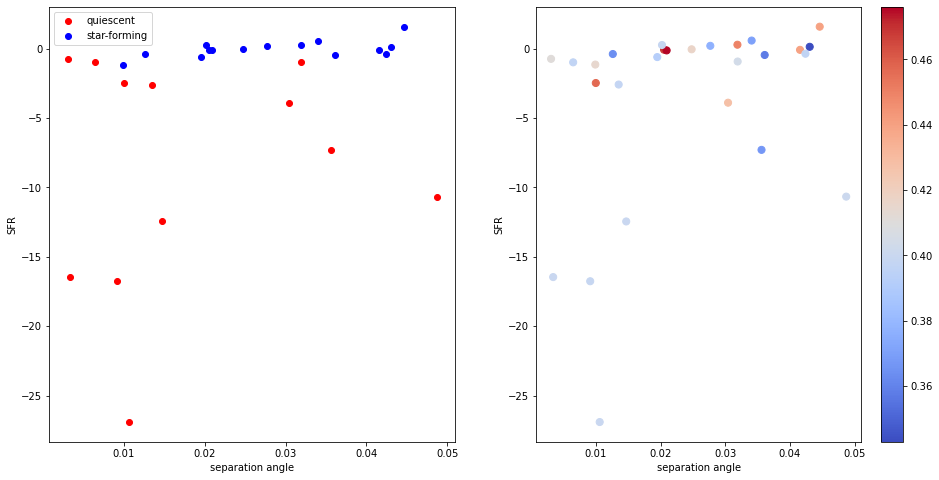

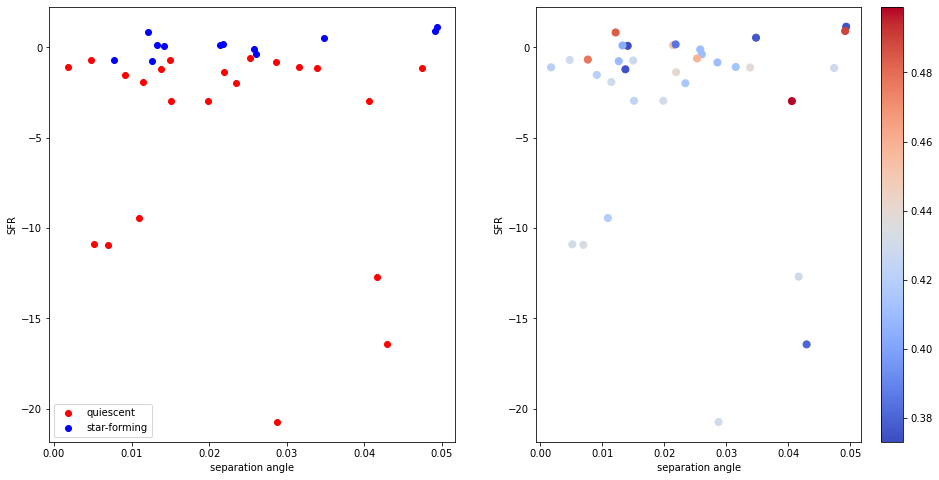

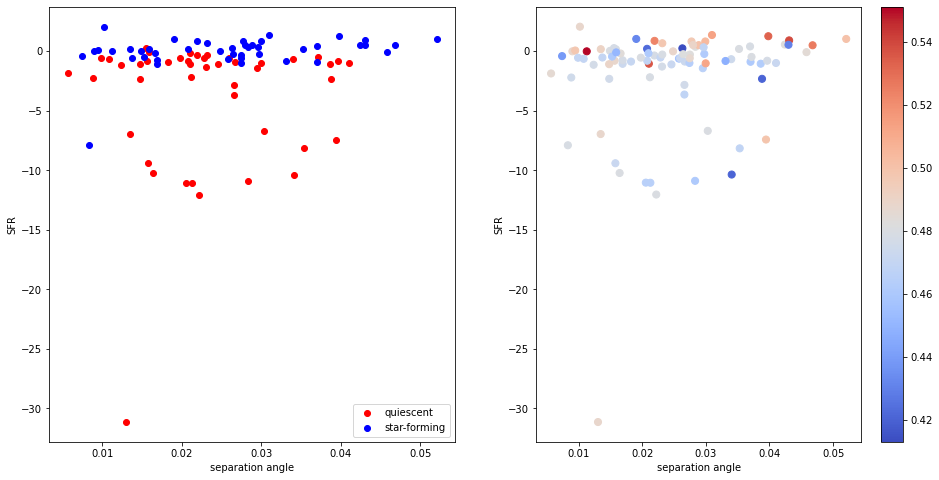

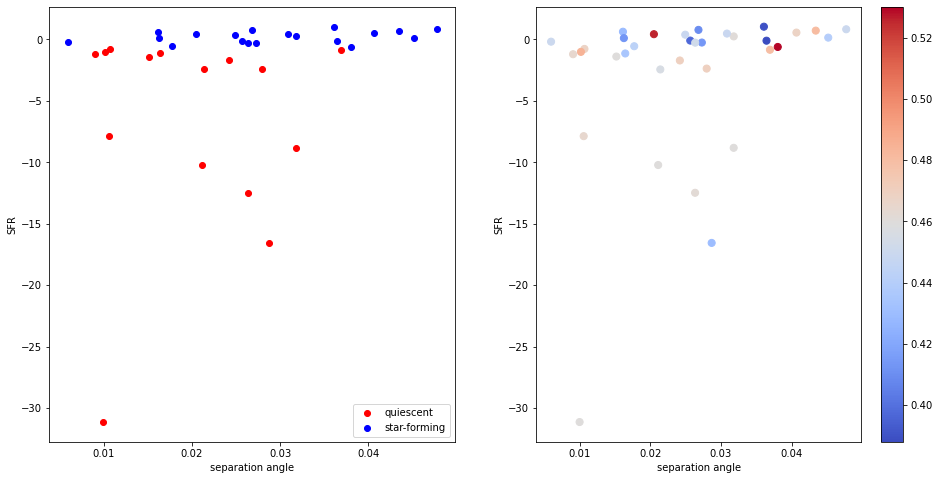

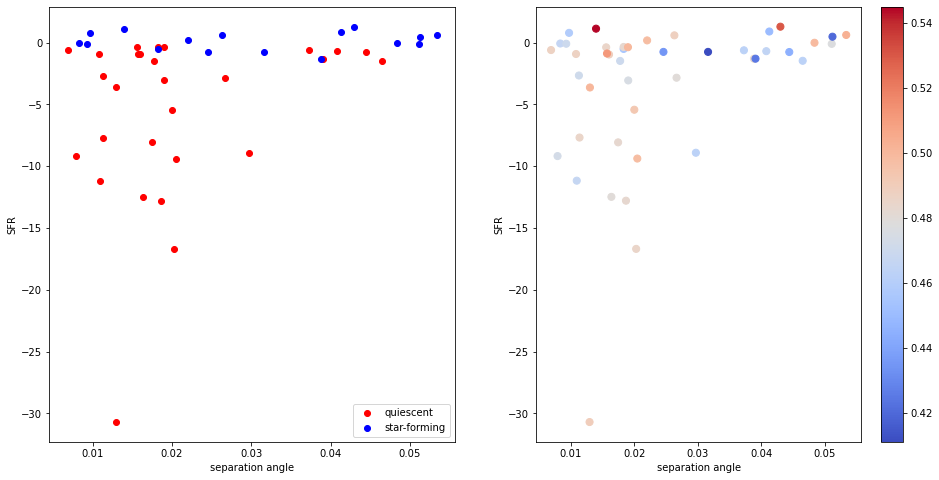

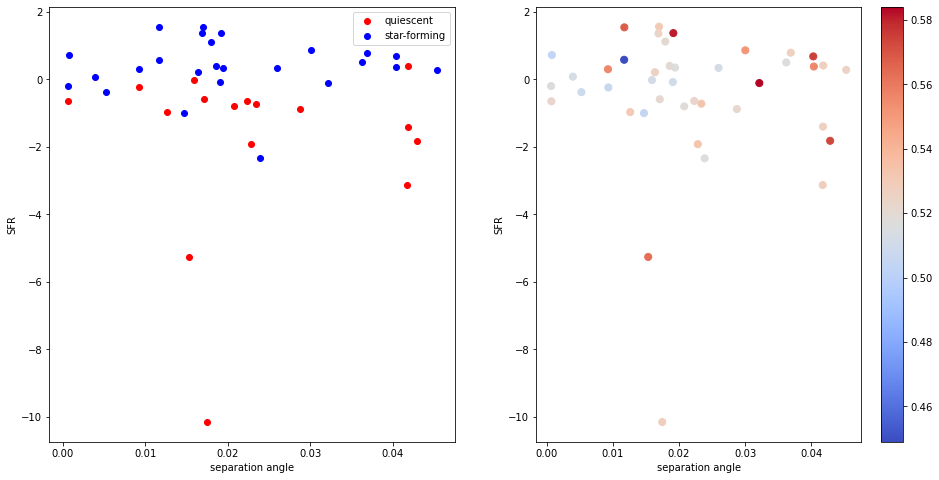

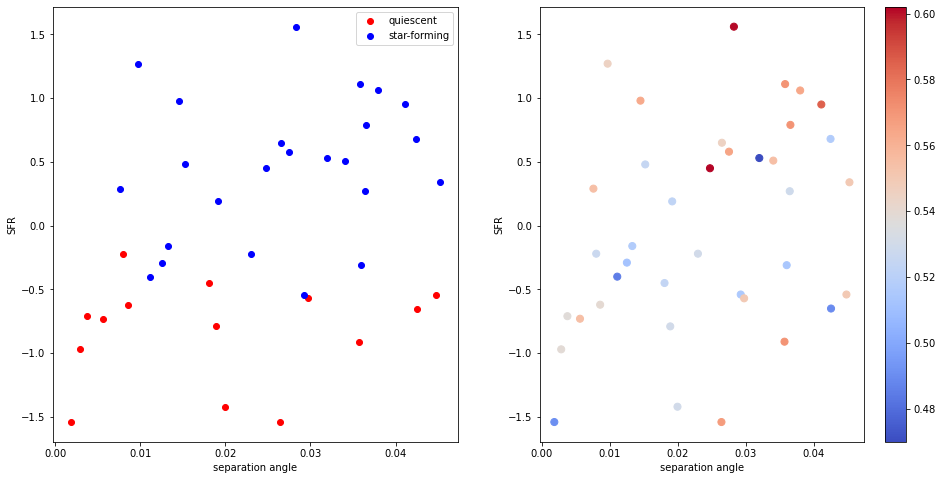

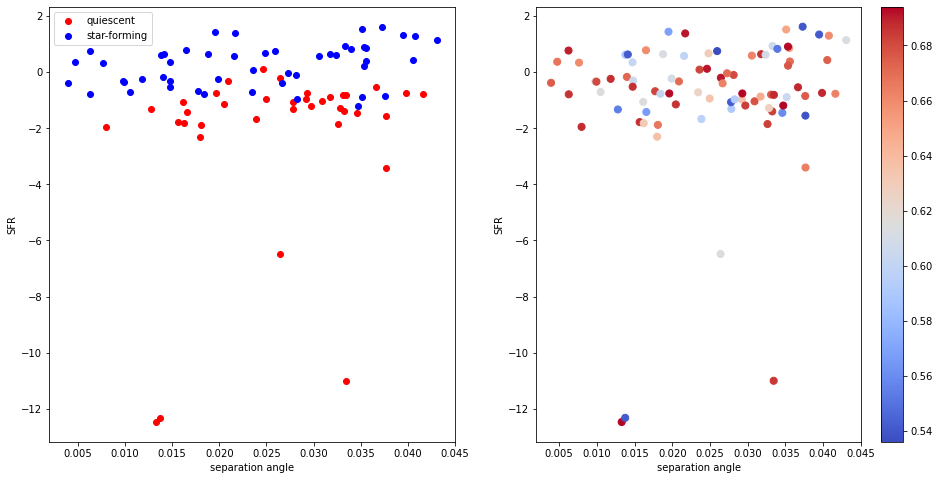

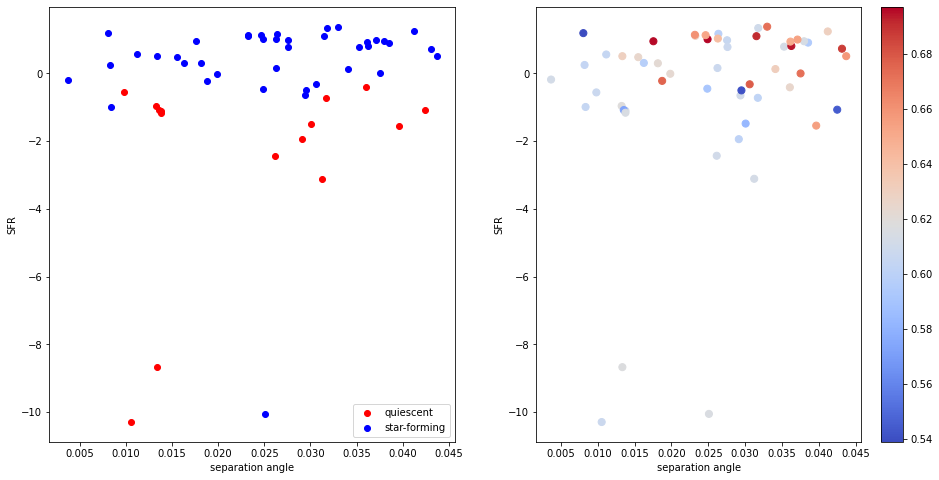

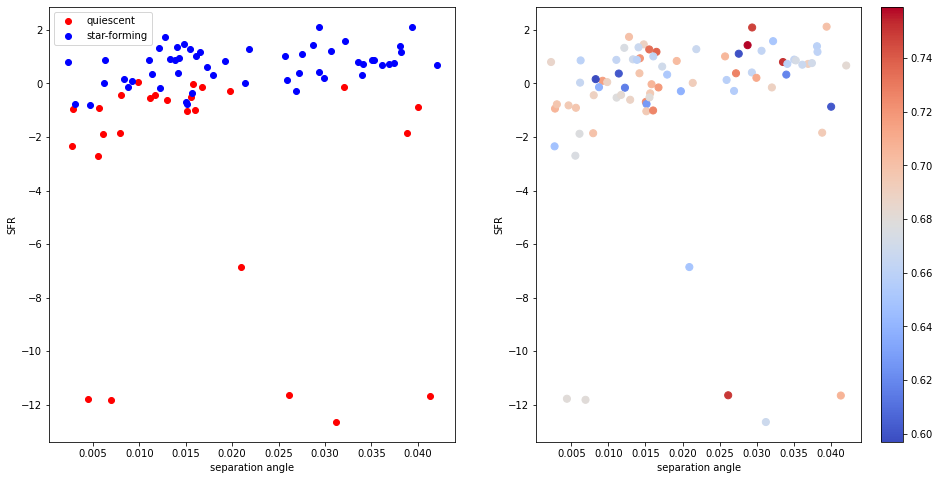

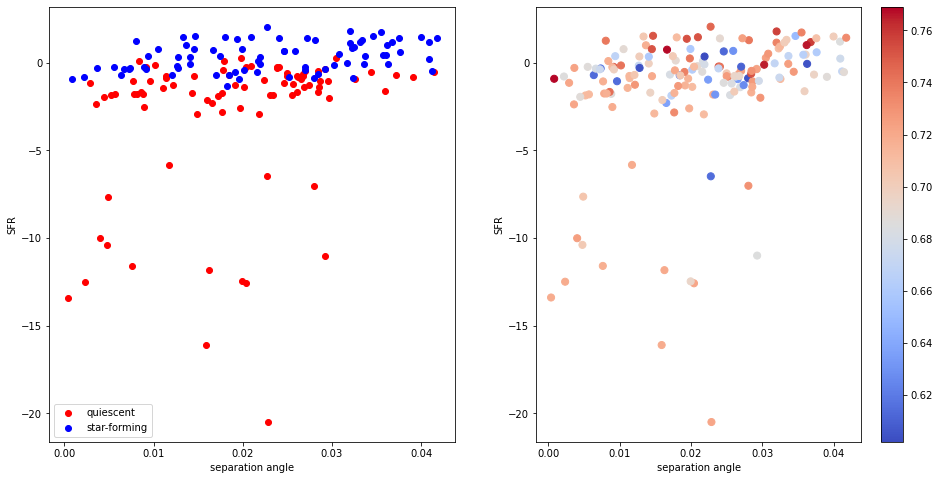

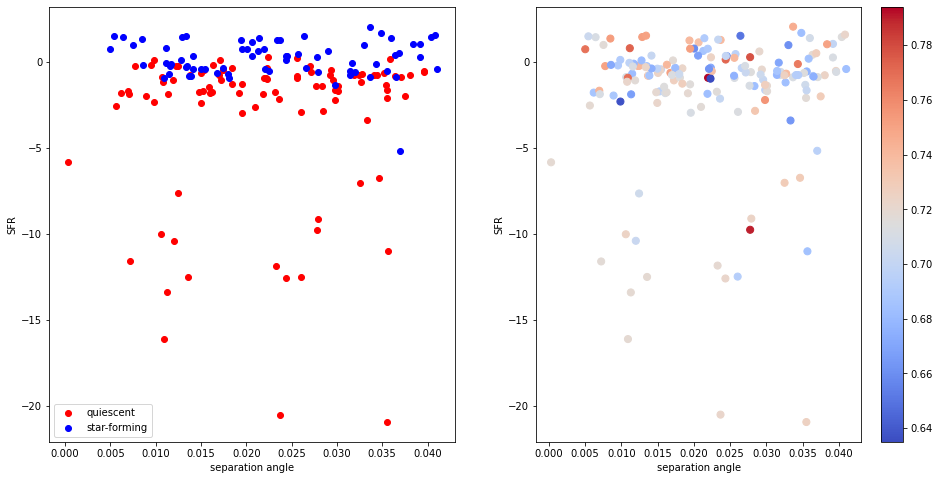

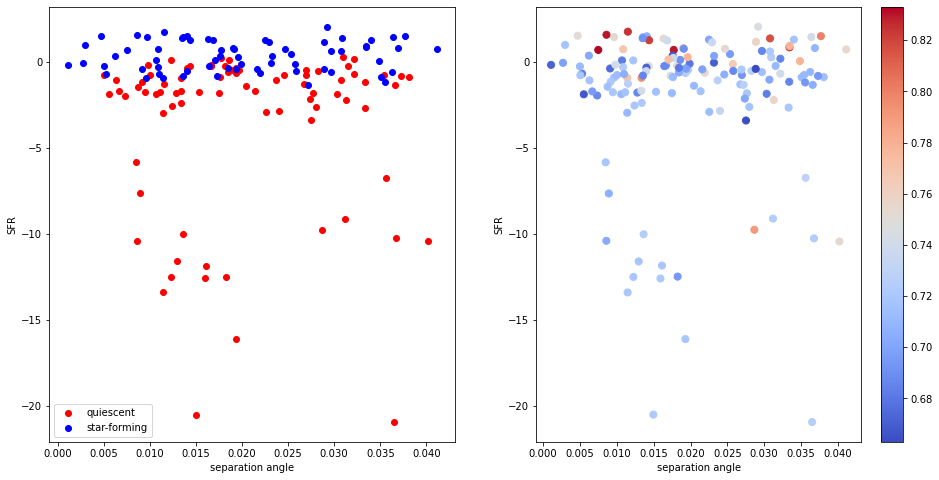

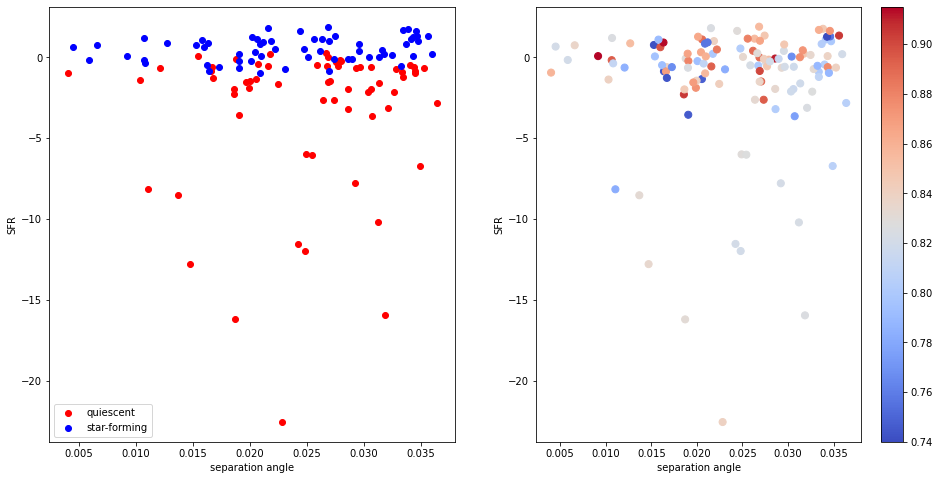

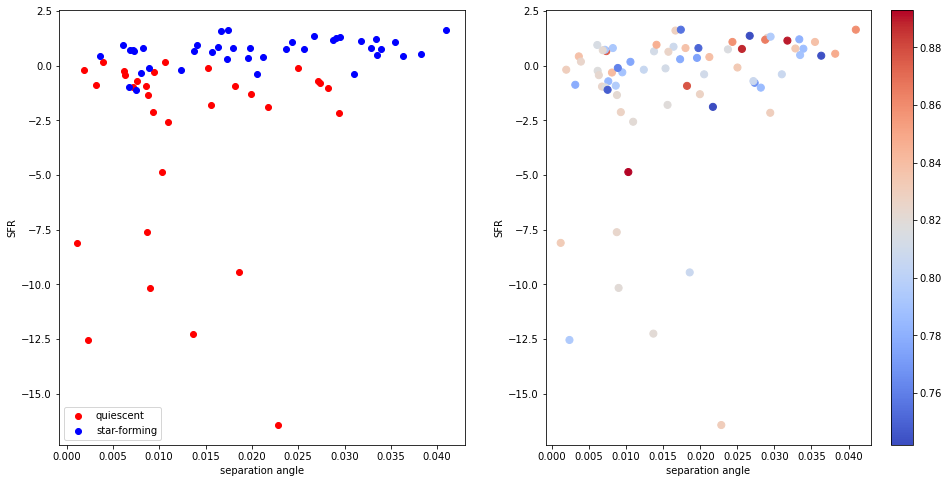

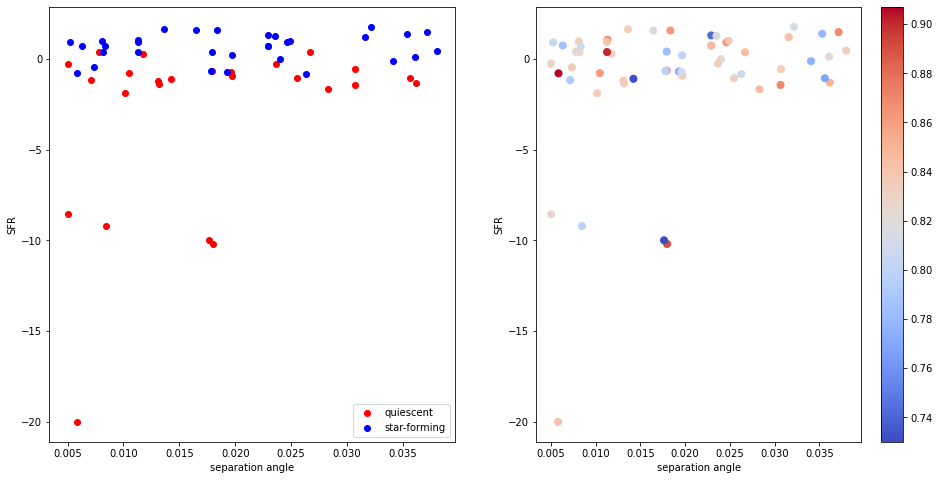

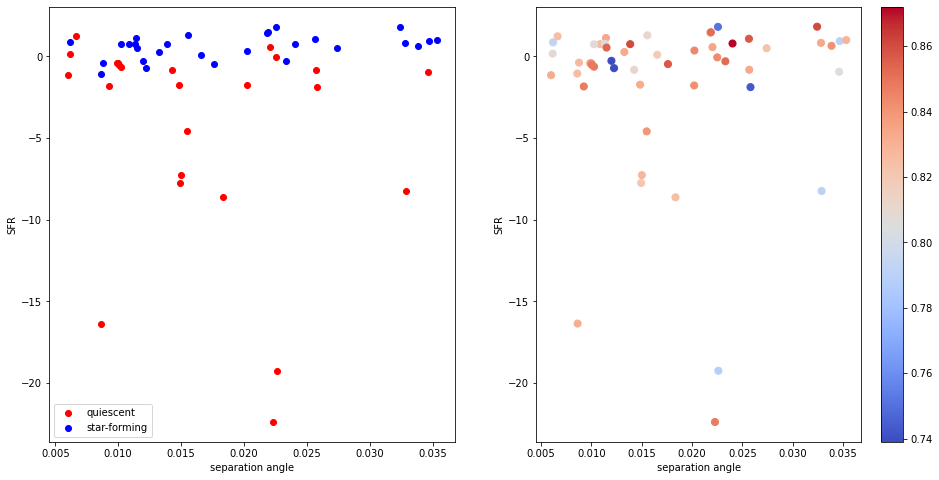

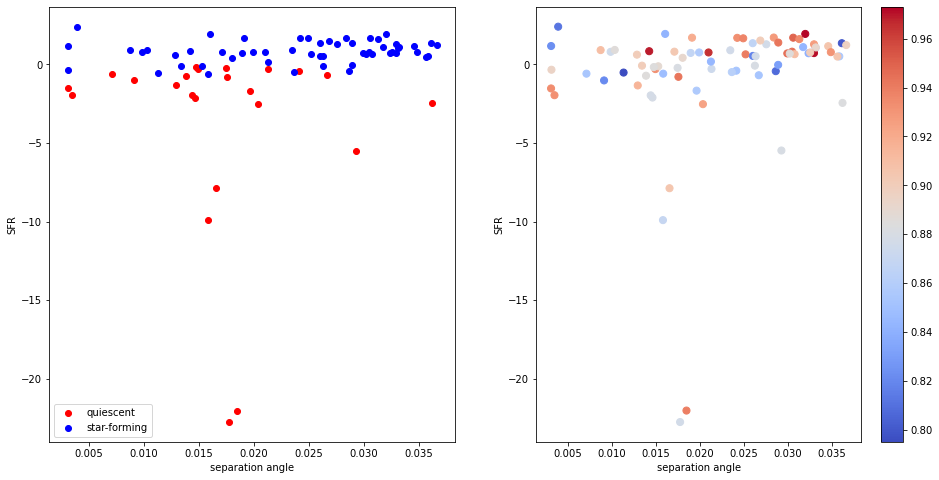

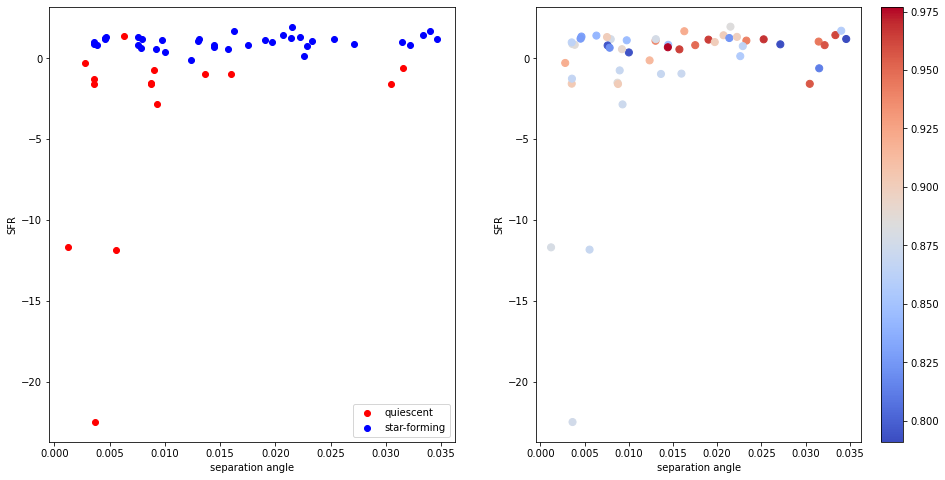

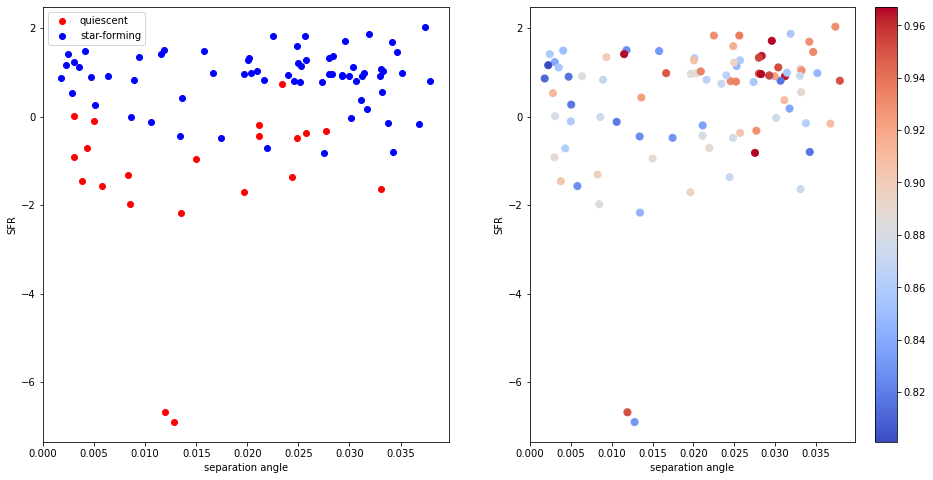

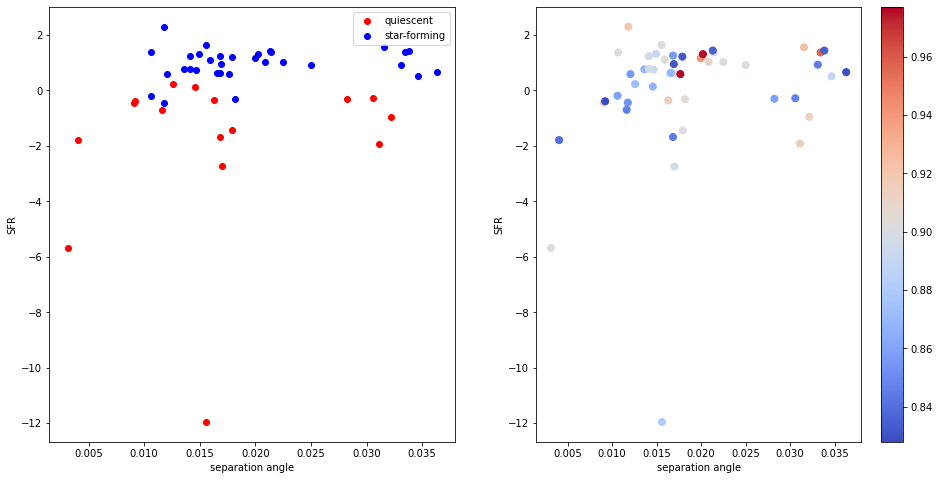

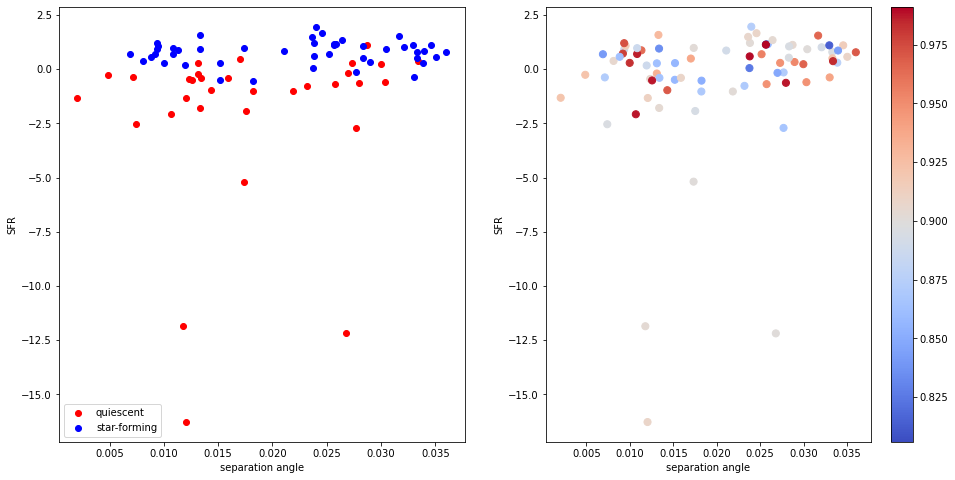

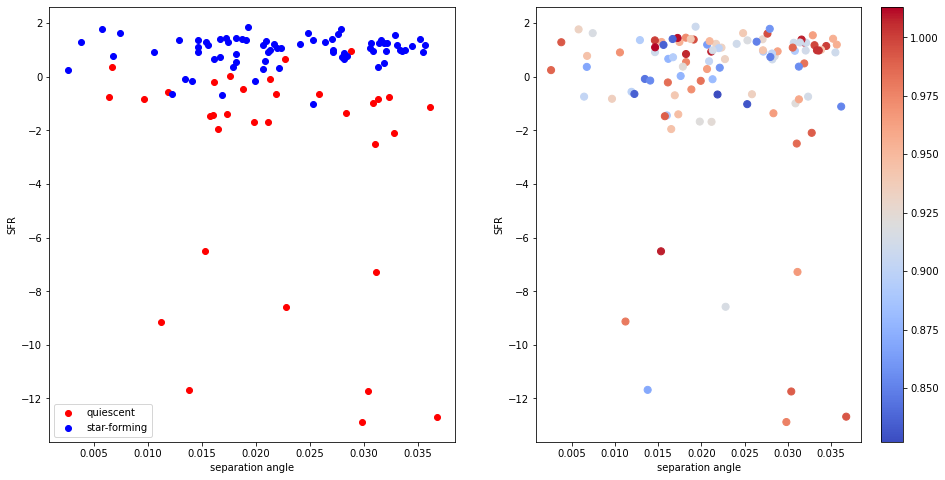

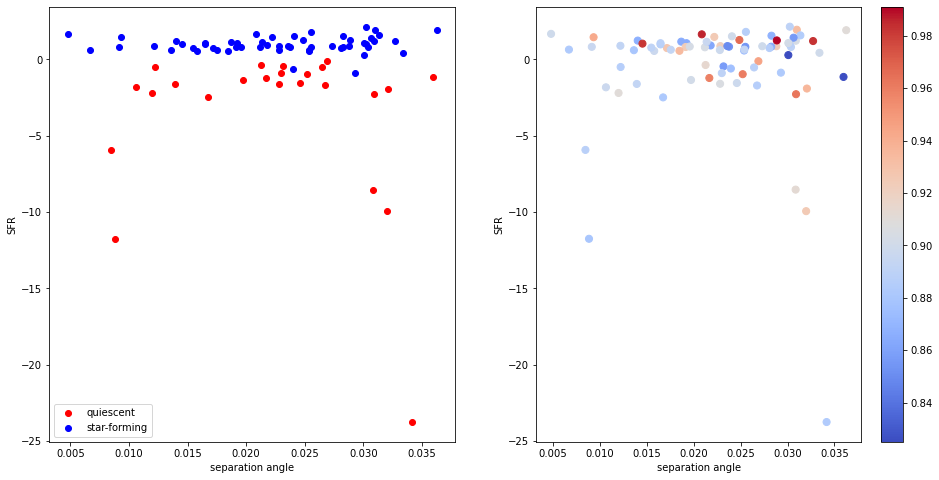

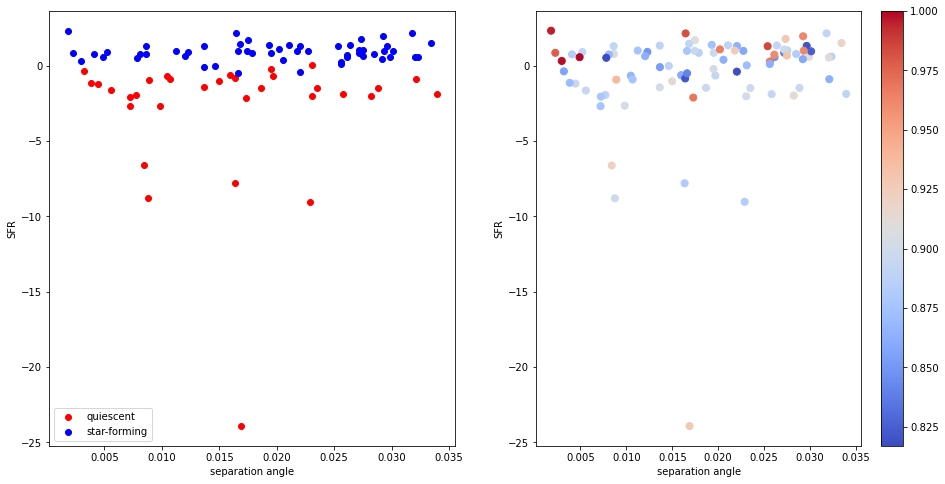

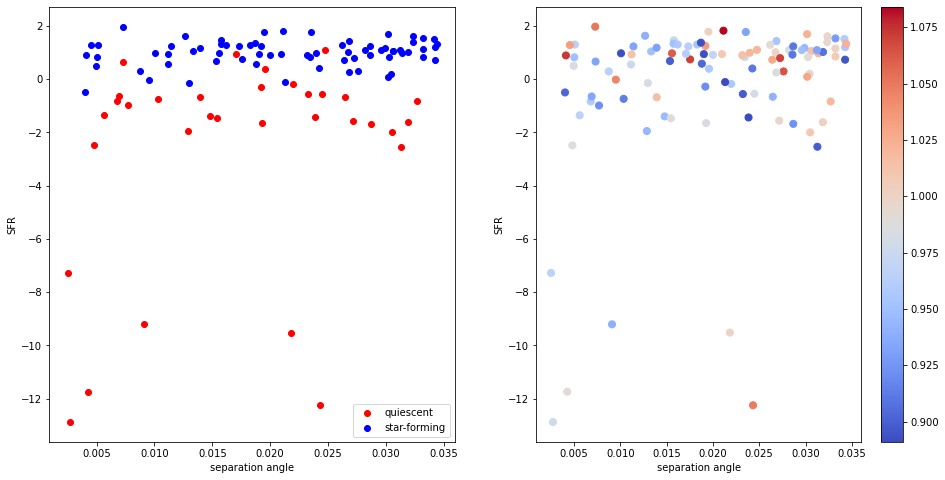

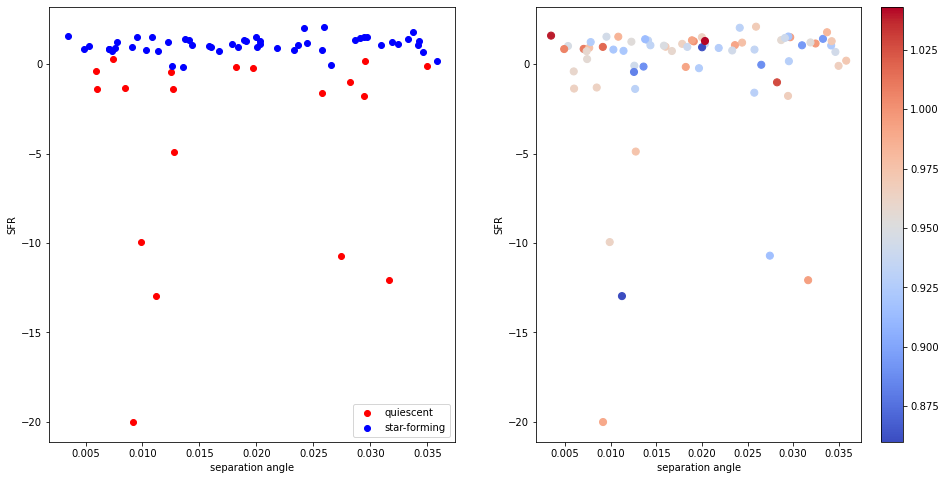

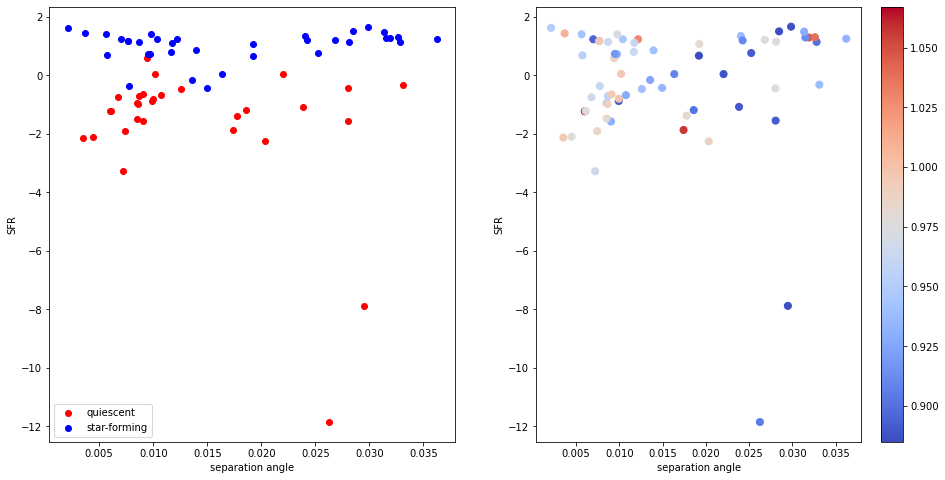

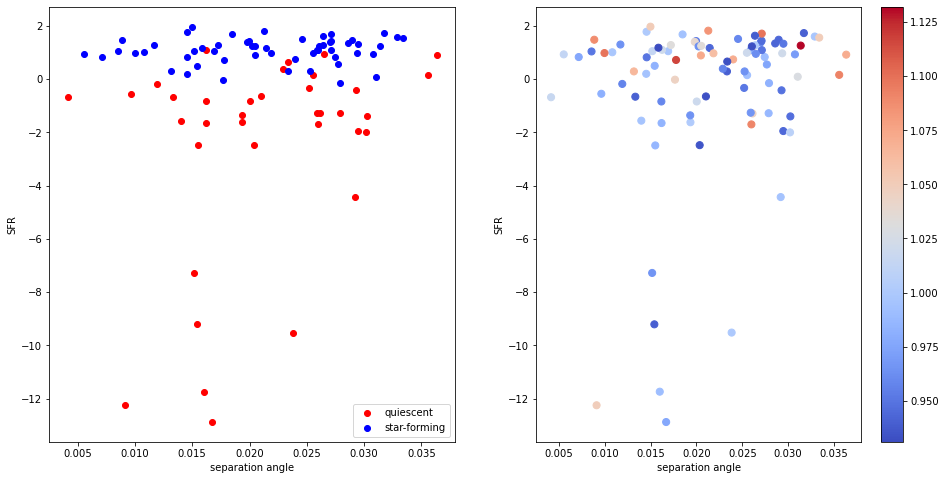

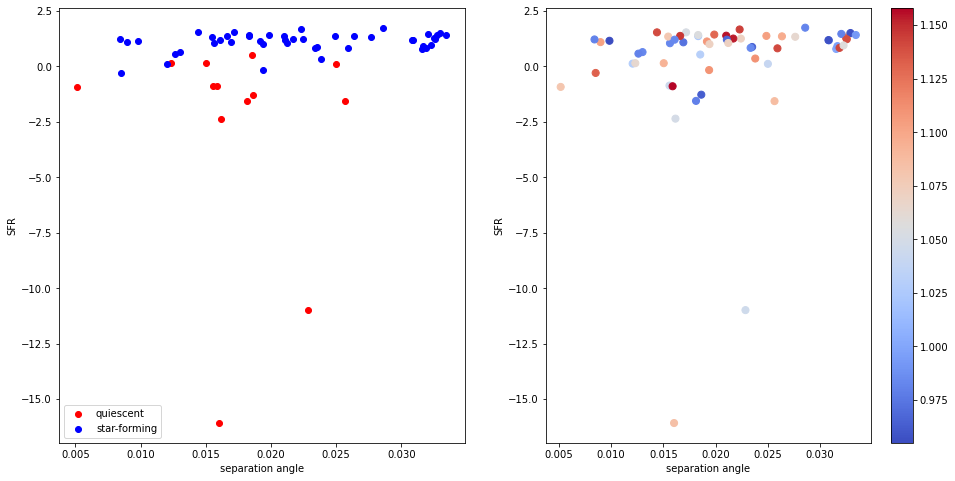

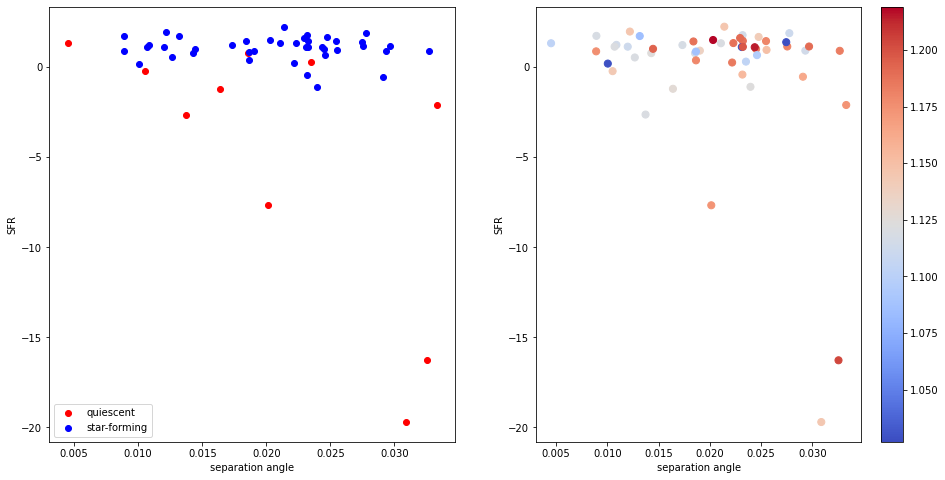

In [82]:
for i, v in enumerate(js_new):

    print(i, end = ' ')
    fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    
    mems = members_new[i]
    
    mask = total_pd['Seq'].isin(mems)
    samp = total_pd[mask]
    
    
    dist = ((samp['RAJ2000'] - samp['RAJ2000'].mean())**2 + (samp['DEJ2000'] - samp['DEJ2000'].mean())**2)**(1/2)
    dist = dist.values
    
    qsamp = (samp['Cl'] == 0)
    sfsamp = (samp['Cl'] == 1)
    

    ax[0].scatter(dist[qsamp], samp['SFR'][qsamp], label = 'quiescent', color = 'red')
    ax[0].scatter(dist[sfsamp], samp['SFR'][sfsamp], label = 'star-forming', color = 'blue')

    plt0 = ax[1].scatter(dist, samp['SFR'], c = samp['zphot'], cmap = plt.cm.coolwarm, s = 50)
    plt.colorbar(plt0, ax = ax[1])
    ax[0].legend()
    
    ax[0].set_xlabel('separation angle')
    ax[0].set_ylabel('SFR')
    
        
    ax[1].set_xlabel('separation angle')
    ax[1].set_ylabel('SFR')
    
    plt.savefig(f'figures/sfrs/sfr{i}.png')
